In [53]:
import random
import numpy as np
import os
from os import path
import time
import copy
import torch
from torch import nn
from gan_training.utils4nb import return_data_test
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from gan_training import utils
from gan_training.train import Trainer, update_average
from gan_training.logger import Logger
from gan_training.checkpoints import CheckpointIO
from gan_training.inputs import get_dataset
from gan_training.distributions import get_ydist, get_zdist
from gan_training.eval_test import DisentEvaluator, Evaluator
from gan_training.config4nb import (
    load_config, build_models, build_optimizers, build_lr_scheduler,
)


In [54]:

# Arguments

#args.config_dir='./configs'
config='cells_650.yaml'
VAEname= 'FactorVAE3'
#VAEname='BetaVAE_H'
chkptname= 'last'
config_dir='./configs'
output_dir= 'Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/'
#dvae_name= None
                   
name='CellCycle' #'Name of the experiment')


In [55]:
#LC-141
#CellCycle-
#CPA-178-
#EMT-161-
#LiveCell - 157


config_path = os.path.join(config_dir, config)
config = load_config(config_path)

nf=-1 #Base number of filters


bs=1 #'Batch size'
reg_param=-1 #'R1 regularization parameter'
w_info =-1#'weighting constant on ID Loss')
mi=max_iter=-1 #'Max training iteration')
num_workers=0 #'dataloader num_workers'
#batch_size=32 # help='batch size'

image_size= 256         # Generator Image size
dset_dir='C:/Users/Rashmi/ProcessedData/'
dataset='LiveCell/Selected/' #CellCycle/Vero/LC
datatype='rgb'
nc= 3

#parser.add_argument('--img_size', default=128, type=int, help='Image synthesis size')##This is the image size for which the autoencoder is designed to


c_dim= 10 #Latent synthesis size'
z_dim=256 #type=int, help='Image synthesis size')

no_cuda=False #help='Do not use cuda')
seed=1 #type=int, help='Random Seed')
infodistil_mode=True #'Infodistill')
#args = parser.parse_args()

dvae_name='cells_trial_factor157' 
name='GAN_Trial157'

#config_path = os.path.join(config_dir, config)
#config = load_config(config_path)
is_cuda = (torch.cuda.is_available() and not no_cuda)


C:\Users\Rashmi\WorkingLibs\idgan-master_Jan\gan_training\config4nb.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [56]:
dataset

'LiveCell/Selected/'

In [57]:
is_cuda

True

In [58]:

# = = = = = Customized Configurations = = = = = #
output_dir='Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/'

checkpoint_dir = os.path.join(output_dir , name, 'chkpts')

out_dir = os.path.join(output_dir, name)



In [59]:
device = torch.device("cuda:0" if is_cuda else "cpu")
device

device(type='cuda', index=0)

In [60]:

# Logger
checkpoint_io = CheckpointIO(
    checkpoint_dir=checkpoint_dir
)

device = torch.device("cuda:0" if is_cuda else "cpu")

train_dataset = get_dataset(
    name='image',
    data_dir=dset_dir,
    size=image_size,
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=bs,
        num_workers=3,
        shuffle=True, pin_memory=True, sampler=None, drop_last=True
)



In [61]:

#Create models
fvae, generator, discriminator = build_models(image_size, c_dim, nc, z_dim)
data_loader = return_data_test(dataset, datatype, dset_dir, bs, image_size)



In [62]:
fvae

FactorVAE256(
  (encoder): Encoder256(
    (layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
      (13): ReLU(inplace=True)
      (14): View()
      (15): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): Decoder256(
    (layer): Sequential(
      (0): Linear(in_features=10, out_features=256, bias

In [63]:
selectVAE='fvae'

if selectVAE=='dvae':
    dvae_ckpt_path =  os.path.join(output_dir, dvae_name,'chkpts', chkptname)

    dvae_ckpt = torch.load(dvae_ckpt_path)
    #for key in list(dvae_ckpt_path.keys()):
    #    dvae_ckpt_path[key.replace('decoder.', 'module.decoder.'). replace('encoder.', 'module.encoder.')] = dvae_ckpt_path.pop(key)

    dvae.load_state_dict(dvae_ckpt_path)
else:

    fvae_ckpt_path = os.path.join(output_dir, dvae_name,'chkpts', chkptname)

    fvae_ckpt = torch.load(fvae_ckpt_path)

    for key in list(fvae_ckpt['model_states']['VAE'].keys()):
        fvae_ckpt['model_states']['VAE'][key.replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('decode.', 'decoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.').
                                         replace('encode.', 'encoder.layer.')] = fvae_ckpt['model_states']['VAE'].pop(key)


    fvae.load_state_dict(fvae_ckpt['model_states']['VAE'])

    dvae=fvae


In [64]:
output_dir

'Z:/COVID-FTP/Rashmi/ID-GANCheckpoints/outputs/'

In [65]:
# Put models on gpu if needed
dvae = dvae.to(device)
generator = generator.to(device)
discriminator = discriminator.to(device)

#g_optimizer, d_optimizer = build_optimizers(
#    generator, discriminator, dvae, config
#)

# Use multiple GPUs if possible
dvae = nn.DataParallel(dvae)
generator = nn.DataParallel(generator)
discriminator = nn.DataParallel(discriminator)

In [66]:
generator

DataParallel(
  (module): Generator(
    (fc): Linear(in_features=266, out_features=8192, bias=True)
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (5): Upsample(scale_factor=2.0, mode=nearest)
      (6): ResnetBlock(
        (conv_0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [67]:
discriminator

DataParallel(
  (module): Discriminator(
    (conv_img): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (2): ResnetBlock(
        (conv_0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (3): AvgPool2d(kernel_size=3, stride=2, padding=1)
      (4): ResnetBlock(
        (conv_0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_s): Conv2d(128, 256, kernel_size=(1, 1), strid

In [68]:

# Register modules to checkpoint
checkpoint_io.register_modules(
    generator=generator,
    discriminator=discriminator,

)

# Logger
logger = Logger(
    log_dir=path.join(out_dir, 'logs'),
    img_dir=path.join(out_dir, 'imgs'),
    #monitoring=config['training']['monitoring'],
    #monitoring_dir=path.join(out_dir, 'monitoring')
)


# Distributions
cdist = get_zdist('gauss',c_dim, device=device)
zdist = get_zdist('gauss', z_dim,
                  device=device)

 
# Save for tests
ntest = bs
#x_real, ytest = utils.get_nsamples(train_loader, ntest)
ztest = zdist.sample((ntest,))
ctest = cdist.sample((ntest,))
ztest_ = torch.cat([ztest, ctest], 1)

In [69]:

generator_test = generator

# Evaluator
dis_evaluator = DisentEvaluator(generator=generator_test, zdist=zdist, cdist=cdist,
                                batch_size=bs, device=device, dvae=dvae)
#data_loader = return_data_test()

# Train
tstart = t0 = time.time()
it = epoch_idx = -1

In [70]:
generator_test

DataParallel(
  (module): Generator(
    (fc): Linear(in_features=266, out_features=8192, bias=True)
    (resnet): Sequential(
      (0): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Upsample(scale_factor=2.0, mode=nearest)
      (2): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ResnetBlock(
        (conv_0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (5): Upsample(scale_factor=2.0, mode=nearest)
      (6): ResnetBlock(
        (conv_0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [71]:
# Load checkpoint if existant
it = checkpoint_io.load('model.pt')
if it != -1:
    logger.load_stats('stats.p')
# Training loop


=> Loading checkpoint...


In [72]:

mu_real_Dump=[]
mu_gen_Dump=[]
mu_real_All=[]
mu_gen_All=[]
label1=[]
label2=[]
travN_MainDir='./outputs/TraversalLoop/'
device

device(type='cuda', index=0)

In [73]:
t = time.time()

for x_true, path, label in data_loader:
    epoch_idx += 1

    #for x_real, _ in train_loader:
    
    x_true=x_true.to(device)

    mu_real, logvar, c_real = fvae(x_true, encode_only=True)
    print(c_real)
    
    recon_img=dis_evaluator.predict_image(c_real)
    recon_img=torch.stack(recon_img)
    mu_gen, logvar_gen, c_gen=fvae(recon_img, encode_only=True)
    
    mu_real_All.append(mu_real.detach().cpu())
    mu_gen_All.append(mu_gen.detach().cpu())
    
    
    mu, c_lat=dis_evaluator.predict_latent(x_true)
    Traverse=0
    if Traverse==True:
        if epoch_idx < 50:
            
            travN =  epoch_idx
            travN_dir = os.path.join(travN_MainDir, str(travN))
            #print('checkpoint_dir',checkpoint_dir)
            # Create missing directories
            if not os.path.exists(travN_dir):
                os.makedirs(travN_dir)
                
            c_lat_sample=c_lat
            z_sample=ztest[0]
            #c_lat_sample=c_lat_sample.unsqueeze(0)
            z_sample=z_sample.unsqueeze(0)
            travN
            ncol=dis_evaluator.traverse_c1z1(travN, z_sample, c_lat_sample, save='True', save_type='idgan', TravImRet='False', cmap='viridis')

## Sorting the feature tables according to order generated in the ImageGenerator 
    label1.append(label)
    label2.append(path)
    # do stuff
elapsed = time.time() - t
print('Time taken to complete testing this dataset=')
print(elapsed)

tensor([[-5.2438, -5.2900, -5.3090, -5.5882, -5.6204, -5.2973, -5.1930, -5.5179,
         -5.1855, -5.4885]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9397, -7.1709, -7.5718, -7.0802, -7.4106, -7.0525, -7.1446, -7.1782,
         -6.5550, -7.0333]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5692, -6.4950, -6.8086, -6.8039, -7.0657, -6.5729, -6.4671, -6.8957,
         -6.7892, -7.1891]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6202, -6.8182, -6.5659, -6.9257, -7.0698, -6.4980, -6.6135, -6.7558,
         -6.0852, -6.5816]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1514, -7.5700, -7.4976, -7.3167, -7.5732, -7.0080, -7.3411, -7.2959,
         -7.0297, -6.6916]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0366, -6.0740, -6.1323, -6.5394, -6.3104, -5.9716, -6.1180, -6.2884,
         -6.1144, -6.4998]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6853, -6.6206, -6.8326, -6.9756, -7.4156, -6.4238, -6.6378, -6.9467,
 

tensor([[-5.9078, -5.9273, -6.2034, -5.7495, -6.1905, -5.9182, -5.9629, -6.1548,
         -5.9811, -6.3596]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3293, -7.4361, -7.3774, -7.4944, -7.7609, -7.2653, -7.3108, -7.5751,
         -6.8798, -7.3242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1326, -5.1929, -5.3203, -5.5353, -5.6295, -4.9575, -5.1689, -5.3471,
         -4.9366, -5.2036]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8995, -7.0035, -7.3496, -7.3696, -7.3923, -7.0895, -6.9224, -7.2043,
         -6.7804, -7.2569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3729, -5.4779, -5.4131, -5.7790, -5.8435, -5.4184, -5.3884, -5.7075,
         -5.2484, -5.5578]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2612, -5.2690, -5.4762, -5.4780, -5.4131, -5.0020, -5.3624, -5.0692,
         -4.8662, -5.3632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.7813, -8.8861, -8.9795, -8.8705, -9.2043, -8.9182, -8.9042, -9.2280,
 

tensor([[-5.1678, -5.2031, -5.3572, -5.4949, -5.6534, -5.1906, -5.1556, -5.3222,
         -5.1752, -5.5569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.3905, -8.7164, -8.5725, -8.0480, -8.0305, -8.2490, -8.7457, -8.6963,
         -7.9135, -8.7977]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8386, -5.8641, -6.0949, -5.9897, -6.1945, -5.7979, -5.7815, -6.0146,
         -5.7709, -5.9599]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8250, -7.0256, -6.8321, -7.4557, -7.4189, -6.8683, -6.8035, -7.1935,
         -6.4741, -7.1551]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.1748, -8.3861, -8.2329, -8.4608, -8.1974, -8.2694, -8.4615, -8.4193,
         -7.8606, -8.3434]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1402, -6.2121, -6.3303, -6.6980, -6.8828, -6.1939, -6.1150, -6.4941,
         -6.0661, -6.3537]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4510, -6.5123, -6.5650, -6.8123, -6.8782, -6.5552, -6.4025, -6.8100,
 

tensor([[-4.8583, -4.9114, -4.9960, -5.2571, -5.3058, -4.8904, -4.8464, -5.0082,
         -4.7459, -5.0832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5073, -6.6157, -6.7926, -6.5154, -6.4216, -6.7464, -6.6994, -6.4580,
         -6.1170, -6.7295]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3372, -7.5131, -7.6461, -7.4477, -7.2858, -7.3704, -7.4869, -7.3306,
         -6.7920, -7.1534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5195, -5.4266, -5.6927, -5.9836, -6.0758, -5.4428, -5.4841, -5.7739,
         -5.4758, -5.7159]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3653, -6.5003, -6.6905, -6.5394, -6.9829, -6.5447, -6.4622, -6.6229,
         -6.2996, -6.7879]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6374, -5.6763, -5.9447, -6.0742, -6.0757, -5.7948, -5.7227, -5.8045,
         -5.6572, -6.0312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1618, -7.2249, -7.2672, -7.3602, -7.4225, -7.3692, -7.1352, -7.5259,
 

tensor([[-6.6989, -6.7773, -6.8219, -7.0557, -7.0948, -6.5672, -6.7174, -6.8917,
         -6.6547, -6.5201]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8001, -6.7958, -7.0456, -7.2535, -7.3762, -6.9911, -6.8206, -7.2125,
         -7.0244, -7.3002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7133, -8.0406, -7.7157, -7.8604, -7.6852, -7.7865, -7.7786, -8.0377,
         -7.2960, -7.8803]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5464, -6.6040, -6.6546, -6.9943, -6.9701, -6.6778, -6.5461, -6.9536,
         -6.5731, -7.0403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[ -9.7685, -10.1465,  -9.8280,  -9.3797,  -9.3375,  -9.6772, -10.1568,
          -9.9811,  -8.9124,  -9.6371]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-5.9883, -6.0953, -6.1778, -6.2818, -6.4025, -6.0248, -6.0625, -6.3626,
         -6.0497, -6.2249]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8470, -5.9949, -6.1045, -6.0703, -6.2452, -6.0669, -5

tensor([[-6.8427, -6.9813, -6.9749, -7.2764, -7.3133, -6.9220, -6.8551, -7.1811,
         -6.9322, -7.1025]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9504, -5.9894, -6.0636, -6.4490, -6.4623, -6.0347, -5.9001, -6.2621,
         -5.9971, -6.2685]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1808, -6.2644, -6.2691, -6.3889, -6.4197, -6.3507, -6.3229, -6.4186,
         -6.1993, -6.4793]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0538, -5.1732, -5.0091, -5.4212, -5.4628, -4.9370, -5.0700, -5.2769,
         -4.9122, -5.1760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1301, -7.3249, -7.5438, -7.3515, -7.5778, -7.3201, -7.1740, -7.4201,
         -6.9390, -7.2894]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8153, -6.9964, -6.8011, -7.0548, -7.0482, -6.9278, -6.8756, -6.9975,
         -6.3299, -7.1633]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1014, -6.1557, -6.2254, -6.7394, -6.6989, -6.0691, -6.1287, -6.3992,
 

tensor([[-6.6584, -6.8225, -6.8208, -7.1023, -7.2411, -6.7537, -6.6711, -7.0599,
         -6.6553, -6.8654]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1746, -6.2857, -6.2015, -6.5962, -6.6664, -6.2162, -6.1396, -6.5055,
         -6.1066, -6.4147]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9069, -5.9452, -6.0929, -6.2911, -6.3868, -6.0343, -5.8349, -6.1757,
         -6.0002, -6.2759]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1490, -6.1752, -6.3038, -6.6041, -6.6567, -6.1433, -6.0852, -6.4642,
         -6.2055, -6.4839]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4325, -7.7031, -7.6612, -7.6366, -7.9350, -7.5295, -7.4783, -7.7889,
         -7.0349, -7.6498]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2106, -6.4623, -6.3129, -6.5023, -6.6845, -6.3373, -6.2387, -6.6282,
         -6.0862, -6.6570]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0956, -7.4326, -7.2103, -7.4651, -7.3783, -7.2759, -7.2432, -7.4859,
 

tensor([[-6.8891, -7.0149, -7.1616, -7.2087, -7.3621, -7.1174, -6.8199, -7.2044,
         -6.8349, -7.1863]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4599, -4.5586, -4.5916, -4.8679, -4.9150, -4.4379, -4.5256, -4.6491,
         -4.1728, -4.6394]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4555, -5.4800, -5.6309, -5.6866, -5.8052, -5.5718, -5.3905, -5.7020,
         -5.4345, -5.6970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3239, -5.4530, -5.3301, -5.7018, -5.6386, -5.2906, -5.3548, -5.5271,
         -4.8748, -5.6565]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2612, -4.2732, -4.3439, -4.4632, -4.5588, -4.1767, -4.2793, -4.4785,
         -4.2720, -4.3549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6966, -5.7869, -5.7429, -6.1966, -6.2054, -5.6738, -5.7116, -5.9565,
         -5.4337, -5.8090]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5249, -6.6797, -6.8352, -6.9710, -7.2262, -6.7698, -6.5520, -6.7353,
 

tensor([[-7.6160, -7.8133, -7.7012, -8.2362, -8.2024, -7.5019, -7.6846, -7.8452,
         -6.7857, -7.6066]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9152, -5.8413, -6.1232, -6.3262, -6.2548, -5.8925, -5.9225, -6.0003,
         -5.6071, -5.8802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3305, -6.4761, -6.5082, -6.8356, -6.8941, -6.4022, -6.3904, -6.4814,
         -5.6966, -6.4513]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4138, -6.2047, -6.5628, -6.3323, -6.5858, -6.3834, -6.3704, -6.6306,
         -6.5820, -6.6574]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7398, -7.8581, -7.8581, -7.5552, -7.7220, -7.8547, -7.7790, -8.0525,
         -7.7136, -7.8700]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8905, -5.9858, -5.9187, -6.2638, -6.3330, -5.9141, -5.8396, -6.1927,
         -5.6308, -6.0230]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0868, -6.1799, -6.2133, -6.5596, -6.4700, -6.0907, -6.1145, -6.3791,
 

tensor([[-7.1935, -7.3646, -7.4526, -7.5706, -7.4428, -7.3412, -7.2863, -7.5784,
         -7.0765, -7.5778]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1113, -6.2814, -6.1343, -6.2526, -5.9616, -6.2368, -6.2284, -6.0139,
         -5.5598, -6.3504]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2004, -6.2996, -6.1707, -6.7743, -6.8222, -6.1823, -6.2588, -6.5352,
         -6.5004, -6.8733]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.6026, -7.9095, -7.4874, -7.7330, -7.7364, -7.6970, -7.6474, -7.8527,
         -7.0395, -7.5697]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2389, -7.2538, -7.4853, -7.7944, -8.0775, -7.2097, -7.2060, -7.6744,
         -7.3957, -7.4865]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5420, -7.5604, -7.4774, -8.0818, -8.3420, -7.1505, -7.5628, -7.9023,
         -7.3437, -7.3675]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5818, -6.7788, -6.8690, -6.7932, -6.8726, -6.7366, -6.6159, -6.7905,
 

tensor([[-6.3260, -6.3973, -6.7050, -6.8422, -7.1834, -6.1499, -6.3232, -6.6251,
         -6.2044, -6.4158]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6898, -6.9252, -6.8189, -6.9204, -7.0789, -6.7980, -6.7683, -7.0258,
         -6.3749, -6.5755]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7608, -6.8680, -6.8209, -7.1754, -6.9401, -6.7857, -6.8217, -6.7482,
         -6.1589, -6.9431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5624, -5.5360, -5.7625, -5.7539, -6.2341, -5.5383, -5.5775, -5.8732,
         -5.6441, -6.0216]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5671, -5.6632, -5.7350, -5.8082, -5.9414, -5.4884, -5.6590, -5.9514,
         -5.7494, -5.8930]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8686, -8.1913, -8.0837, -8.1154, -8.2696, -8.1237, -7.9527, -8.3253,
         -7.7801, -8.1127]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2483, -7.3855, -7.6931, -7.5380, -7.4744, -7.5807, -7.4879, -7.3405,
 

tensor([[-7.0271, -7.1840, -7.4248, -7.2421, -7.5544, -7.1071, -7.1179, -7.4072,
         -7.0458, -7.2216]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7625, -7.8425, -7.7106, -7.9468, -8.3769, -7.6902, -7.7196, -8.0566,
         -7.4742, -7.3698]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0086, -7.1065, -7.0423, -7.5029, -7.8445, -6.8910, -7.0042, -7.3493,
         -6.7837, -6.9580]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-10.0137, -10.3633, -10.0685, -10.1915,  -9.6145, -10.0111, -10.4084,
         -10.2528,  -8.8809, -10.4209]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.9591, -6.8951, -7.1568, -6.6156, -7.1268, -6.9410, -6.9529, -7.1273,
         -6.9434, -7.2046]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-10.4006, -10.7528, -10.3527, -10.6072, -10.8830, -10.4724, -10.6569,
         -10.6945,  -9.4750, -10.3926]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.8727, -7.0172, -7.3561, -7.0231, -7.

tensor([[-6.3520, -6.3970, -6.5692, -6.7937, -6.9885, -6.3650, -6.3463, -6.6575,
         -6.1927, -6.3763]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[ -9.6704, -10.3170,  -9.3089, -10.0064,  -9.7974,  -9.6262, -10.0939,
         -10.1506,  -8.9448,  -9.7647]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-4.9767, -5.0836, -5.0786, -5.2329, -5.3169, -5.0394, -4.9753, -5.0757,
         -4.7622, -5.1338]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8610, -6.9667, -6.9575, -7.0221, -7.2016, -6.9080, -6.9167, -7.1103,
         -6.4447, -6.5783]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.0095, -8.1690, -7.8412, -7.7921, -8.0753, -8.0896, -8.2046, -8.3707,
         -7.7479, -7.7377]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2982, -6.1311, -6.3782, -5.9346, -6.2140, -6.1918, -6.2785, -6.4327,
         -6.2150, -6.6116]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2435, -5.2712, -5.4605, -5.6295, -5.6719, -5.2478, -5

tensor([[-5.3426, -5.3580, -5.8175, -5.6274, -5.8163, -5.3861, -5.3314, -5.5078,
         -5.3257, -5.5515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0010, -5.9881, -6.2622, -6.2854, -6.5370, -6.0335, -5.9326, -6.3546,
         -6.0370, -6.2366]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8021, -5.8861, -5.9716, -5.9685, -6.3299, -5.8925, -5.8502, -5.8791,
         -5.5404, -5.8886]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8520, -7.4939, -6.7147, -7.2487, -7.6390, -6.8500, -7.0518, -7.3964,
         -6.7215, -7.0473]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9562, -7.1514, -7.4495, -7.0411, -7.7386, -7.0336, -7.3155, -7.1530,
         -6.6209, -7.1746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.0258, -8.2280, -8.1861, -8.1123, -8.3156, -8.3029, -8.1340, -8.1194,
         -7.1802, -8.0812]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5792, -6.6437, -6.7553, -7.0061, -7.3109, -6.6313, -6.4941, -6.7192,
 

tensor([[-7.3417, -7.5448, -7.8069, -7.4228, -8.0604, -7.2152, -7.4497, -7.7240,
         -7.1714, -7.2885]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0728, -6.3048, -5.9700, -6.4940, -6.7165, -6.0540, -6.1643, -6.4197,
         -5.8251, -6.0197]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8074, -5.8732, -5.8695, -6.3352, -6.4767, -5.7869, -5.7683, -6.1587,
         -5.9309, -6.2142]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6117, -5.6985, -5.7031, -6.0731, -6.1890, -5.5133, -5.5841, -5.7904,
         -5.6376, -5.9165]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2722, -6.3576, -6.3809, -6.3450, -6.3429, -6.3264, -6.3304, -6.5656,
         -6.2226, -6.4680]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.6366, -8.9530, -8.4756, -9.0252, -9.1357, -8.5926, -8.7316, -8.9404,
         -8.0890, -8.4712]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.7028, -8.8417, -9.0222, -9.3256, -8.9536, -8.8531, -8.6530, -8.8411,
 

tensor([[-5.9248, -6.0758, -6.0780, -6.3859, -6.3240, -5.9967, -6.0553, -6.3127,
         -5.9865, -6.2283]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.3678, -8.2828, -8.0986, -7.9816, -7.7211, -8.3391, -8.4371, -8.4185,
         -8.0592, -8.6392]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1018, -6.2425, -6.5094, -6.0518, -6.4196, -6.2096, -6.1796, -6.3071,
         -6.2326, -6.5714]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9111, -5.9417, -5.9991, -5.9380, -6.0326, -5.9003, -5.8897, -6.1694,
         -5.9259, -6.0534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.6847, -7.9509, -7.8105, -7.9042, -7.9536, -7.6705, -7.6535, -7.9162,
         -7.1309, -7.5715]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2462, -6.3745, -6.6274, -6.2061, -6.6020, -6.3341, -6.2982, -6.5201,
         -6.0155, -6.5048]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0062, -7.2041, -7.1585, -7.2708, -7.3097, -7.0669, -7.0696, -7.3789,
 

tensor([[-6.0664, -6.1288, -6.2833, -6.4606, -6.3891, -6.1689, -6.0985, -6.1955,
         -6.0062, -6.3217]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2725, -6.3654, -6.4583, -6.5009, -6.7616, -6.2695, -6.3495, -6.6485,
         -6.3321, -6.3572]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6739, -6.7936, -6.6139, -6.9637, -6.7719, -6.7483, -6.6974, -6.9922,
         -6.4448, -7.0549]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7270, -6.7993, -7.0506, -6.9499, -7.2721, -6.6243, -6.7080, -6.9572,
         -6.4649, -6.5274]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1322, -5.1568, -5.4555, -5.4960, -5.7710, -5.1390, -5.1627, -5.3651,
         -5.0857, -5.3264]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6576, -5.7603, -5.8603, -6.0974, -6.2237, -5.5940, -5.7094, -5.9989,
         -5.5947, -5.7801]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2214, -6.1457, -6.4446, -6.4882, -6.4912, -6.2081, -6.1347, -6.4100,
 

tensor([[-6.7722, -6.6607, -6.5909, -6.4130, -6.3346, -6.6037, -6.7312, -6.8952,
         -6.6478, -6.6004]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0125, -6.1334, -6.1071, -6.4754, -6.5381, -5.9146, -6.0228, -6.2514,
         -5.6992, -6.0009]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9265, -5.9337, -6.0687, -6.0557, -6.1265, -5.9085, -5.9524, -6.2240,
         -6.0849, -6.2846]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6777, -6.7936, -6.8120, -7.2812, -7.3036, -6.6886, -6.7324, -7.1423,
         -6.9857, -7.2908]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6520, -5.7762, -5.5618, -5.5993, -5.6725, -5.6126, -5.7059, -5.9193,
         -5.6730, -5.6589]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0853, -6.2611, -6.1599, -6.5026, -6.3426, -6.2116, -6.2414, -6.4030,
         -6.0192, -6.2647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4246, -6.4930, -6.7335, -6.8828, -6.9688, -6.4353, -6.4748, -6.6420,
 

tensor([[-7.2270, -7.4162, -7.3340, -7.5634, -7.6024, -7.2064, -7.2928, -7.5773,
         -7.0880, -7.1679]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3389, -5.3737, -5.5230, -5.7169, -5.7206, -5.2808, -5.3574, -5.3970,
         -5.0496, -5.5208]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2217, -6.3227, -6.3037, -6.8072, -6.9810, -6.0705, -6.2829, -6.5435,
         -6.2747, -6.2491]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.1797, -8.4647, -7.9340, -7.8842, -8.0294, -8.2052, -8.3288, -8.5436,
         -7.6946, -7.7308]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4017, -5.5767, -5.5987, -5.8170, -5.7567, -5.5454, -5.5500, -5.5115,
         -5.4294, -5.6988]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7256, -6.8788, -6.9944, -6.9019, -7.1692, -6.7651, -6.8325, -7.1376,
         -6.6014, -6.8853]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8080, -8.1911, -7.3548, -8.1574, -8.4820, -7.7132, -7.8441, -8.2677,
 

tensor([[-5.1308, -5.2023, -5.1740, -5.5942, -5.6498, -5.0533, -5.1091, -5.2881,
         -5.0757, -5.3930]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7088, -6.8457, -6.7129, -6.9725, -7.1762, -6.7963, -6.6647, -7.0945,
         -6.5790, -7.1788]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9841, -6.0695, -6.0815, -6.2869, -6.5467, -5.7772, -6.0874, -6.3161,
         -6.1278, -6.0293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.3716, -9.7713, -9.0443, -9.2254, -8.6813, -9.2837, -9.6693, -9.7074,
         -8.7665, -9.3972]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.1464, -9.4270, -9.5443, -8.6476, -9.0785, -9.1202, -9.4311, -9.2073,
         -8.4084, -9.3691]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1919, -6.4015, -6.1862, -6.6825, -6.7657, -6.0248, -6.1714, -6.4852,
         -6.2066, -6.6354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1391, -6.2787, -6.1856, -6.0551, -6.2302, -6.0510, -6.2126, -6.3888,
 

tensor([[-9.1260, -9.3651, -9.1812, -9.3324, -9.6231, -9.1633, -9.1918, -9.3177,
         -8.1143, -9.2754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9841, -6.1181, -6.2854, -6.4780, -6.5765, -6.0914, -5.9842, -6.0866,
         -5.9010, -6.4042]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7313, -7.8339, -7.9450, -8.2383, -8.3778, -7.9123, -7.6286, -8.1261,
         -7.8529, -8.1245]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9170, -7.0585, -6.8861, -7.2868, -7.1705, -6.8125, -6.9619, -7.1886,
         -6.8051, -6.9726]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3495, -6.3795, -6.7351, -6.5392, -6.9140, -6.3351, -6.3646, -6.6908,
         -6.3702, -6.6158]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5897, -5.6872, -5.8800, -5.7846, -5.8285, -5.6611, -5.6433, -5.8689,
         -5.7395, -6.0157]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2741, -7.3810, -7.2052, -7.4745, -7.4071, -7.1611, -7.3221, -7.5041,
 

tensor([[-6.0111, -6.0514, -6.2969, -6.4180, -6.4739, -6.0614, -6.0050, -6.2473,
         -5.7695, -6.1499]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7248, -4.6579, -4.7966, -4.4413, -4.6835, -4.4617, -4.7656, -4.8256,
         -4.7494, -4.8834]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7875, -7.9417, -7.9597, -8.3329, -8.0081, -7.8175, -8.1263, -7.5381,
         -6.8945, -8.2052]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7433, -5.8432, -6.0365, -5.7839, -6.0487, -5.7221, -5.7227, -5.9754,
         -5.7881, -5.9127]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8429, -7.0314, -7.0522, -6.9038, -7.0462, -6.9823, -6.9005, -7.1563,
         -6.6916, -7.0794]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3774, -5.5817, -5.6999, -5.8343, -6.1930, -5.2598, -5.5154, -5.7492,
         -5.3712, -5.5301]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7312, -5.8027, -5.9938, -5.9837, -6.2566, -5.7247, -5.7137, -5.9735,
 

tensor([[-5.4513, -5.4413, -5.4205, -5.5853, -5.4633, -5.4927, -5.4864, -5.6728,
         -5.3587, -5.7285]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3824, -6.4828, -6.7199, -6.4029, -6.7144, -6.4507, -6.3501, -6.5669,
         -6.2533, -6.4807]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6863, -6.7257, -6.8646, -7.1799, -7.5255, -6.6097, -6.6425, -6.9707,
         -6.7714, -6.7488]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4585, -7.5352, -7.9167, -8.1694, -8.2621, -7.5683, -7.5014, -7.7685,
         -7.2820, -7.8737]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6096, -6.6828, -6.9121, -7.2577, -7.4912, -6.6173, -6.6315, -6.8038,
         -6.5416, -6.8575]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7155, -5.7770, -5.8896, -6.2681, -6.3101, -5.7823, -5.7343, -5.9895,
         -5.7562, -6.0437]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2435, -6.3954, -6.4583, -6.8555, -6.6660, -6.3640, -6.3458, -6.3501,
 

tensor([[-6.2651, -6.3546, -6.3959, -6.6938, -6.7999, -6.4134, -6.2062, -6.5807,
         -6.0970, -6.6761]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2966, -6.4081, -6.5141, -6.8071, -6.9890, -6.3521, -6.2748, -6.6712,
         -6.4102, -6.6760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2665, -7.5720, -7.6628, -7.3844, -7.7894, -7.5296, -7.6104, -7.6155,
         -6.9888, -7.7393]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6502, -6.8211, -6.8826, -7.1576, -7.3130, -6.7742, -6.6314, -7.0556,
         -6.5079, -6.8756]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.1307, -8.2993, -8.4458, -8.4506, -8.5464, -8.3643, -8.1699, -8.2678,
         -7.7689, -8.2761]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7299, -6.7929, -6.9469, -7.2405, -7.4208, -6.8840, -6.6834, -7.1636,
         -6.8906, -7.2449]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.3084, -8.3828, -8.3810, -8.7003, -8.9373, -8.5002, -8.2377, -8.7774,
 

tensor([[-7.4706, -7.7317, -7.6271, -7.8439, -7.9102, -7.7141, -7.4828, -7.9626,
         -7.4519, -7.9354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8587, -7.0940, -6.9869, -7.3709, -7.4830, -6.9860, -6.9006, -7.3399,
         -6.9725, -7.4561]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7287, -6.8659, -6.9807, -7.0850, -7.1792, -6.8943, -6.6937, -7.0929,
         -6.7763, -7.0210]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2068, -7.4232, -7.3731, -7.6757, -7.7420, -7.3525, -7.2055, -7.6457,
         -7.1107, -7.4608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9337, -7.1059, -7.1062, -7.4445, -7.4888, -7.0255, -6.9153, -7.2983,
         -6.7432, -7.1034]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.4255, -8.6318, -8.0268, -8.5204, -8.6579, -8.4390, -8.5338, -8.8174,
         -7.9889, -8.2017]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3974, -5.3895, -5.5660, -5.8382, -5.7970, -5.4214, -5.3942, -5.6256,
 

tensor([[-4.8997, -5.0142, -5.0049, -5.2855, -5.2879, -4.8316, -4.9884, -5.1706,
         -4.9115, -5.1212]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5593, -6.6472, -6.8532, -7.0834, -7.0780, -6.6142, -6.5787, -6.8599,
         -6.3080, -6.7145]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2073, -7.3728, -7.5876, -7.5554, -7.8907, -7.3558, -7.1258, -7.6194,
         -7.1943, -7.4647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1844, -6.1556, -6.3468, -6.5081, -6.9399, -5.9649, -6.1329, -6.5107,
         -6.2303, -6.0682]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4710, -5.5634, -5.5346, -5.9538, -6.0688, -5.3868, -5.4693, -5.6912,
         -5.2926, -5.5852]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1267, -7.2843, -7.3732, -7.7117, -7.8590, -7.2664, -7.0844, -7.5433,
         -7.1774, -7.5198]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8496, -7.9944, -8.0180, -8.2886, -8.0832, -8.0411, -7.9600, -8.2822,
 

tensor([[-6.9396, -7.0004, -7.0292, -7.3008, -6.8136, -6.9244, -7.1008, -6.7200,
         -6.0361, -6.9049]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7861, -7.9514, -7.6958, -8.1787, -8.3950, -7.7237, -7.7283, -8.0004,
         -7.3234, -7.5422]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0416, -6.0245, -6.1226, -6.2506, -6.5653, -5.9915, -5.9820, -6.3380,
         -5.8818, -6.1352]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0773, -7.2792, -7.5564, -7.3697, -7.6638, -7.5243, -7.2493, -7.3623,
         -6.8185, -7.4159]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8843, -4.9990, -4.9875, -5.2192, -5.1952, -4.7484, -4.9728, -4.8944,
         -4.5060, -5.0750]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1122, -5.1402, -5.2066, -5.3369, -5.3862, -5.0166, -5.1203, -5.3542,
         -5.2013, -5.2720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4292, -5.5488, -5.4708, -5.7722, -5.8381, -5.4763, -5.4562, -5.7857,
 

tensor([[-8.6335, -8.9766, -9.0055, -8.9958, -9.1377, -8.9847, -8.6700, -9.0665,
         -8.3396, -8.8826]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7850, -6.9267, -6.7968, -6.9441, -7.1763, -6.9223, -6.8242, -7.1087,
         -6.5507, -6.7361]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3236, -7.4779, -7.5863, -7.7557, -7.6073, -7.2224, -7.3540, -7.5766,
         -7.0298, -7.4201]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3536, -6.3600, -6.4844, -6.7936, -7.0731, -6.1804, -6.3016, -6.5113,
         -6.0420, -6.4397]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8021, -7.9467, -7.8046, -8.1694, -8.1761, -7.8748, -7.8339, -8.1118,
         -7.5442, -7.8731]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5283, -6.9616, -6.7039, -7.3118, -7.4716, -6.6239, -6.7776, -6.9981,
         -6.1249, -7.0286]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9774, -6.2339, -6.5115, -5.9924, -6.5686, -5.8308, -6.1623, -6.3192,
 

tensor([[-5.8276, -5.7899, -5.9057, -6.1711, -5.8283, -5.8055, -5.8965, -5.9482,
         -5.9282, -6.2760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-10.5265, -10.9221, -10.8135, -10.6819, -10.6784, -10.6901, -11.0463,
         -11.0316,  -9.8132, -11.0926]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.7442, -6.7603, -6.8347, -7.2132, -7.6894, -6.6033, -6.7175, -7.0478,
         -6.8087, -7.0229]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6932, -4.7061, -4.8853, -5.0736, -5.1512, -4.6907, -4.7303, -4.9003,
         -4.4715, -4.8324]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2668, -7.4873, -7.4692, -7.6941, -7.6999, -7.3052, -7.3240, -7.4667,
         -6.8480, -7.2494]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0113, -7.0165, -6.9156, -7.4229, -7.4837, -6.9746, -7.0275, -7.2743,
         -7.2226, -7.5441]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6338, -6.7974, -7.0291, -6.6192, -6.7616, -6.6725, -6

tensor([[-6.3112, -6.5263, -6.3630, -6.6732, -6.9302, -6.3765, -6.3028, -6.7371,
         -6.2023, -6.6462]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9802, -6.0675, -6.1144, -6.4069, -6.4526, -6.0382, -5.9245, -6.0511,
         -5.6145, -6.3069]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0961, -6.0947, -6.2284, -6.5886, -6.5298, -5.8566, -6.1652, -6.1391,
         -6.1192, -6.3843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1459, -6.1423, -6.1702, -6.5890, -6.9375, -5.8937, -6.1698, -6.4222,
         -6.0067, -5.8987]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6797, -6.7681, -6.9296, -6.8929, -6.7839, -6.7927, -6.7330, -6.9904,
         -6.9333, -7.2705]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9594, -7.0950, -7.4526, -6.9870, -7.1646, -7.0258, -7.0667, -7.2643,
         -6.9159, -7.3203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.3701, -7.6386, -7.0806, -7.6760, -7.8131, -7.4071, -7.4267, -7.7759,
 

tensor([[-7.5958, -7.8260, -7.9783, -7.7846, -8.0018, -7.9492, -7.8105, -7.9464,
         -7.2823, -7.9105]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4176, -5.4360, -5.4646, -5.7975, -6.0605, -5.3214, -5.4447, -5.7668,
         -5.3163, -5.4612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5385, -5.6118, -5.6784, -6.0358, -6.1656, -5.4540, -5.5581, -5.8081,
         -5.3516, -5.6620]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-10.0794, -10.4237, -10.4750,  -9.6384,  -9.7429,  -9.8910, -10.5597,
         -10.3229,  -8.9840, -10.0092]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.1388, -6.3244, -6.3286, -6.4932, -6.5348, -6.2933, -6.1587, -6.4853,
         -6.1316, -6.4375]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.2752, -8.4662, -8.6648, -8.1279, -8.4387, -8.5888, -8.4344, -8.3695,
         -7.4973, -8.3718]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.4540, -9.8875, -9.2746, -9.1864, -8.9486, -9.3783, -9

tensor([[-5.0555, -5.1601, -5.0526, -5.3719, -5.7753, -4.7762, -5.2084, -5.2942,
         -4.9469, -4.7843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5789, -6.7689, -6.5649, -6.6151, -6.7294, -6.5071, -6.5428, -6.7619,
         -6.1379, -6.4716]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8924, -8.1982, -7.7129, -7.8211, -7.6294, -7.8466, -7.8480, -8.0015,
         -7.4364, -7.7124]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8866, -4.9136, -5.1923, -5.0365, -5.4369, -4.9421, -4.9384, -5.0180,
         -5.0576, -5.3005]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3159, -6.3935, -6.4985, -6.7770, -6.6729, -6.2754, -6.3923, -6.5919,
         -6.2867, -6.3923]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5774, -6.7302, -6.7982, -7.0799, -7.0628, -6.5488, -6.6550, -6.9443,
         -6.5922, -6.7666]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6153, -5.6172, -5.7963, -5.9168, -6.2137, -5.6117, -5.5664, -5.9512,
 

tensor([[-5.7587, -5.7914, -5.8826, -5.9831, -6.1818, -5.7416, -5.7152, -6.0499,
         -5.7623, -5.9433]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7532, -6.8367, -6.6301, -7.0406, -7.2175, -6.6730, -6.7638, -7.0872,
         -6.5564, -6.3452]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6052, -5.6699, -5.7677, -5.8450, -5.8662, -5.7123, -5.6746, -5.9136,
         -5.6754, -6.0184]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9855, -7.1281, -7.1327, -7.3948, -7.6479, -7.1365, -6.9562, -7.2331,
         -6.6959, -7.3609]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7306, -5.7976, -5.6315, -6.2206, -6.1501, -5.6412, -5.7504, -5.9960,
         -5.6413, -6.0180]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1755, -7.4549, -7.0012, -7.0627, -7.0310, -7.0636, -7.2978, -7.4946,
         -7.0009, -7.5939]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4172, -5.4664, -5.5815, -5.8317, -5.8812, -5.2147, -5.4934, -5.6667,
 

tensor([[-5.9405, -6.0139, -6.0588, -5.8098, -6.2914, -5.7938, -6.0361, -6.1683,
         -5.7840, -5.9689]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8903, -6.0119, -6.0656, -6.4603, -6.4483, -5.8556, -6.0819, -6.2988,
         -6.0858, -6.1636]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.0091, -6.9505, -6.9203, -7.2888, -7.6773, -6.8604, -6.9145, -7.3401,
         -6.8314, -6.8546]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.4032, -8.6814, -8.8292, -8.6168, -8.8471, -8.8095, -8.6219, -8.7566,
         -8.1787, -8.9804]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2293, -7.3713, -7.4187, -7.7418, -7.5202, -7.1035, -7.3519, -7.4267,
         -6.3058, -7.1908]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5092, -6.5927, -6.7284, -6.8341, -6.4280, -6.4306, -6.6302, -6.2106,
         -6.0977, -6.8380]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9959, -6.2265, -6.2252, -6.5897, -6.8337, -6.0386, -6.1288, -6.3357,
 

tensor([[-6.6994, -6.7304, -6.6066, -6.8860, -6.9685, -6.6657, -6.6938, -7.0180,
         -6.5389, -6.8445]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3353, -6.4957, -6.5136, -6.4616, -6.9917, -6.1999, -6.4001, -6.6021,
         -6.0743, -6.1241]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8389, -7.9326, -8.2138, -8.0404, -8.0326, -7.9295, -7.8048, -8.0182,
         -7.3842, -8.0636]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5368, -7.8221, -7.7070, -7.8595, -8.0301, -7.7199, -7.7257, -7.9919,
         -7.2296, -7.9551]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1414, -5.1483, -5.2207, -5.4452, -5.6335, -4.9578, -5.2325, -5.4266,
         -5.0996, -5.0953]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9553, -5.9512, -6.1907, -6.1729, -6.5441, -5.8475, -5.8941, -6.1743,
         -5.9453, -6.0822]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.5553, -8.9964, -9.0067, -8.5698, -8.7472, -8.6454, -8.9261, -8.9781,
 

tensor([[-8.6259, -8.7088, -8.5342, -8.4623, -8.2033, -8.6512, -8.9784, -8.7552,
         -8.2995, -8.6637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.5415, -7.8850, -7.5597, -8.1068, -8.0856, -7.4752, -7.6907, -7.6475,
         -7.1135, -7.4774]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1860, -6.3082, -6.3238, -6.3812, -5.8903, -6.0336, -6.3965, -6.2212,
         -5.9944, -6.3825]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6524, -6.7609, -6.5502, -7.0676, -6.8027, -6.5715, -6.7794, -6.9406,
         -6.6541, -7.0376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[ -9.7905, -10.0904,  -9.7425,  -9.5297,  -9.6981,  -9.8983,  -9.8621,
         -10.0309,  -9.0429,  -9.5580]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.4029, -6.5521, -6.7089, -6.7280, -6.7718, -6.5933, -6.4030, -6.4784,
         -6.1012, -6.7640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.7379, -8.0214, -8.1071, -7.9600, -8.0552, -7.9252, -8

tensor([[-6.8089, -7.0630, -7.3041, -6.4405, -7.0039, -6.6692, -7.0119, -7.1418,
         -6.6494, -7.0475]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2181, -5.1653, -5.3235, -5.5343, -5.9774, -5.0117, -5.1835, -5.4940,
         -5.1771, -5.2125]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5137, -5.5637, -5.5885, -5.6947, -5.8895, -5.5077, -5.5148, -5.8136,
         -5.5460, -5.7421]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1486, -5.2054, -5.1956, -5.5419, -5.5830, -5.1571, -5.1083, -5.3260,
         -5.1630, -5.4284]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6569, -4.7509, -4.9564, -4.9275, -5.1411, -4.6955, -4.7771, -4.8286,
         -4.7830, -4.8743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2298, -5.2032, -5.4451, -4.9696, -5.4104, -5.0975, -5.2643, -5.3813,
         -5.2158, -5.4534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1805, -6.2103, -6.2780, -5.7019, -5.6662, -6.0433, -6.2665, -6.2222,
 

tensor([[-6.1402, -6.3023, -6.2379, -6.7060, -6.8695, -6.2169, -6.1933, -6.5591,
         -6.0657, -6.3414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1451, -6.1260, -6.4342, -6.5021, -6.7733, -6.1284, -6.0825, -6.5110,
         -6.2149, -6.4151]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8937, -7.1599, -7.2555, -7.1867, -7.8035, -6.8878, -7.0475, -7.3790,
         -6.7735, -6.8258]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.0996, -8.4103, -8.5126, -8.3114, -8.7582, -7.9864, -8.5008, -8.3411,
         -7.3355, -8.1561]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.9803, -8.1375, -8.2353, -8.5313, -8.5894, -8.0928, -7.8940, -8.2937,
         -7.4646, -8.3020]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7179, -4.7698, -5.0070, -4.9365, -4.9483, -4.8257, -4.8077, -4.7428,
         -4.5481, -4.9316]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0365, -5.9028, -6.0300, -6.1585, -6.2624, -5.9670, -6.0095, -6.3026,
 

tensor([[-7.0739, -7.2498, -7.2806, -7.4695, -7.2151, -7.1377, -7.3478, -7.2980,
         -7.0308, -7.4470]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2101, -5.4034, -5.1496, -5.6504, -5.8509, -5.1384, -5.3306, -5.4933,
         -5.0340, -5.0975]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9544, -5.0088, -4.9798, -5.3814, -5.3985, -4.9051, -4.9643, -5.1631,
         -4.7535, -5.1413]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7795, -5.6764, -5.8132, -5.2238, -5.1983, -5.4747, -5.8592, -5.6913,
         -5.5018, -5.5801]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.6784, -8.9050, -8.2221, -9.0808, -8.6419, -8.4354, -8.8844, -8.8386,
         -7.9303, -8.2000]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5497, -5.6946, -5.7974, -6.0504, -6.1554, -5.4495, -5.6829, -5.7922,
         -5.2885, -5.6466]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5043, -6.7062, -6.6262, -6.9115, -6.9351, -6.6271, -6.5005, -6.8901,
 

tensor([[-5.7323, -5.6942, -5.9184, -6.0283, -6.1546, -5.8750, -5.6218, -5.9660,
         -5.8146, -6.1095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.4394, -7.7248, -7.6036, -7.6463, -7.5715, -7.5605, -7.5330, -7.7009,
         -6.8406, -7.6983]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6084, -5.6826, -6.0906, -5.9166, -6.1926, -5.7072, -5.8495, -5.7774,
         -5.5990, -5.9770]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1590, -7.4745, -7.7148, -7.2965, -7.8879, -7.1689, -7.3654, -7.5204,
         -6.9024, -7.4306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.4393, -9.8839, -9.3281, -9.4593, -8.8991, -9.4266, -9.6205, -9.4592,
         -8.5611, -9.2918]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7082, -5.7776, -5.9509, -6.1868, -6.2404, -5.7466, -5.7677, -6.0184,
         -5.6102, -5.9246]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.4507, -8.5797, -8.3889, -8.6091, -8.4058, -8.5661, -8.4163, -8.7118,
 

tensor([[-7.7960, -8.1889, -7.8487, -8.0567, -7.9662, -7.8828, -7.9239, -8.1396,
         -7.3187, -8.0471]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.9422, -8.0784, -8.0635, -7.9338, -8.1316, -8.1106, -8.0264, -8.3039,
         -7.7758, -8.3223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0670, -6.2697, -6.4372, -6.1572, -6.5351, -6.0600, -6.1867, -6.3822,
         -6.1217, -6.3623]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0390, -6.1697, -6.1225, -6.2587, -6.3612, -6.1417, -6.0464, -6.3741,
         -5.8824, -6.1017]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.8682, -6.9037, -7.0632, -7.2524, -7.3357, -6.9906, -6.7959, -7.1427,
         -6.8174, -7.0259]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9966, -5.0209, -5.1708, -5.2159, -5.2671, -5.0918, -4.9651, -5.2394,
         -5.0327, -5.2948]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6204, -5.6389, -5.6485, -6.1414, -6.1678, -5.6541, -5.6261, -5.9862,
 

tensor([[-6.6627, -6.9008, -7.2159, -6.8160, -7.2991, -6.7649, -6.8706, -7.0792,
         -6.6089, -7.0922]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-8.9162, -9.2401, -8.7173, -9.1323, -9.4531, -8.8453, -8.9866, -9.2880,
         -8.5715, -8.3584]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8543, -4.8907, -5.0553, -4.9349, -5.0416, -4.7680, -4.8697, -5.0648,
         -4.9427, -5.1743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4742, -5.3970, -5.5262, -5.7981, -5.9237, -5.4499, -5.4531, -5.7730,
         -5.6189, -5.8306]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.4221, -6.4652, -6.7422, -6.6747, -6.9958, -6.4125, -6.4047, -6.5427,
         -6.1476, -6.2284]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0626, -6.0754, -6.3775, -6.3729, -6.6948, -6.1085, -5.9838, -6.3071,
         -6.0607, -6.2404]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5575, -5.7215, -5.6419, -6.0311, -6.1205, -5.6298, -5.5642, -5.9098,
 

tensor([[-7.8176, -7.7983, -7.8561, -7.7143, -7.5980, -8.1437, -8.0001, -8.0215,
         -7.5588, -7.8242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9297, -7.1570, -6.8055, -7.2923, -7.1807, -6.9252, -7.2154, -7.2928,
         -6.1893, -7.1508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0386, -6.1528, -6.2545, -6.4436, -6.3966, -6.1394, -6.0714, -6.2524,
         -5.6204, -6.1751]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2959, -5.3441, -5.5630, -5.5139, -5.8671, -5.2492, -5.3039, -5.5986,
         -5.1777, -5.2746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9703, -4.9838, -5.0514, -5.3182, -5.4873, -4.8648, -4.9891, -5.2548,
         -4.8659, -4.9335]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.8272, -7.8909, -7.9317, -7.4950, -7.5712, -7.7476, -8.0685, -7.9968,
         -7.5011, -7.7789]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0625, -6.1904, -6.1691, -6.0260, -6.1774, -5.8252, -6.1606, -6.2027,
 

tensor([[-8.4640, -8.6833, -8.3636, -9.0080, -8.4450, -8.4831, -8.6605, -8.5053,
         -7.4025, -8.4775]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.0383, -6.1563, -5.9892, -5.9886, -5.9858, -6.0993, -6.1129, -6.3499,
         -5.9437, -6.1938]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6918, -5.8363, -5.7510, -6.0581, -6.3353, -5.4629, -5.7533, -5.8886,
         -5.4346, -5.5952]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1804, -7.1129, -7.4143, -6.8254, -7.1989, -7.1005, -7.3942, -7.0576,
         -7.0029, -7.3780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-10.5058, -10.8952, -10.6032, -10.4359, -10.3874, -10.2385, -10.9379,
         -10.8609,  -9.1721, -10.1602]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[-6.8459, -7.0746, -6.9232, -7.5341, -7.5405, -6.8491, -6.9190, -7.0696,
         -6.6997, -7.1408]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.6397, -5.7491, -5.9629, -5.4717, -5.8918, -5.5342, -5

tensor([[-5.9252, -6.0318, -6.1920, -6.3915, -6.5500, -6.0622, -5.9112, -6.2542,
         -6.0983, -6.4031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.7155, -6.6637, -6.7539, -6.5064, -6.7739, -6.7229, -6.7493, -6.9244,
         -6.5459, -6.5121]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2495, -7.4272, -7.3049, -7.3951, -7.1455, -7.3374, -7.2593, -7.3834,
         -6.8691, -7.1865]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8523, -5.8103, -6.2275, -6.2524, -6.1577, -5.9107, -5.8583, -5.9207,
         -5.7275, -6.0759]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5464, -6.6664, -6.5669, -6.9472, -6.5369, -6.5650, -6.6848, -6.4730,
         -5.7464, -6.5421]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6331, -6.7858, -6.7392, -7.2447, -7.3344, -6.6097, -6.7031, -6.9945,
         -6.6331, -6.6981]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.5771, -6.5539, -6.7199, -6.7773, -7.0307, -6.5695, -6.4927, -6.7451,
 

tensor([[-7.1933, -7.3986, -7.4641, -7.3807, -7.5190, -7.0760, -7.2908, -7.4873,
         -6.7571, -6.8584]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8338, -5.7981, -5.9617, -6.2096, -6.4273, -5.8682, -5.8169, -6.1641,
         -6.0098, -6.2893]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3736, -6.4656, -6.5383, -6.6732, -6.7591, -6.2760, -6.3528, -6.6610,
         -6.4223, -6.7294]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3467, -5.3367, -5.5864, -5.8282, -5.9752, -5.2641, -5.3614, -5.6350,
         -5.2810, -5.4571]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1833, -7.4574, -7.8657, -7.4287, -7.7722, -7.4406, -7.6139, -7.4035,
         -7.1000, -7.5437]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7166, -4.7487, -5.0291, -4.9099, -5.1259, -4.5043, -4.7363, -4.9264,
         -4.5697, -4.7723]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-9.1501, -9.4355, -9.2764, -9.6604, -9.4104, -9.4370, -9.2519, -9.5290,
 

tensor([[-8.4006, -8.8514, -8.7673, -8.5991, -8.6461, -8.3525, -8.8533, -8.5513,
         -7.7451, -7.8365]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7177, -5.8003, -5.9248, -5.8505, -6.0915, -5.8328, -5.7181, -5.8108,
         -5.6410, -5.9141]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.2046, -7.2784, -7.4356, -7.0890, -7.1556, -7.5938, -7.2655, -7.2304,
         -6.5358, -7.4791]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3304, -6.5171, -6.2427, -6.8721, -6.8589, -6.2718, -6.4117, -6.5449,
         -5.8458, -6.3245]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.9716, -7.0839, -7.1825, -6.9905, -6.9707, -7.1035, -7.0738, -7.1721,
         -6.8448, -7.4325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.6636, -7.0177, -6.6662, -7.3161, -7.2983, -6.7257, -6.8815, -7.0336,
         -6.1871, -7.0699]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1736, -7.2999, -7.3728, -7.1799, -7.2123, -7.2127, -7.2650, -7.4090,
 

tensor([[-2.1702, -2.1035, -2.2149, -2.2120, -2.2584, -1.9204, -2.2542, -2.1904,
         -2.1234, -2.2762]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0041, -1.9504, -2.0377, -2.0304, -2.0654, -1.7770, -2.0914, -2.0375,
         -1.9474, -2.0729]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1755, -2.1092, -2.2299, -2.2231, -2.2867, -1.9214, -2.2668, -2.2176,
         -2.1431, -2.2811]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0455, -1.9917, -2.0740, -2.0785, -2.1089, -1.8233, -2.1291, -2.0796,
         -1.9939, -2.1183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2418, -4.2255, -4.3452, -4.5660, -4.6215, -4.2037, -4.2428, -4.4434,
         -4.2728, -4.4682]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1550, -2.0935, -2.2055, -2.2073, -2.2599, -1.9126, -2.2525, -2.1990,
         -2.1265, -2.2555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0830, -2.0197, -2.1186, -2.1197, -2.1666, -1.8398, -2.1653, -2.1147,
 

tensor([[-2.5170, -2.4515, -2.5372, -2.6177, -2.6794, -2.2712, -2.5762, -2.5830,
         -2.5028, -2.6339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0417, -1.9931, -2.0757, -2.0807, -2.1144, -1.8164, -2.1376, -2.0807,
         -1.9955, -2.1157]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4439, -2.3776, -2.5288, -2.5258, -2.6418, -2.1536, -2.5290, -2.4964,
         -2.4548, -2.5971]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9794, -1.9188, -2.0232, -2.0106, -2.0472, -1.7470, -2.0706, -2.0025,
         -1.9216, -2.0676]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2374, -2.1769, -2.2796, -2.3034, -2.3535, -1.9860, -2.3348, -2.2895,
         -2.2215, -2.3464]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4640, -2.3850, -2.5020, -2.5433, -2.5966, -2.2037, -2.5339, -2.5157,
         -2.4565, -2.5996]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1426, -2.0866, -2.1753, -2.1886, -2.2274, -1.9107, -2.2261, -2.1842,
 

tensor([[-1.9322, -1.8820, -1.9581, -1.9453, -1.9740, -1.7079, -2.0144, -1.9631,
         -1.8633, -1.9849]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2190, -2.1475, -2.2790, -2.2699, -2.3365, -1.9545, -2.3089, -2.2463,
         -2.1865, -2.3430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8068, -2.7745, -2.8763, -2.9878, -3.0659, -2.5831, -2.8934, -2.9138,
         -2.8135, -2.9537]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4249, -2.3752, -2.4708, -2.5161, -2.5953, -2.1492, -2.5152, -2.4912,
         -2.4350, -2.5529]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2955, -2.2380, -2.3366, -2.3680, -2.4225, -2.0466, -2.3839, -2.3499,
         -2.2808, -2.4031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4040, -2.3303, -2.4602, -2.4810, -2.5350, -2.1448, -2.4883, -2.4469,
         -2.3922, -2.5500]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0683, -2.0140, -2.1001, -2.1005, -2.1397, -1.8355, -2.1516, -2.1031,
 

tensor([[-2.0371, -1.9832, -2.0676, -2.0668, -2.1045, -1.8108, -2.1172, -2.0703,
         -1.9836, -2.1093]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0996, -2.0400, -2.1339, -2.1371, -2.1820, -1.8596, -2.1834, -2.1368,
         -2.0552, -2.1828]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1611, -2.0964, -2.2165, -2.2129, -2.2746, -1.9083, -2.2531, -2.1948,
         -2.1301, -2.2744]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3466, -2.2774, -2.3988, -2.4222, -2.4910, -2.0779, -2.4405, -2.3993,
         -2.3371, -2.4809]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0848, -2.0238, -2.1300, -2.1216, -2.1735, -1.8441, -2.1730, -2.1228,
         -2.0416, -2.1740]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9070, -1.8618, -1.9345, -1.9311, -1.9498, -1.6995, -2.0008, -1.9406,
         -1.8445, -1.9593]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2542, -2.1985, -2.3019, -2.3161, -2.3716, -2.0196, -2.3385, -2.2956,
 

tensor([[-2.2790, -2.2134, -2.3327, -2.3391, -2.4106, -2.0156, -2.3645, -2.3311,
         -2.2639, -2.3878]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7767, -2.7137, -2.8297, -2.9247, -2.9987, -2.5179, -2.8479, -2.8600,
         -2.7930, -2.9506]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2008, -2.1405, -2.2400, -2.2514, -2.3017, -1.9615, -2.2806, -2.2461,
         -2.1690, -2.2943]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5104, -2.4490, -2.5762, -2.6094, -2.7079, -2.2429, -2.5911, -2.5745,
         -2.5239, -2.6608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2605, -2.1941, -2.3149, -2.3224, -2.3899, -2.0040, -2.3502, -2.3071,
         -2.2410, -2.3728]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0084, -1.9568, -2.0424, -2.0414, -2.0756, -1.7863, -2.0992, -2.0458,
         -1.9586, -2.0779]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5396, -2.4897, -2.6017, -2.6520, -2.7480, -2.2951, -2.6119, -2.6061,
 

tensor([[-2.6554, -2.5896, -2.7095, -2.7799, -2.8453, -2.4061, -2.7243, -2.7191,
         -2.6647, -2.8301]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0751, -1.9860, -2.1486, -2.1185, -2.1927, -1.8072, -2.1570, -2.0949,
         -2.0288, -2.1896]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1421, -2.0832, -2.1865, -2.1914, -2.2428, -1.9059, -2.2307, -2.1848,
         -2.1091, -2.2344]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9785, -1.9343, -2.0041, -2.0137, -2.0386, -1.7613, -2.0756, -2.0162,
         -1.9268, -2.0433]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8660, -2.8114, -2.9271, -3.0167, -3.1102, -2.6440, -2.9126, -2.9461,
         -2.9240, -3.0780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0230, -1.9660, -2.0574, -2.0557, -2.0995, -1.7906, -2.1075, -2.0532,
         -1.9738, -2.1013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1954, -2.1150, -2.2567, -2.2539, -2.3203, -1.9248, -2.2868, -2.2187,
 

tensor([[-1.9653, -1.9161, -1.9974, -1.9937, -2.0231, -1.7461, -2.0559, -2.0029,
         -1.9092, -2.0278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3674, -2.3017, -2.4240, -2.4487, -2.5187, -2.1063, -2.4591, -2.4248,
         -2.3658, -2.4962]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1780, -2.1159, -2.2264, -2.2274, -2.2862, -1.9284, -2.2679, -2.2173,
         -2.1458, -2.2809]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3467, -2.2510, -2.4271, -2.4226, -2.5142, -2.0500, -2.4406, -2.3753,
         -2.3302, -2.5055]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1058, -2.0465, -2.1526, -2.1500, -2.1922, -1.8709, -2.2005, -2.1428,
         -2.0691, -2.1976]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9260, -1.8798, -1.9611, -1.9513, -1.9804, -1.7127, -2.0192, -1.9636,
         -1.8692, -1.9885]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1363, -2.0763, -2.1839, -2.1767, -2.2298, -1.8986, -2.2224, -2.1760,
 

tensor([[-2.3757, -2.2995, -2.4351, -2.4390, -2.5051, -2.1044, -2.4588, -2.4091,
         -2.3527, -2.5223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8036, -1.7621, -1.8177, -1.8087, -1.8182, -1.6059, -1.8889, -1.8292,
         -1.7254, -1.8375]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4444, -2.3773, -2.5045, -2.5395, -2.6146, -2.1704, -2.5395, -2.5068,
         -2.4532, -2.5892]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2015, -2.1388, -2.2492, -2.2530, -2.3121, -1.9489, -2.2892, -2.2424,
         -2.1717, -2.3038]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0309, -1.9748, -2.0716, -2.0612, -2.1037, -1.7995, -2.1195, -2.0654,
         -1.9800, -2.1107]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1705, -2.1140, -2.2063, -2.2159, -2.2693, -1.9321, -2.2460, -2.2150,
         -2.1343, -2.2542]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4902, -2.4141, -2.5526, -2.5685, -2.6312, -2.2225, -2.5636, -2.5301,
 

tensor([[-2.2108, -2.1522, -2.2596, -2.2727, -2.3350, -1.9618, -2.3067, -2.2608,
         -2.1933, -2.3139]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4674, -2.4142, -2.5054, -2.5631, -2.6337, -2.1894, -2.5584, -2.5390,
         -2.4807, -2.5918]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1859, -2.1225, -2.2392, -2.2349, -2.3022, -1.9361, -2.2716, -2.2250,
         -2.1580, -2.2880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9427, -1.8884, -1.9753, -1.9672, -1.9937, -1.7220, -2.0317, -1.9658,
         -1.8799, -2.0113]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9970, -1.9463, -2.0343, -2.0289, -2.0614, -1.7796, -2.0860, -2.0300,
         -1.9476, -2.0684]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1239, -2.0661, -2.1752, -2.1764, -2.2236, -1.8866, -2.2255, -2.1670,
         -2.0942, -2.2195]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0317, -1.9827, -2.0591, -2.0682, -2.0968, -1.8087, -2.1205, -2.0718,
 

tensor([[-2.0245, -1.9696, -2.0618, -2.0587, -2.0907, -1.8017, -2.1154, -2.0588,
         -1.9748, -2.0981]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3383, -2.2664, -2.3958, -2.4072, -2.4825, -2.0681, -2.4254, -2.3895,
         -2.3260, -2.4665]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1370, -2.0811, -2.1745, -2.1800, -2.2300, -1.8943, -2.2251, -2.1787,
         -2.0985, -2.2277]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1645, -2.1040, -2.2128, -2.2130, -2.2732, -1.9119, -2.2527, -2.2122,
         -2.1319, -2.2593]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0512, -1.9969, -2.0849, -2.0930, -2.1256, -1.8241, -2.1416, -2.0862,
         -2.0073, -2.1281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0537, -1.9946, -2.0901, -2.0852, -2.1271, -1.8202, -2.1365, -2.0837,
         -2.0009, -2.1325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1881, -2.1284, -2.2428, -2.2437, -2.3082, -1.9386, -2.2822, -2.2323,
 

tensor([[-1.8694, -1.8190, -1.9036, -1.8779, -1.9088, -1.6532, -1.9545, -1.8944,
         -1.7989, -1.9304]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2465, -2.1842, -2.2956, -2.2987, -2.3608, -1.9911, -2.3297, -2.2867,
         -2.2148, -2.3543]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4705, -2.4195, -2.5331, -2.5803, -2.6625, -2.2327, -2.5603, -2.5366,
         -2.4769, -2.6030]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2941, -2.2258, -2.3327, -2.3465, -2.3862, -2.0502, -2.3664, -2.3266,
         -2.2567, -2.4091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1401, -2.0835, -2.1839, -2.1927, -2.2407, -1.9083, -2.2298, -2.1855,
         -2.1077, -2.2254]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1986, -2.1370, -2.2415, -2.2514, -2.3070, -1.9464, -2.2871, -2.2411,
         -2.1703, -2.3004]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3286, -2.2595, -2.3919, -2.3978, -2.4821, -2.0593, -2.4154, -2.3786,
 

tensor([[-2.2479, -2.1868, -2.2969, -2.3137, -2.3788, -1.9941, -2.3406, -2.2956,
         -2.2305, -2.3573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5337, -2.4883, -2.6017, -2.6543, -2.7599, -2.2734, -2.6232, -2.6112,
         -2.5595, -2.6703]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9472, -1.8984, -1.9806, -1.9695, -1.9987, -1.7285, -2.0364, -1.9808,
         -1.8877, -2.0083]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1820, -2.1013, -2.2393, -2.2303, -2.3034, -1.9107, -2.2644, -2.2121,
         -2.1453, -2.2990]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0598, -2.9986, -3.1352, -3.2732, -3.3804, -2.8522, -3.1019, -3.1699,
         -3.0896, -3.2430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1157, -2.0574, -2.1672, -2.1660, -2.2183, -1.8782, -2.2129, -2.1548,
         -2.0848, -2.2096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6189, -2.5446, -2.6818, -2.7256, -2.7960, -2.3469, -2.6965, -2.6724,
 

tensor([[-3.0883, -3.0279, -3.1773, -3.2972, -3.4653, -2.8518, -3.1381, -3.2059,
         -3.1527, -3.3250]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1605, -2.0978, -2.1994, -2.2045, -2.2545, -1.9105, -2.2474, -2.1955,
         -2.1199, -2.2612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8939, -1.8473, -1.9185, -1.9076, -1.9267, -1.6876, -1.9781, -1.9188,
         -1.8261, -1.9454]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0982, -2.0441, -2.1317, -2.1385, -2.1806, -1.8645, -2.1852, -2.1415,
         -2.0553, -2.1796]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6909, -2.6417, -2.7755, -2.8312, -2.9633, -2.4361, -2.7696, -2.7758,
         -2.7317, -2.8707]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1808, -2.1110, -2.2287, -2.2188, -2.2800, -1.9226, -2.2600, -2.2167,
         -2.1367, -2.2825]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2921, -2.2269, -2.3417, -2.3580, -2.4129, -2.0376, -2.3836, -2.3260,
 

tensor([[-2.2117, -2.1424, -2.2599, -2.2611, -2.3257, -1.9528, -2.2934, -2.2425,
         -2.1749, -2.3219]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0531, -1.9969, -2.0896, -2.0908, -2.1275, -1.8199, -2.1430, -2.0837,
         -2.0047, -2.1386]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9962, -1.9455, -2.0224, -2.0236, -2.0547, -1.7725, -2.0809, -2.0296,
         -1.9390, -2.0612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0647, -2.0090, -2.1003, -2.1016, -2.1373, -1.8387, -2.1512, -2.0982,
         -2.0180, -2.1420]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5904, -2.5486, -2.6731, -2.7268, -2.8373, -2.3303, -2.6896, -2.6716,
         -2.6242, -2.7506]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0524, -1.9985, -2.0818, -2.0830, -2.1244, -1.8202, -2.1308, -2.0833,
         -2.0000, -2.1264]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3015, -2.2353, -2.3523, -2.3604, -2.4273, -2.0452, -2.3798, -2.3467,
 

tensor([[-2.3542, -2.2913, -2.4159, -2.4368, -2.5105, -2.1031, -2.4450, -2.4079,
         -2.3521, -2.4797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4770, -2.4416, -2.5436, -2.5949, -2.6904, -2.2309, -2.5699, -2.5517,
         -2.4906, -2.6033]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0498, -1.9901, -2.0854, -2.0780, -2.1186, -1.8132, -2.1341, -2.0798,
         -1.9947, -2.1307]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1834, -2.1233, -2.2209, -2.2376, -2.2827, -1.9436, -2.2722, -2.2305,
         -2.1553, -2.2787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9492, -1.8880, -2.0006, -1.9737, -2.0187, -1.7178, -2.0363, -1.9724,
         -1.8903, -2.0358]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2800, -2.2236, -2.3322, -2.3549, -2.4115, -2.0537, -2.3690, -2.3291,
         -2.2634, -2.3900]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9576, -1.9066, -1.9912, -1.9844, -2.0084, -1.7443, -2.0466, -1.9871,
 

tensor([[-2.5122, -2.4642, -2.5479, -2.6186, -2.6971, -2.2446, -2.5998, -2.5885,
         -2.5215, -2.6351]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4583, -2.4093, -2.5213, -2.5567, -2.6583, -2.1985, -2.5404, -2.5305,
         -2.4752, -2.5944]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0004, -1.9440, -2.0347, -2.0229, -2.0614, -1.7706, -2.0811, -2.0278,
         -1.9417, -2.0707]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7622, -2.6990, -2.8161, -2.9118, -2.9801, -2.5422, -2.8129, -2.8362,
         -2.7624, -2.8950]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3039, -2.2362, -2.3585, -2.3663, -2.4376, -2.0381, -2.3891, -2.3488,
         -2.2866, -2.4229]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2616, -2.1959, -2.3144, -2.3266, -2.3898, -2.0053, -2.3541, -2.3122,
         -2.2456, -2.3743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0368, -1.9828, -2.0627, -2.0687, -2.0923, -1.8105, -2.1264, -2.0730,
 

tensor([[-2.2676, -2.1957, -2.3313, -2.3267, -2.3968, -1.9988, -2.3636, -2.3041,
         -2.2423, -2.3921]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0785, -2.0251, -2.1136, -2.1141, -2.1591, -1.8472, -2.1621, -2.1200,
         -2.0334, -2.1577]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0606, -2.0052, -2.0943, -2.0954, -2.1357, -1.8293, -2.1444, -2.0965,
         -2.0129, -2.1373]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5494, -2.4914, -2.5780, -2.6512, -2.7409, -2.2898, -2.6129, -2.6216,
         -2.5484, -2.6669]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0230, -1.9703, -2.0668, -2.0613, -2.1008, -1.7978, -2.1214, -2.0600,
         -1.9797, -2.1063]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3390, -2.2662, -2.3912, -2.4004, -2.4577, -2.0765, -2.4210, -2.3809,
         -2.3158, -2.4665]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0034, -1.9516, -2.0352, -2.0364, -2.0647, -1.7821, -2.0944, -2.0387,
 

tensor([[-2.2434, -2.1678, -2.2917, -2.2916, -2.3600, -1.9703, -2.3257, -2.2764,
         -2.2067, -2.3557]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0213, -2.9498, -3.0553, -3.1541, -3.2802, -2.7802, -3.0483, -3.1314,
         -3.0855, -3.1903]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3877, -2.3238, -2.4292, -2.4677, -2.5351, -2.1107, -2.4701, -2.4548,
         -2.3821, -2.5071]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0844, -2.0268, -2.1161, -2.1254, -2.1677, -1.8338, -2.1757, -2.1225,
         -2.0401, -2.1722]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0499, -1.9902, -2.0876, -2.0855, -2.1307, -1.8065, -2.1352, -2.0859,
         -2.0014, -2.1329]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0588, -2.0028, -2.0958, -2.0974, -2.1416, -1.8233, -2.1489, -2.0982,
         -2.0128, -2.1422]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1735, -2.1162, -2.2169, -2.2227, -2.2797, -1.9333, -2.2585, -2.2174,
 

tensor([[-2.1847, -2.1252, -2.2207, -2.2347, -2.2766, -1.9421, -2.2714, -2.2234,
         -2.1493, -2.2830]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1099, -2.0513, -2.1413, -2.1499, -2.1893, -1.8694, -2.1948, -2.1496,
         -2.0667, -2.1875]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3192, -2.2569, -2.3579, -2.3918, -2.4548, -2.0596, -2.4011, -2.3738,
         -2.3071, -2.4228]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2179, -2.1470, -2.2696, -2.2634, -2.3146, -1.9621, -2.3058, -2.2441,
         -2.1764, -2.3367]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0423, -1.9853, -2.0790, -2.0793, -2.1192, -1.8086, -2.1331, -2.0745,
         -1.9944, -2.1253]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0768, -3.0187, -3.1351, -3.2721, -3.3677, -2.8538, -3.1121, -3.1828,
         -3.1441, -3.2771]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9403, -2.8748, -3.0363, -3.1226, -3.1873, -2.7094, -3.0131, -3.0170,
 

tensor([[-2.1441, -2.0844, -2.1885, -2.1900, -2.2436, -1.9057, -2.2302, -2.1874,
         -2.1126, -2.2326]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7556, -2.6836, -2.8476, -2.8915, -2.9863, -2.4823, -2.8368, -2.8186,
         -2.7841, -2.9647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0910, -2.0347, -2.1268, -2.1262, -2.1758, -1.8384, -2.1790, -2.1319,
         -2.0461, -2.1720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3851, -2.3208, -2.4303, -2.4657, -2.5399, -2.1157, -2.4664, -2.4356,
         -2.3791, -2.5079]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4492, -2.4062, -2.4759, -2.5477, -2.6097, -2.1738, -2.5496, -2.5262,
         -2.4601, -2.5481]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1824, -2.1150, -2.2288, -2.2290, -2.2870, -1.9272, -2.2680, -2.2186,
         -2.1454, -2.2882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2564, -2.1529, -2.3229, -2.3105, -2.3950, -1.9582, -2.3325, -2.2666,
 

tensor([[-2.1356, -2.0796, -2.1758, -2.1827, -2.2305, -1.9050, -2.2220, -2.1807,
         -2.1014, -2.2182]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9490, -1.9011, -1.9748, -1.9736, -1.9994, -1.7323, -2.0375, -1.9811,
         -1.8914, -2.0125]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2798, -2.2314, -2.3182, -2.3501, -2.4148, -2.0451, -2.3580, -2.3307,
         -2.2553, -2.3780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0578, -2.0052, -2.0913, -2.0963, -2.1321, -1.8342, -2.1454, -2.0976,
         -2.0127, -2.1305]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9697, -1.9170, -2.0034, -2.0017, -2.0338, -1.7462, -2.0612, -2.0006,
         -1.9152, -2.0449]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0718, -2.0166, -2.1114, -2.1135, -2.1539, -1.8404, -2.1634, -2.1118,
         -2.0314, -2.1517]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0743, -2.0150, -2.1136, -2.1078, -2.1502, -1.8393, -2.1578, -2.1027,
 

tensor([[-2.1867, -2.1278, -2.2272, -2.2356, -2.2907, -1.9361, -2.2735, -2.2320,
         -2.1547, -2.2844]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1395, -2.0755, -2.1845, -2.1785, -2.2345, -1.8909, -2.2225, -2.1734,
         -2.0969, -2.2371]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2876, -2.2257, -2.3341, -2.3585, -2.4207, -2.0358, -2.3748, -2.3393,
         -2.2727, -2.4004]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4215, -2.3418, -2.4430, -2.4806, -2.5216, -2.1664, -2.4795, -2.4658,
         -2.3919, -2.5396]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.7886, -1.7519, -1.8133, -1.7992, -1.8107, -1.5943, -1.8785, -1.8142,
         -1.7177, -1.8354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0497, -1.9889, -2.1015, -2.0832, -2.1326, -1.8088, -2.1464, -2.0819,
         -2.0023, -2.1416]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1322, -2.0728, -2.1734, -2.1739, -2.2215, -1.8951, -2.2161, -2.1770,
 

tensor([[-2.1491, -2.0911, -2.1875, -2.1929, -2.2413, -1.9142, -2.2308, -2.1935,
         -2.1115, -2.2325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5473, -2.4909, -2.5997, -2.6579, -2.7538, -2.2869, -2.6272, -2.6239,
         -2.5700, -2.6986]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9542, -1.9048, -1.9820, -1.9807, -2.0017, -1.7400, -2.0464, -1.9839,
         -1.8965, -2.0195]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4148, -2.3369, -2.4592, -2.4816, -2.5405, -2.1465, -2.4863, -2.4598,
         -2.3958, -2.5442]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9860, -1.9379, -2.0162, -2.0176, -2.0443, -1.7674, -2.0804, -2.0241,
         -1.9331, -2.0509]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3706, -2.3088, -2.4232, -2.4584, -2.5301, -2.1073, -2.4622, -2.4323,
         -2.3739, -2.4961]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0026, -1.9482, -2.0367, -2.0333, -2.0691, -1.7751, -2.0924, -2.0364,
 

tensor([[-2.0086, -1.9569, -2.0418, -2.0376, -2.0738, -1.7830, -2.0967, -2.0453,
         -1.9557, -2.0802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9432, -1.8939, -1.9686, -1.9678, -1.9917, -1.7280, -2.0311, -1.9752,
         -1.8819, -2.0023]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1421, -2.0831, -2.1829, -2.1848, -2.2372, -1.8998, -2.2257, -2.1830,
         -2.1040, -2.2324]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1217, -2.0584, -2.1567, -2.1513, -2.1885, -1.8807, -2.2019, -2.1484,
         -2.0665, -2.2107]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3232, -2.2757, -2.3803, -2.4105, -2.4821, -2.0932, -2.4141, -2.3757,
         -2.3139, -2.4300]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0209, -1.9664, -2.0596, -2.0543, -2.0933, -1.7975, -2.1116, -2.0581,
         -1.9743, -2.0952]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1783, -2.1188, -2.2272, -2.2362, -2.2932, -1.9329, -2.2732, -2.2247,
 

tensor([[-2.5691, -2.4923, -2.6246, -2.6787, -2.7550, -2.2708, -2.6621, -2.6305,
         -2.5886, -2.7370]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8747, -2.8153, -2.9760, -3.0429, -3.1822, -2.6164, -2.9385, -2.9573,
         -2.9226, -3.1003]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3721, -2.3195, -2.4218, -2.4605, -2.5275, -2.1436, -2.4525, -2.4300,
         -2.3557, -2.4837]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5545, -2.4759, -2.6260, -2.6489, -2.7414, -2.2640, -2.6334, -2.6118,
         -2.5733, -2.7179]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9839, -1.9220, -2.0422, -2.0124, -2.0623, -1.7503, -2.0745, -2.0097,
         -1.9293, -2.0753]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5698, -2.5102, -2.6358, -2.6870, -2.7719, -2.3256, -2.6449, -2.6375,
         -2.5798, -2.7238]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0708, -2.0079, -2.1156, -2.1064, -2.1562, -1.8286, -2.1587, -2.1024,
 

tensor([[-2.3617, -2.2979, -2.4221, -2.4382, -2.5200, -2.1025, -2.4457, -2.4187,
         -2.3594, -2.4889]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4004, -2.3345, -2.4459, -2.4846, -2.5536, -2.1253, -2.4864, -2.4637,
         -2.4022, -2.5294]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5068, -2.4552, -2.5762, -2.6179, -2.7093, -2.2615, -2.5957, -2.5764,
         -2.5221, -2.6558]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9826, -1.9280, -2.0140, -2.0048, -2.0375, -1.7592, -2.0638, -2.0107,
         -1.9217, -2.0467]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4697, -2.4033, -2.5357, -2.5654, -2.6517, -2.2019, -2.5540, -2.5330,
         -2.4834, -2.6148]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4209, -2.3753, -2.4766, -2.5200, -2.6087, -2.1659, -2.5081, -2.4944,
         -2.4301, -2.5392]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2151, -2.1469, -2.2747, -2.2752, -2.3449, -1.9539, -2.3121, -2.2575,
 

tensor([[-2.3730, -2.3020, -2.4343, -2.4546, -2.5316, -2.0936, -2.4723, -2.4302,
         -2.3714, -2.5084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9903, -1.9413, -2.0178, -2.0244, -2.0501, -1.7739, -2.0829, -2.0316,
         -1.9366, -2.0464]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1914, -2.1277, -2.2480, -2.2432, -2.3025, -1.9447, -2.2845, -2.2303,
         -2.1630, -2.2976]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0640, -2.0052, -2.1072, -2.0976, -2.1430, -1.8262, -2.1527, -2.0981,
         -2.0148, -2.1519]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2751, -2.2123, -2.3276, -2.3436, -2.4116, -2.0191, -2.3668, -2.3281,
         -2.2617, -2.3861]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9820, -2.9312, -3.1169, -3.1684, -3.3527, -2.7326, -3.0433, -3.0662,
         -3.0663, -3.1984]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1638, -2.1085, -2.2004, -2.2177, -2.2610, -1.9286, -2.2541, -2.2084,
 

tensor([[-2.1953, -2.1422, -2.2405, -2.2624, -2.3166, -1.9551, -2.2984, -2.2461,
         -2.1814, -2.2897]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4503, -2.3775, -2.4831, -2.5267, -2.5564, -2.2177, -2.5145, -2.4857,
         -2.4263, -2.5856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6611, -2.5780, -2.6861, -2.7773, -2.8424, -2.4065, -2.7146, -2.7248,
         -2.6806, -2.8040]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2210, -2.1468, -2.2744, -2.2707, -2.3414, -1.9533, -2.3030, -2.2519,
         -2.1856, -2.3379]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0525, -1.9963, -2.0834, -2.0785, -2.1183, -1.8239, -2.1312, -2.0916,
         -1.9984, -2.1200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2082, -2.1482, -2.2606, -2.2726, -2.3296, -1.9579, -2.3074, -2.2627,
         -2.1912, -2.3061]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2320, -2.1648, -2.2861, -2.2889, -2.3574, -1.9711, -2.3235, -2.2714,
 

tensor([[-2.6114, -2.5302, -2.6832, -2.7120, -2.7994, -2.3176, -2.6967, -2.6540,
         -2.6234, -2.8011]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0093, -1.9488, -2.0412, -2.0352, -2.0742, -1.7720, -2.0916, -2.0378,
         -1.9506, -2.0861]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2607, -2.1949, -2.3119, -2.3131, -2.3816, -2.0051, -2.3397, -2.3045,
         -2.2325, -2.3686]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0072, -1.9528, -2.0412, -2.0373, -2.0709, -1.7806, -2.0990, -2.0408,
         -1.9536, -2.0812]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4141, -2.3428, -2.4651, -2.4851, -2.5404, -2.1552, -2.4942, -2.4547,
         -2.3970, -2.5608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1915, -2.1357, -2.2354, -2.2504, -2.3063, -1.9469, -2.2844, -2.2374,
         -2.1677, -2.2884]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0335, -1.9776, -2.0700, -2.0651, -2.1069, -1.8035, -2.1168, -2.0636,
 

tensor([[-2.0896, -2.0338, -2.1235, -2.1249, -2.1661, -1.8581, -2.1707, -2.1261,
         -2.0413, -2.1664]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1063, -2.0475, -2.1503, -2.1529, -2.2002, -1.8655, -2.2023, -2.1422,
         -2.0672, -2.1997]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1649, -2.1049, -2.2111, -2.2179, -2.2687, -1.9197, -2.2615, -2.2083,
         -2.1339, -2.2639]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1198, -2.0639, -2.1566, -2.1604, -2.2067, -1.8836, -2.2053, -2.1634,
         -2.0821, -2.2055]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1677, -2.0982, -2.2177, -2.2137, -2.2780, -1.9107, -2.2511, -2.1996,
         -2.1300, -2.2755]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9940, -1.9385, -2.0296, -2.0259, -2.0649, -1.7675, -2.0820, -2.0260,
         -1.9425, -2.0708]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1341, -2.0762, -2.1731, -2.1763, -2.2263, -1.8969, -2.2147, -2.1726,
 

tensor([[-2.7004, -2.6332, -2.7811, -2.8350, -2.9225, -2.4403, -2.7809, -2.7578,
         -2.7194, -2.8931]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2691, -2.2032, -2.3117, -2.3138, -2.3717, -2.0088, -2.3445, -2.3064,
         -2.2309, -2.3787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1175, -2.0601, -2.1585, -2.1557, -2.2012, -1.8844, -2.2019, -2.1558,
         -2.0745, -2.2050]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2281, -2.1610, -2.2835, -2.2776, -2.3406, -1.9755, -2.3122, -2.2622,
         -2.1937, -2.3427]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1721, -2.1144, -2.2137, -2.2299, -2.2790, -1.9322, -2.2662, -2.2190,
         -2.1469, -2.2651]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2658, -2.2101, -2.3012, -2.3312, -2.3773, -2.0320, -2.3462, -2.3154,
         -2.2388, -2.3575]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3102, -2.2499, -2.3557, -2.3797, -2.4476, -2.0479, -2.3912, -2.3686,
 

tensor([[-2.2512, -2.1893, -2.2937, -2.3110, -2.3708, -1.9976, -2.3360, -2.2975,
         -2.2286, -2.3534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0496, -1.9961, -2.0849, -2.0831, -2.1193, -1.8260, -2.1343, -2.0836,
         -2.0016, -2.1240]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5600, -2.5171, -2.6365, -2.6725, -2.7906, -2.2785, -2.6425, -2.6490,
         -2.5989, -2.7090]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2511, -2.2047, -2.3034, -2.3175, -2.3873, -2.0154, -2.3366, -2.2961,
         -2.2322, -2.3594]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5850, -2.5443, -2.6319, -2.7153, -2.8056, -2.2490, -2.7015, -2.6621,
         -2.6592, -2.7118]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8567, -2.7904, -2.9560, -3.0265, -3.1589, -2.5913, -2.9242, -2.9361,
         -2.9093, -3.0703]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6305, -2.5565, -2.7029, -2.7338, -2.8014, -2.3598, -2.7128, -2.6726,
 

tensor([[-2.0245, -1.9710, -2.0555, -2.0552, -2.0947, -1.7899, -2.1096, -2.0618,
         -1.9713, -2.0959]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2016, -2.1402, -2.2415, -2.2558, -2.3064, -1.9569, -2.2861, -2.2451,
         -2.1728, -2.2976]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1377, -2.0783, -2.1747, -2.1785, -2.2253, -1.9001, -2.2179, -2.1753,
         -2.0953, -2.2245]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2598, -2.1938, -2.2827, -2.3118, -2.3547, -2.0022, -2.3406, -2.3091,
         -2.2281, -2.3540]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0733, -2.0205, -2.0977, -2.1089, -2.1486, -1.8289, -2.1557, -2.1103,
         -2.0218, -2.1490]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2980, -2.2416, -2.3271, -2.3561, -2.4064, -2.0391, -2.3830, -2.3537,
         -2.2732, -2.4029]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0792, -2.0173, -2.1188, -2.1129, -2.1639, -1.8372, -2.1624, -2.1146,
 

tensor([[-2.0564, -1.9998, -2.0882, -2.0877, -2.1240, -1.8212, -2.1431, -2.0914,
         -2.0066, -2.1333]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6868, -2.6255, -2.7937, -2.8327, -2.9755, -2.3975, -2.7812, -2.7666,
         -2.7484, -2.8821]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6737, -2.6147, -2.7547, -2.7961, -2.9133, -2.4145, -2.7486, -2.7451,
         -2.7057, -2.8609]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1103, -2.0481, -2.1571, -2.1473, -2.2014, -1.8690, -2.1974, -2.1490,
         -2.0691, -2.2022]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5735, -2.5294, -2.6452, -2.6931, -2.8101, -2.3201, -2.6553, -2.6552,
         -2.5967, -2.7262]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0495, -1.9959, -2.0797, -2.0872, -2.1218, -1.8233, -2.1345, -2.0894,
         -1.9990, -2.1165]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0597, -2.0023, -2.1007, -2.0950, -2.1333, -1.8369, -2.1471, -2.0914,
 

tensor([[-2.2857, -2.2229, -2.3347, -2.3434, -2.3929, -2.0474, -2.3666, -2.3226,
         -2.2551, -2.4020]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1866, -2.1239, -2.2305, -2.2400, -2.2925, -1.9400, -2.2786, -2.2326,
         -2.1584, -2.2890]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4665, -2.4040, -2.5196, -2.5516, -2.6356, -2.1899, -2.5439, -2.5394,
         -2.4767, -2.5940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9657, -1.9150, -1.9970, -1.9899, -2.0183, -1.7507, -2.0510, -1.9946,
         -1.9074, -2.0268]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0677, -2.0094, -2.1080, -2.1063, -2.1535, -1.8322, -2.1557, -2.1043,
         -2.0237, -2.1509]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9956, -1.9424, -2.0241, -2.0222, -2.0477, -1.7716, -2.0848, -2.0236,
         -1.9351, -2.0676]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4923, -2.4125, -2.5322, -2.5815, -2.6352, -2.2274, -2.5657, -2.5426,
 

tensor([[-2.1974, -2.1336, -2.2463, -2.2441, -2.3035, -1.9510, -2.2789, -2.2371,
         -2.1642, -2.2948]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1083, -2.0560, -2.1400, -2.1489, -2.1924, -1.8727, -2.1956, -2.1503,
         -2.0662, -2.1922]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1804, -2.1241, -2.2182, -2.2333, -2.2797, -1.9407, -2.2678, -2.2246,
         -2.1491, -2.2750]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2203, -2.1472, -2.2635, -2.2743, -2.3371, -1.9532, -2.3065, -2.2526,
         -2.1900, -2.3339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1953, -2.1311, -2.2450, -2.2426, -2.3019, -1.9471, -2.2804, -2.2368,
         -2.1650, -2.2966]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9802, -1.9326, -2.0034, -2.0055, -2.0308, -1.7586, -2.0700, -2.0176,
         -1.9216, -2.0401]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0866, -2.0281, -2.1283, -2.1257, -2.1697, -1.8497, -2.1746, -2.1252,
 

tensor([[-2.2111, -2.1539, -2.2560, -2.2718, -2.3317, -1.9666, -2.3004, -2.2605,
         -2.1924, -2.3092]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4426, -2.3966, -2.4987, -2.5487, -2.6333, -2.1832, -2.5343, -2.5168,
         -2.4524, -2.5612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0339, -1.9820, -2.0685, -2.0733, -2.1032, -1.8092, -2.1323, -2.0738,
         -1.9879, -2.1082]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1089, -2.0559, -2.1469, -2.1615, -2.2063, -1.8735, -2.2057, -2.1483,
         -2.0739, -2.1940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0464, -1.9964, -2.0774, -2.0881, -2.1252, -1.8166, -2.1398, -2.0876,
         -2.0018, -2.1229]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3273, -2.2637, -2.3660, -2.3871, -2.4523, -2.0794, -2.3926, -2.3781,
         -2.3038, -2.4364]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3462, -2.2880, -2.4074, -2.4258, -2.5100, -2.0525, -2.4401, -2.4147,
 

tensor([[-1.9349, -1.8912, -1.9558, -1.9596, -1.9784, -1.7211, -2.0273, -1.9715,
         -1.8698, -1.9829]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0386, -1.9831, -2.0725, -2.0697, -2.1095, -1.8046, -2.1252, -2.0722,
         -1.9868, -2.1187]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9550, -1.9068, -1.9860, -1.9863, -2.0113, -1.7393, -2.0502, -1.9911,
         -1.9003, -2.0203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0888, -2.0342, -2.1254, -2.1290, -2.1732, -1.8539, -2.1773, -2.1278,
         -2.0456, -2.1743]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1310, -2.0784, -2.1765, -2.1872, -2.2358, -1.8987, -2.2287, -2.1786,
         -2.1045, -2.2198]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9596, -1.9074, -1.9931, -1.9840, -2.0077, -1.7444, -2.0498, -1.9883,
         -1.8996, -2.0247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1628, -2.1071, -2.2138, -2.2212, -2.2748, -1.9205, -2.2617, -2.2041,
 

tensor([[-2.1999, -2.1428, -2.2544, -2.2636, -2.3203, -1.9557, -2.3010, -2.2470,
         -2.1836, -2.3076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2147, -2.1532, -2.2603, -2.2710, -2.3311, -1.9668, -2.3008, -2.2648,
         -2.1896, -2.3110]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9575, -1.9050, -1.9886, -1.9823, -2.0147, -1.7347, -2.0438, -1.9890,
         -1.8993, -2.0259]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9933, -1.9364, -2.0223, -2.0140, -2.0456, -1.7697, -2.0736, -2.0223,
         -1.9314, -2.0581]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2302, -2.1589, -2.2825, -2.2896, -2.3580, -1.9602, -2.3188, -2.2661,
         -2.2035, -2.3504]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9641, -1.9194, -1.9864, -1.9920, -2.0161, -1.7476, -2.0550, -2.0016,
         -1.9042, -2.0192]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1216, -2.0734, -2.1647, -2.1823, -2.2284, -1.8801, -2.2292, -2.1725,
 

tensor([[-2.0303, -1.9800, -2.0613, -2.0641, -2.0978, -1.8089, -2.1170, -2.0702,
         -1.9803, -2.0961]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1172, -2.0638, -2.1607, -2.1678, -2.2157, -1.8743, -2.2187, -2.1616,
         -2.0863, -2.2142]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5812, -2.5104, -2.6055, -2.6751, -2.7438, -2.3430, -2.6245, -2.6469,
         -2.5670, -2.6941]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0694, -2.0110, -2.1043, -2.0988, -2.1436, -1.8278, -2.1508, -2.1056,
         -2.0164, -2.1474]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9932, -1.9425, -2.0253, -2.0235, -2.0595, -1.7674, -2.0817, -2.0310,
         -1.9416, -2.0605]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0688, -2.0161, -2.1012, -2.1127, -2.1444, -1.8407, -2.1625, -2.1126,
         -2.0262, -2.1430]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0488, -1.9937, -2.0844, -2.0763, -2.1184, -1.8140, -2.1324, -2.0872,
 

tensor([[-2.0923, -2.0348, -2.1285, -2.1306, -2.1797, -1.8505, -2.1778, -2.1282,
         -2.0477, -2.1793]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3968, -2.3378, -2.4579, -2.4923, -2.5736, -2.1271, -2.4946, -2.4568,
         -2.4043, -2.5293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2424, -2.1835, -2.2904, -2.3061, -2.3636, -2.0007, -2.3311, -2.2923,
         -2.2232, -2.3458]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1781, -2.1226, -2.2158, -2.2314, -2.2838, -1.9353, -2.2647, -2.2231,
         -2.1477, -2.2709]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1815, -2.1245, -2.2300, -2.2384, -2.3012, -1.9324, -2.2744, -2.2267,
         -2.1595, -2.2782]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9322, -2.8981, -3.0401, -3.1219, -3.2743, -2.6872, -3.0151, -3.0413,
         -3.0031, -3.1291]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9216, -1.8722, -1.9429, -1.9372, -1.9577, -1.7135, -2.0028, -1.9499,
 

tensor([[-2.0036, -1.9496, -2.0369, -2.0330, -2.0647, -1.7792, -2.0906, -2.0314,
         -1.9479, -2.0824]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9700, -1.9238, -2.0035, -1.9994, -2.0325, -1.7558, -2.0600, -2.0054,
         -1.9175, -2.0317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2007, -2.1379, -2.2521, -2.2551, -2.3203, -1.9459, -2.2923, -2.2467,
         -2.1768, -2.3061]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1269, -2.0734, -2.1608, -2.1691, -2.2086, -1.9007, -2.2099, -2.1691,
         -2.0858, -2.2090]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3176, -2.2410, -2.3739, -2.3803, -2.4560, -2.0369, -2.4071, -2.3574,
         -2.2957, -2.4457]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1483, -2.0856, -2.2023, -2.1954, -2.2534, -1.9015, -2.2407, -2.1863,
         -2.1162, -2.2501]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0806, -2.0258, -2.1184, -2.1186, -2.1579, -1.8515, -2.1699, -2.1185,
 

tensor([[-2.7383, -2.6994, -2.7995, -2.8832, -2.9775, -2.4933, -2.8101, -2.8250,
         -2.7571, -2.9024]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1419, -2.0764, -2.1926, -2.1820, -2.2416, -1.8920, -2.2261, -2.1747,
         -2.1002, -2.2439]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0644, -2.0082, -2.1018, -2.0955, -2.1387, -1.8325, -2.1482, -2.0995,
         -2.0149, -2.1449]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0909, -2.0379, -2.1233, -2.1315, -2.1743, -1.8625, -2.1738, -2.1346,
         -2.0473, -2.1624]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7624, -2.7046, -2.7819, -2.8856, -2.9794, -2.5710, -2.7856, -2.8580,
         -2.7609, -2.9028]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6235, -2.5938, -2.6906, -2.7671, -2.8802, -2.3725, -2.7097, -2.7199,
         -2.6446, -2.7642]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1015, -2.0442, -2.1369, -2.1382, -2.1788, -1.8698, -2.1847, -2.1393,
 

tensor([[-2.6627, -2.6281, -2.7289, -2.8081, -2.9152, -2.4140, -2.7513, -2.7710,
         -2.6819, -2.7867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1645, -2.1049, -2.1904, -2.2087, -2.2375, -1.9330, -2.2444, -2.2050,
         -2.1199, -2.2521]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1584, -3.1051, -3.2168, -3.3752, -3.4872, -2.9586, -3.2024, -3.2992,
         -3.1706, -3.3354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1961, -2.1378, -2.2448, -2.2536, -2.3126, -1.9521, -2.2878, -2.2401,
         -2.1722, -2.2970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0827, -2.0296, -2.1188, -2.1272, -2.1682, -1.8563, -2.1731, -2.1249,
         -2.0442, -2.1586]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9961, -1.9449, -2.0264, -2.0233, -2.0604, -1.7677, -2.0819, -2.0314,
         -1.9419, -2.0635]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1096, -2.0547, -2.1381, -2.1451, -2.1872, -1.8741, -2.1844, -2.1455,
 

tensor([[-2.0560, -2.0027, -2.0859, -2.0952, -2.1310, -1.8253, -2.1451, -2.0944,
         -2.0068, -2.1309]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2441, -2.1921, -2.2822, -2.3089, -2.3716, -1.9837, -2.3318, -2.2994,
         -2.2244, -2.3388]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2964, -2.2444, -2.3407, -2.3636, -2.4302, -2.0617, -2.3747, -2.3441,
         -2.2796, -2.4099]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0568, -2.0016, -2.0922, -2.0899, -2.1314, -1.8254, -2.1414, -2.0918,
         -2.0088, -2.1369]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9327, -1.8822, -1.9543, -1.9530, -1.9794, -1.7156, -2.0143, -1.9631,
         -1.8686, -1.9882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1075, -2.0498, -2.1444, -2.1490, -2.1890, -1.8711, -2.1971, -2.1463,
         -2.0655, -2.1937]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6252, -2.5626, -2.6496, -2.7304, -2.8212, -2.3945, -2.6676, -2.6948,
 

tensor([[-2.0568, -2.0053, -2.0953, -2.1001, -2.1390, -1.8295, -2.1502, -2.0980,
         -2.0147, -2.1336]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0036, -1.9480, -2.0354, -2.0354, -2.0646, -1.7774, -2.0929, -2.0300,
         -1.9496, -2.0794]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9858, -1.9294, -2.0194, -2.0121, -2.0455, -1.7604, -2.0710, -2.0123,
         -1.9285, -2.0564]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5209, -2.4578, -2.5660, -2.6180, -2.6812, -2.2814, -2.5900, -2.5821,
         -2.5171, -2.6637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9653, -1.9158, -1.9972, -1.9957, -2.0230, -1.7509, -2.0568, -1.9978,
         -1.9115, -2.0282]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0757, -2.0265, -2.1071, -2.1162, -2.1536, -1.8513, -2.1636, -2.1181,
         -2.0314, -2.1500]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9139, -1.8668, -1.9403, -1.9358, -1.9550, -1.7052, -2.0050, -1.9454,
 

tensor([[-2.3759, -2.3037, -2.4210, -2.4408, -2.4857, -2.1264, -2.4474, -2.4092,
         -2.3444, -2.5035]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0343, -1.9817, -2.0766, -2.0616, -2.1115, -1.8040, -2.1151, -2.0686,
         -1.9865, -2.1076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7437, -2.6842, -2.8262, -2.8795, -2.9805, -2.5027, -2.7960, -2.8087,
         -2.7736, -2.9184]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1966, -2.1398, -2.2397, -2.2531, -2.3065, -1.9628, -2.2795, -2.2467,
         -2.1696, -2.2851]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9743, -1.9200, -2.0004, -2.0002, -2.0248, -1.7527, -2.0610, -2.0017,
         -1.9130, -2.0408]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1735, -2.1154, -2.2183, -2.2230, -2.2644, -1.9502, -2.2579, -2.2151,
         -2.1366, -2.2667]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3538, -2.2952, -2.3979, -2.4278, -2.5002, -2.1136, -2.4221, -2.4082,
 

tensor([[-2.2264, -2.1690, -2.2703, -2.2913, -2.3387, -1.9875, -2.3210, -2.2736,
         -2.2056, -2.3376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0971, -2.0416, -2.1342, -2.1384, -2.1802, -1.8606, -2.1864, -2.1406,
         -2.0574, -2.1778]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8945, -1.8467, -1.9127, -1.9072, -1.9279, -1.6865, -1.9730, -1.9204,
         -1.8227, -1.9387]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0557, -2.0060, -2.0901, -2.0948, -2.1320, -1.8336, -2.1453, -2.0946,
         -2.0121, -2.1291]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6747, -2.6121, -2.7081, -2.7900, -2.8739, -2.4354, -2.7320, -2.7448,
         -2.6932, -2.8281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0716, -2.0204, -2.1063, -2.1113, -2.1516, -1.8473, -2.1579, -2.1158,
         -2.0280, -2.1405]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2653, -2.1941, -2.3284, -2.3245, -2.3950, -2.0018, -2.3570, -2.3022,
 

tensor([[-2.0079, -1.9569, -2.0306, -2.0333, -2.0557, -1.7845, -2.0940, -2.0392,
         -1.9477, -2.0766]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2725, -2.2381, -2.3114, -2.3544, -2.4177, -2.0294, -2.3677, -2.3389,
         -2.2578, -2.3598]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3147, -2.2492, -2.3659, -2.3848, -2.4568, -2.0467, -2.4034, -2.3654,
         -2.3016, -2.4303]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9833, -1.9392, -2.0027, -2.0159, -2.0382, -1.7683, -2.0731, -2.0188,
         -1.9266, -2.0376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9425, -1.8985, -1.9703, -1.9719, -1.9900, -1.7340, -2.0373, -1.9770,
         -1.8855, -1.9978]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9734, -2.9191, -3.0049, -3.1313, -3.2029, -2.7697, -3.0123, -3.0776,
         -2.9683, -3.0703]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0455, -1.9959, -2.0843, -2.0884, -2.1265, -1.8144, -2.1443, -2.0869,
 

tensor([[-2.1039, -2.0365, -2.1522, -2.1419, -2.1939, -1.8565, -2.1913, -2.1333,
         -2.0575, -2.2020]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5656, -2.4792, -2.6315, -2.6502, -2.7270, -2.2768, -2.6400, -2.6148,
         -2.5718, -2.7339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4163, -2.3511, -2.4456, -2.4846, -2.5500, -2.1231, -2.5060, -2.4838,
         -2.4238, -2.5125]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8267, -2.7730, -2.9206, -2.9855, -3.1242, -2.5695, -2.8973, -2.9118,
         -2.8790, -3.0376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1972, -2.1361, -2.2464, -2.2523, -2.3142, -1.9492, -2.2871, -2.2428,
         -2.1729, -2.2994]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1798, -2.1189, -2.2371, -2.2342, -2.3020, -1.9314, -2.2726, -2.2177,
         -2.1556, -2.2888]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2069, -2.1442, -2.2502, -2.2579, -2.3077, -1.9609, -2.2927, -2.2484,
 

tensor([[-2.2183, -2.1501, -2.2738, -2.2713, -2.3395, -1.9612, -2.3067, -2.2591,
         -2.1919, -2.3278]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9969, -1.9471, -2.0279, -2.0284, -2.0586, -1.7772, -2.0896, -2.0356,
         -1.9445, -2.0628]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0979, -2.0454, -2.1313, -2.1404, -2.1822, -1.8666, -2.1849, -2.1389,
         -2.0565, -2.1774]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9626, -1.9098, -1.9902, -1.9853, -2.0159, -1.7362, -2.0487, -1.9940,
         -1.9031, -2.0290]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9069, -1.8565, -1.9371, -1.9242, -1.9489, -1.6956, -1.9927, -1.9354,
         -1.8410, -1.9621]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0422, -1.9825, -2.0771, -2.0727, -2.1167, -1.8070, -2.1236, -2.0734,
         -1.9893, -2.1203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0250, -1.9667, -2.0596, -2.0531, -2.0889, -1.7966, -2.1060, -2.0517,
 

tensor([[-1.9834, -1.9319, -2.0120, -2.0129, -2.0422, -1.7596, -2.0726, -2.0175,
         -1.9279, -2.0520]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3032, -2.2519, -2.3638, -2.3861, -2.4627, -2.0524, -2.4023, -2.3628,
         -2.3036, -2.4165]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2860, -2.2083, -2.3344, -2.3348, -2.4040, -2.0074, -2.3614, -2.3139,
         -2.2471, -2.4063]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0370, -1.9779, -2.0752, -2.0717, -2.1108, -1.8015, -2.1298, -2.0692,
         -1.9857, -2.1200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0977, -2.0277, -2.1420, -2.1305, -2.1878, -1.8435, -2.1770, -2.1263,
         -2.0473, -2.1902]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2579, -3.1832, -3.3603, -3.5042, -3.5911, -3.0402, -3.3046, -3.3662,
         -3.3092, -3.4569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2041, -2.1375, -2.2569, -2.2564, -2.3172, -1.9481, -2.2973, -2.2473,
 

tensor([[-2.2097, -2.1405, -2.2716, -2.2615, -2.3321, -1.9452, -2.3033, -2.2503,
         -2.1818, -2.3257]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4692, -2.4314, -2.5376, -2.5908, -2.6857, -2.2010, -2.5734, -2.5564,
         -2.4956, -2.5946]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1956, -2.1402, -2.2541, -2.2564, -2.3193, -1.9562, -2.2943, -2.2402,
         -2.1787, -2.3040]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2502, -2.1816, -2.2844, -2.3004, -2.3648, -1.9801, -2.3238, -2.2874,
         -2.2151, -2.3479]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2417, -2.1913, -2.2840, -2.3082, -2.3715, -1.9923, -2.3267, -2.2969,
         -2.2214, -2.3337]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2858, -2.2211, -2.3357, -2.3568, -2.4205, -2.0280, -2.3795, -2.3410,
         -2.2738, -2.4001]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3437, -2.2865, -2.3992, -2.4152, -2.4895, -2.0674, -2.4337, -2.4137,
 

tensor([[-2.0318, -1.9841, -2.0596, -2.0724, -2.0998, -1.8117, -2.1254, -2.0754,
         -1.9829, -2.0941]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0979, -2.0413, -2.1240, -2.1312, -2.1644, -1.8654, -2.1798, -2.1373,
         -2.0476, -2.1778]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1600, -2.1121, -2.1982, -2.2219, -2.2664, -1.9365, -2.2494, -2.2042,
         -2.1268, -2.2376]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0111, -1.9627, -2.0376, -2.0345, -2.0715, -1.7944, -2.0841, -2.0419,
         -1.9510, -2.0692]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0731, -2.0179, -2.1118, -2.1071, -2.1494, -1.8431, -2.1588, -2.1072,
         -2.0251, -2.1553]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1048, -2.0454, -2.1279, -2.1346, -2.1675, -1.8649, -2.1825, -2.1393,
         -2.0513, -2.1770]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2929, -2.2504, -2.3178, -2.3707, -2.4221, -2.0365, -2.3913, -2.3566,
 

tensor([[-2.1928, -2.1322, -2.2223, -2.2390, -2.2854, -1.9534, -2.2649, -2.2423,
         -2.1515, -2.2705]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8218, -2.7438, -2.8323, -2.9260, -2.9943, -2.5612, -2.8646, -2.9046,
         -2.8428, -2.9867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1528, -2.0980, -2.1893, -2.2005, -2.2463, -1.9207, -2.2354, -2.1951,
         -2.1182, -2.2372]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8552, -1.8113, -1.8738, -1.8657, -1.8778, -1.6550, -1.9405, -1.8808,
         -1.7817, -1.8961]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4081, -2.3614, -2.4614, -2.5029, -2.5933, -2.1588, -2.4854, -2.4767,
         -2.4077, -2.5194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0825, -2.0325, -2.1126, -2.1208, -2.1641, -1.8527, -2.1651, -2.1211,
         -2.0381, -2.1525]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0370, -1.9854, -2.0682, -2.0707, -2.1043, -1.8148, -2.1232, -2.0737,
 

tensor([[-2.1653, -2.1035, -2.2130, -2.2109, -2.2618, -1.9220, -2.2575, -2.2076,
         -2.1296, -2.2660]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2040, -2.1402, -2.2546, -2.2545, -2.3183, -1.9521, -2.2906, -2.2464,
         -2.1760, -2.3076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0997, -2.0437, -2.1380, -2.1444, -2.1875, -1.8689, -2.1860, -2.1366,
         -2.0619, -2.1802]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1023, -2.0443, -2.1485, -2.1414, -2.1957, -1.8545, -2.1935, -2.1474,
         -2.0638, -2.1884]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4905, -2.4424, -2.5554, -2.5968, -2.6752, -2.2494, -2.5823, -2.5527,
         -2.4943, -2.6457]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2377, -2.1793, -2.2826, -2.3050, -2.3586, -1.9868, -2.3347, -2.2927,
         -2.2203, -2.3435]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0374, -1.9859, -2.0739, -2.0729, -2.1145, -1.8054, -2.1268, -2.0782,
 

tensor([[-3.0157, -2.9583, -3.1186, -3.2189, -3.3686, -2.7914, -3.0594, -3.1277,
         -3.0548, -3.1519]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5378, -2.4561, -2.5902, -2.6264, -2.6587, -2.2808, -2.6132, -2.5697,
         -2.5129, -2.7295]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0838, -2.0281, -2.1193, -2.1195, -2.1635, -1.8530, -2.1649, -2.1198,
         -2.0370, -2.1618]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0687, -2.0117, -2.1059, -2.0980, -2.1450, -1.8341, -2.1483, -2.1027,
         -2.0178, -2.1481]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7601, -2.6964, -2.8317, -2.9033, -2.9765, -2.5224, -2.8277, -2.8277,
         -2.7623, -2.9467]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4228, -2.3635, -2.4700, -2.5196, -2.5859, -2.1697, -2.5066, -2.4853,
         -2.4192, -2.5504]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6499, -2.6009, -2.7327, -2.7923, -2.8803, -2.4059, -2.7391, -2.7092,
 

tensor([[-2.4857, -2.4075, -2.5383, -2.5672, -2.6209, -2.2234, -2.5603, -2.5273,
         -2.4679, -2.6319]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9771, -1.9217, -2.0146, -2.0034, -2.0424, -1.7515, -2.0645, -2.0102,
         -1.9223, -2.0484]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3278, -2.2703, -2.3914, -2.4067, -2.4946, -2.0524, -2.4224, -2.3830,
         -2.3262, -2.4523]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4951, -2.4460, -2.5831, -2.6024, -2.7161, -2.2152, -2.5921, -2.5651,
         -2.5255, -2.6460]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7009, -2.6377, -2.7756, -2.8527, -2.9343, -2.4648, -2.7700, -2.7593,
         -2.7167, -2.8626]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9377, -1.8769, -1.9790, -1.9559, -1.9970, -1.7071, -2.0185, -1.9561,
         -1.8736, -2.0190]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2062, -2.1432, -2.2502, -2.2584, -2.3033, -1.9662, -2.2929, -2.2477,
 

tensor([[-1.9426, -1.8947, -1.9701, -1.9715, -1.9929, -1.7299, -2.0358, -1.9764,
         -1.8854, -2.0041]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8377, -1.7929, -1.8666, -1.8527, -1.8712, -1.6342, -1.9291, -1.8639,
         -1.7700, -1.8965]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0814, -2.0128, -2.1217, -2.1201, -2.1723, -1.8311, -2.1621, -2.1097,
         -2.0329, -2.1772]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1120, -2.0513, -2.1553, -2.1563, -2.2031, -1.8683, -2.2045, -2.1488,
         -2.0716, -2.2054]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4726, -2.4055, -2.5363, -2.5602, -2.6242, -2.2260, -2.5536, -2.5178,
         -2.4632, -2.6323]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1133, -2.0513, -2.1596, -2.1508, -2.2038, -1.8744, -2.1993, -2.1523,
         -2.0748, -2.2012]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3869, -2.3193, -2.4529, -2.4598, -2.5421, -2.1262, -2.4685, -2.4347,
 

tensor([[-2.1593, -2.0964, -2.2053, -2.2065, -2.2704, -1.9011, -2.2447, -2.1969,
         -2.1244, -2.2632]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0948, -2.0250, -2.1399, -2.1381, -2.1872, -1.8421, -2.1815, -2.1181,
         -2.0469, -2.2004]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3275, -2.2562, -2.3892, -2.3960, -2.4725, -2.0513, -2.4226, -2.3691,
         -2.3116, -2.4640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7087, -2.6420, -2.7858, -2.8448, -2.9354, -2.4537, -2.7816, -2.7884,
         -2.7301, -2.8798]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1169, -2.0543, -2.1686, -2.1601, -2.2189, -1.8690, -2.2086, -2.1537,
         -2.0821, -2.2188]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1449, -2.0866, -2.1848, -2.1905, -2.2468, -1.8981, -2.2296, -2.1845,
         -2.1089, -2.2388]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0143, -1.9576, -2.0504, -2.0409, -2.0792, -1.7839, -2.1001, -2.0470,
 

tensor([[-1.9668, -1.9089, -1.9946, -1.9865, -2.0199, -1.7395, -2.0458, -1.9916,
         -1.9022, -2.0328]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1288, -2.0673, -2.1757, -2.1694, -2.2233, -1.8849, -2.2150, -2.1633,
         -2.0893, -2.2233]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3766, -2.3316, -2.4306, -2.4778, -2.5502, -2.1405, -2.4708, -2.4472,
         -2.3695, -2.4746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0561, -1.9952, -2.0927, -2.0841, -2.1269, -1.8208, -2.1365, -2.0859,
         -2.0010, -2.1355]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0339, -1.9684, -2.0688, -2.0614, -2.1031, -1.7920, -2.1124, -2.0507,
         -1.9750, -2.1221]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9097, -1.8549, -1.9439, -1.9314, -1.9626, -1.6884, -1.9943, -1.9367,
         -1.8461, -1.9813]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2860, -2.2295, -2.3318, -2.3632, -2.4274, -2.0117, -2.3869, -2.3466,
 

tensor([[-1.9147, -1.8643, -1.9432, -1.9333, -1.9576, -1.6995, -2.0006, -1.9428,
         -1.8492, -1.9744]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0595, -2.0097, -2.0862, -2.1012, -2.1318, -1.8247, -2.1593, -2.1043,
         -2.0138, -2.1336]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0597, -1.9985, -2.0963, -2.0959, -2.1392, -1.8207, -2.1432, -2.0866,
         -2.0100, -2.1479]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1563, -2.0944, -2.1983, -2.1975, -2.2552, -1.9068, -2.2388, -2.1937,
         -2.1163, -2.2500]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.7828, -1.7430, -1.8000, -1.7914, -1.7955, -1.5908, -1.8750, -1.8059,
         -1.7060, -1.8190]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0895, -2.0246, -2.1428, -2.1287, -2.1833, -1.8407, -2.1853, -2.1258,
         -2.0480, -2.1857]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5961, -2.5284, -2.6690, -2.7085, -2.7908, -2.3326, -2.6794, -2.6569,
 

tensor([[-2.0086, -1.9511, -2.0425, -2.0403, -2.0748, -1.7791, -2.0946, -2.0340,
         -1.9534, -2.0877]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0190, -1.9598, -2.0553, -2.0504, -2.0887, -1.7845, -2.1076, -2.0481,
         -1.9652, -2.1025]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.7864, -1.7426, -1.7957, -1.7840, -1.7918, -1.5902, -1.8672, -1.8051,
         -1.7011, -1.8128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8055, -1.7642, -1.8214, -1.8097, -1.8203, -1.6078, -1.8910, -1.8262,
         -1.7273, -1.8483]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1173, -2.0563, -2.1688, -2.1575, -2.2178, -1.8649, -2.2080, -2.1576,
         -2.0796, -2.2130]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5168, -2.4538, -2.5403, -2.6051, -2.6673, -2.2588, -2.5840, -2.5848,
         -2.5053, -2.6411]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0130, -1.9566, -2.0468, -2.0412, -2.0807, -1.7848, -2.0946, -2.0406,
 

tensor([[-2.2773, -2.2173, -2.3114, -2.3404, -2.3952, -2.0140, -2.3629, -2.3332,
         -2.2566, -2.3823]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6736, -2.6110, -2.6967, -2.7997, -2.8880, -2.4287, -2.7290, -2.7610,
         -2.6768, -2.8146]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1930, -2.1266, -2.2356, -2.2381, -2.2904, -1.9393, -2.2747, -2.2218,
         -2.1517, -2.2958]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5494, -2.4916, -2.5954, -2.6581, -2.7239, -2.3156, -2.6099, -2.6221,
         -2.5317, -2.6680]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3570, -2.2917, -2.3749, -2.4098, -2.4616, -2.0857, -2.4360, -2.4091,
         -2.3363, -2.4598]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6496, -2.6066, -2.7283, -2.7829, -2.8984, -2.3803, -2.7387, -2.7501,
         -2.6832, -2.7856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1713, -2.1096, -2.2168, -2.2183, -2.2733, -1.9229, -2.2597, -2.2136,
 

tensor([[-2.0496, -1.9861, -2.0767, -2.0656, -2.1053, -1.8037, -2.1284, -2.0767,
         -1.9815, -2.1200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1393, -2.0800, -2.1889, -2.1919, -2.2416, -1.8959, -2.2397, -2.1785,
         -2.1071, -2.2403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5668, -2.5248, -2.6417, -2.6912, -2.8061, -2.3043, -2.6527, -2.6428,
         -2.5907, -2.7149]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7327, -2.6745, -2.8131, -2.8731, -2.9736, -2.4774, -2.8141, -2.8066,
         -2.7636, -2.9445]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5894, -2.5306, -2.6527, -2.7152, -2.8116, -2.2990, -2.6838, -2.6723,
         -2.6257, -2.7517]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1204, -2.0625, -2.1607, -2.1609, -2.2091, -1.8880, -2.2017, -2.1597,
         -2.0791, -2.2050]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9198, -1.8673, -1.9466, -1.9374, -1.9621, -1.7026, -2.0033, -1.9462,
 

tensor([[-1.8964, -1.8430, -1.9225, -1.9056, -1.9340, -1.6754, -1.9753, -1.9200,
         -1.8236, -1.9529]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9228, -1.8696, -1.9551, -1.9449, -1.9675, -1.7045, -2.0127, -1.9433,
         -1.8571, -1.9949]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9328, -1.8831, -1.9634, -1.9587, -1.9890, -1.7138, -2.0226, -1.9666,
         -1.8755, -1.9994]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0103, -1.9550, -2.0441, -2.0410, -2.0756, -1.7811, -2.0985, -2.0398,
         -1.9568, -2.0863]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3215, -2.2646, -2.3595, -2.3960, -2.4592, -2.0573, -2.4056, -2.3807,
         -2.3081, -2.4317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0647, -2.0038, -2.1052, -2.0993, -2.1422, -1.8263, -2.1499, -2.0905,
         -2.0143, -2.1518]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0589, -1.9998, -2.1125, -2.0972, -2.1509, -1.8204, -2.1531, -2.0945,
 

tensor([[-2.1388, -2.0826, -2.1893, -2.1907, -2.2421, -1.8893, -2.2395, -2.1854,
         -2.1074, -2.2401]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3715, -2.3053, -2.4173, -2.4487, -2.5086, -2.1162, -2.4500, -2.4266,
         -2.3574, -2.4907]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9514, -1.9015, -1.9771, -1.9706, -1.9957, -1.7370, -2.0348, -1.9813,
         -1.8879, -2.0083]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0191, -1.9601, -2.0594, -2.0535, -2.0924, -1.7863, -2.1087, -2.0465,
         -1.9666, -2.1037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9312, -1.8753, -1.9635, -1.9483, -1.9798, -1.7083, -2.0145, -1.9573,
         -1.8650, -1.9954]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9962, -1.9396, -2.0306, -2.0231, -2.0586, -1.7689, -2.0821, -2.0246,
         -1.9389, -2.0721]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0500, -1.9909, -2.0927, -2.0831, -2.1293, -1.8143, -2.1362, -2.0822,
 

tensor([[-2.1636, -2.1023, -2.2051, -2.2066, -2.2612, -1.9154, -2.2484, -2.2048,
         -2.1264, -2.2561]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2620, -2.1983, -2.3114, -2.3202, -2.3857, -2.0037, -2.3469, -2.3109,
         -2.2431, -2.3723]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3206, -2.2632, -2.3488, -2.3898, -2.4327, -2.0687, -2.4042, -2.3727,
         -2.2991, -2.4405]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.8575, -1.8128, -1.8824, -1.8718, -1.8837, -1.6555, -1.9491, -1.8861,
         -1.7861, -1.9015]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0409, -1.9889, -2.0823, -2.0791, -2.1199, -1.8134, -2.1341, -2.0793,
         -1.9960, -2.1168]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0710, -2.0140, -2.1088, -2.1029, -2.1468, -1.8353, -2.1565, -2.1079,
         -2.0218, -2.1528]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1122, -2.0413, -2.1648, -2.1497, -2.2070, -1.8578, -2.1981, -2.1379,
 

tensor([[-2.0221, -1.9622, -2.0641, -2.0530, -2.0942, -1.7906, -2.1106, -2.0492,
         -1.9698, -2.1064]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9268, -1.8769, -1.9617, -1.9483, -1.9788, -1.7120, -2.0146, -1.9583,
         -1.8673, -1.9879]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3566, -2.2925, -2.4113, -2.4335, -2.5057, -2.0914, -2.4470, -2.4084,
         -2.3508, -2.4876]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2084, -2.1436, -2.2543, -2.2607, -2.3182, -1.9518, -2.2981, -2.2508,
         -2.1801, -2.3128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9572, -1.9055, -1.9886, -1.9807, -2.0086, -1.7368, -2.0449, -1.9869,
         -1.8966, -2.0229]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0264, -1.9698, -2.0646, -2.0537, -2.0902, -1.7978, -2.1143, -2.0598,
         -1.9721, -2.0998]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1580, -2.0936, -2.2085, -2.2068, -2.2633, -1.9088, -2.2495, -2.1986,
 

tensor([[-1.8770, -1.8304, -1.8991, -1.8968, -1.9098, -1.6718, -1.9667, -1.9030,
         -1.8099, -1.9322]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2274, -2.1560, -2.2752, -2.2736, -2.3204, -1.9733, -2.3136, -2.2510,
         -2.1883, -2.3474]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9992, -1.9381, -2.0383, -2.0280, -2.0726, -1.7662, -2.0801, -2.0266,
         -1.9464, -2.0807]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0229, -1.9684, -2.0502, -2.0499, -2.0865, -1.7941, -2.1045, -2.0569,
         -1.9668, -2.0911]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2777, -2.2300, -2.3107, -2.3525, -2.4071, -2.0194, -2.3760, -2.3393,
         -2.2641, -2.3720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9365, -1.8845, -1.9599, -1.9546, -1.9786, -1.7175, -2.0189, -1.9641,
         -1.8698, -1.9934]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1457, -2.1038, -2.1783, -2.2063, -2.2557, -1.9111, -2.2355, -2.1983,
 

tensor([[-2.1348, -2.0817, -2.1737, -2.1874, -2.2296, -1.9062, -2.2243, -2.1783,
         -2.1017, -2.2210]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6398, -2.5758, -2.7214, -2.7646, -2.8755, -2.3469, -2.7282, -2.7277,
         -2.6906, -2.8091]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0439, -1.9899, -2.0765, -2.0734, -2.1048, -1.8157, -2.1315, -2.0747,
         -1.9913, -2.1200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1473, -2.0914, -2.1895, -2.2008, -2.2508, -1.9105, -2.2398, -2.1924,
         -2.1183, -2.2381]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1264, -2.0709, -2.1674, -2.1685, -2.2182, -1.8892, -2.2133, -2.1666,
         -2.0872, -2.2132]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1571, -2.0758, -2.2220, -2.2115, -2.2774, -1.8894, -2.2497, -2.1795,
         -2.1195, -2.2844]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2981, -2.2239, -2.3256, -2.3508, -2.3927, -2.0358, -2.3741, -2.3390,
 

tensor([[-2.0287, -1.9755, -2.0689, -2.0651, -2.1022, -1.8013, -2.1227, -2.0635,
         -1.9809, -2.1104]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9066, -1.8583, -1.9390, -1.9238, -1.9454, -1.6961, -1.9969, -1.9340,
         -1.8405, -1.9643]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1647, -2.1152, -2.2020, -2.2153, -2.2636, -1.9340, -2.2492, -2.2055,
         -2.1333, -2.2551]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0383, -2.9711, -3.0612, -3.1892, -3.2913, -2.8165, -3.0620, -3.1517,
         -3.0580, -3.1683]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1481, -2.0875, -2.1850, -2.1924, -2.2355, -1.9065, -2.2358, -2.1899,
         -2.1082, -2.2415]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4681, -2.3918, -2.5471, -2.5594, -2.6598, -2.1670, -2.5675, -2.5261,
         -2.4801, -2.6281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2925, -2.2296, -2.3372, -2.3596, -2.4243, -2.0308, -2.3822, -2.3385,
 

tensor([[-2.8365, -2.7801, -2.9266, -3.0153, -3.0915, -2.5945, -2.9225, -2.9116,
         -2.8847, -3.0465]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1130, -2.0535, -2.1583, -2.1565, -2.2020, -1.8758, -2.2057, -2.1509,
         -2.0750, -2.2048]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0273, -1.9764, -2.0604, -2.0656, -2.0973, -1.7983, -2.1233, -2.0672,
         -1.9802, -2.1008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9669, -1.9073, -2.0005, -1.9888, -2.0257, -1.7350, -2.0502, -1.9931,
         -1.9035, -2.0413]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6858, -2.6219, -2.7573, -2.8232, -2.9229, -2.4365, -2.7490, -2.7628,
         -2.7029, -2.8477]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0683, -2.0132, -2.1054, -2.1124, -2.1492, -1.8325, -2.1693, -2.1108,
         -2.0284, -2.1528]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2905, -3.2480, -3.3406, -3.5429, -3.6470, -3.1165, -3.3209, -3.4419,
 

tensor([[-2.0190, -1.9703, -2.0433, -2.0533, -2.0777, -1.7939, -2.1133, -2.0606,
         -1.9653, -2.0832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0207, -1.9725, -2.0540, -2.0586, -2.0893, -1.8008, -2.1143, -2.0587,
         -1.9718, -2.0887]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0794, -2.0259, -2.1214, -2.1213, -2.1647, -1.8545, -2.1700, -2.1194,
         -2.0427, -2.1595]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0990, -2.0422, -2.1342, -2.1365, -2.1781, -1.8654, -2.1845, -2.1379,
         -2.0544, -2.1827]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2476, -2.1833, -2.3000, -2.3036, -2.3764, -1.9850, -2.3319, -2.2925,
         -2.2240, -2.3572]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1823, -2.1243, -2.2180, -2.2301, -2.2778, -1.9436, -2.2638, -2.2227,
         -2.1479, -2.2726]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0930, -2.0350, -2.1405, -2.1303, -2.1851, -1.8557, -2.1812, -2.1309,
 

tensor([[-2.1385, -2.0760, -2.1830, -2.1832, -2.2302, -1.9010, -2.2288, -2.1772,
         -2.1020, -2.2323]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0036, -1.9455, -2.0474, -2.0316, -2.0734, -1.7724, -2.0926, -2.0355,
         -1.9503, -2.0806]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2355, -2.1850, -2.2757, -2.3062, -2.3587, -2.0017, -2.3235, -2.2850,
         -2.2146, -2.3332]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1785, -2.1167, -2.2187, -2.2236, -2.2809, -1.9193, -2.2627, -2.2182,
         -2.1403, -2.2767]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0921, -2.0364, -2.1346, -2.1369, -2.1792, -1.8566, -2.1874, -2.1355,
         -2.0549, -2.1775]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1553, -2.0977, -2.1992, -2.2125, -2.2614, -1.9155, -2.2527, -2.2012,
         -2.1279, -2.2498]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0431, -1.9878, -2.0801, -2.0752, -2.1138, -1.8152, -2.1291, -2.0783,
 

tensor([[-2.3729, -2.3093, -2.4261, -2.4554, -2.5223, -2.1137, -2.4613, -2.4305,
         -2.3697, -2.5000]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.4823, -2.4039, -2.5302, -2.5587, -2.6103, -2.2178, -2.5530, -2.5217,
         -2.4605, -2.6308]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1235, -2.0698, -2.1654, -2.1783, -2.2213, -1.8906, -2.2227, -2.1705,
         -2.0940, -2.2120]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1800, -2.1242, -2.2169, -2.2309, -2.2807, -1.9375, -2.2655, -2.2271,
         -2.1461, -2.2740]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9684, -1.9165, -2.0048, -1.9928, -2.0230, -1.7491, -2.0585, -1.9990,
         -1.9117, -2.0350]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0046, -1.9496, -2.0378, -2.0318, -2.0704, -1.7745, -2.0901, -2.0388,
         -1.9501, -2.0761]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0850, -2.0322, -2.1160, -2.1268, -2.1643, -1.8576, -2.1718, -2.1275,
 

tensor([[-2.2739, -2.2170, -2.3056, -2.3366, -2.3894, -2.0095, -2.3657, -2.3312,
         -2.2566, -2.3720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0452, -1.9939, -2.0679, -2.0781, -2.1114, -1.8194, -2.1248, -2.0816,
         -1.9924, -2.1112]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1877, -2.1286, -2.2165, -2.2345, -2.2803, -1.9501, -2.2614, -2.2361,
         -2.1487, -2.2675]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2122, -2.1471, -2.2621, -2.2644, -2.3250, -1.9580, -2.3022, -2.2575,
         -2.1831, -2.3194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1261, -2.0487, -2.1812, -2.1629, -2.2298, -1.8542, -2.2113, -2.1550,
         -2.0786, -2.2326]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5164, -2.4429, -2.5618, -2.6045, -2.6483, -2.2702, -2.5865, -2.5634,
         -2.5022, -2.6717]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0994, -2.0202, -2.1604, -2.1424, -2.2064, -1.8393, -2.1832, -2.1201,
 

tensor([[-2.0522, -1.9781, -2.1147, -2.0902, -2.1462, -1.8024, -2.1395, -2.0694,
         -2.0019, -2.1610]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-1.9884, -1.9277, -2.0497, -2.0203, -2.0745, -1.7551, -2.0829, -2.0182,
         -1.9396, -2.0828]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5117, -2.4305, -2.5644, -2.6011, -2.6685, -2.2254, -2.5929, -2.5578,
         -2.5092, -2.6680]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1948, -2.1380, -2.2427, -2.2589, -2.3131, -1.9482, -2.2947, -2.2426,
         -2.1706, -2.3002]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0698, -2.0116, -2.1121, -2.1047, -2.1514, -1.8362, -2.1561, -2.1040,
         -2.0237, -2.1562]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6321, -2.5606, -2.6724, -2.7505, -2.8340, -2.3944, -2.6838, -2.7032,
         -2.6352, -2.7714]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8354, -2.7712, -2.9269, -3.0087, -3.1405, -2.5656, -2.9175, -2.9345,
 

tensor([[-2.1479, -2.0882, -2.1899, -2.1917, -2.2458, -1.9088, -2.2317, -2.1928,
         -2.1120, -2.2335]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5101, -2.4376, -2.5693, -2.6130, -2.6864, -2.2365, -2.5966, -2.5697,
         -2.5226, -2.6531]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2713, -2.2076, -2.3223, -2.3330, -2.4019, -2.0138, -2.3565, -2.3175,
         -2.2494, -2.3830]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3533, -2.2822, -2.4140, -2.4274, -2.5031, -2.0787, -2.4442, -2.4098,
         -2.3499, -2.4818]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0559, -3.0026, -3.1118, -3.2182, -3.3149, -2.8548, -3.0790, -3.1757,
         -3.0742, -3.2263]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2781, -2.2120, -2.3315, -2.3426, -2.4142, -2.0168, -2.3652, -2.3293,
         -2.2629, -2.3895]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0361, -1.9871, -2.0681, -2.0695, -2.1057, -1.8146, -2.1253, -2.0758,
 

tensor([[-2.5080, -2.4501, -2.5846, -2.6123, -2.7012, -2.2443, -2.6034, -2.5570,
         -2.5146, -2.6751]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5125, -2.4443, -2.5790, -2.6092, -2.7012, -2.2317, -2.5979, -2.5736,
         -2.5305, -2.6686]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8052, -2.7487, -2.9043, -2.9559, -3.0922, -2.5424, -2.8807, -2.8843,
         -2.8543, -3.0238]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.3339, -2.2629, -2.3949, -2.3952, -2.4691, -2.0659, -2.4182, -2.3739,
         -2.3106, -2.4612]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.0905, -2.0228, -2.1315, -2.1186, -2.1669, -1.8440, -2.1704, -2.1165,
         -2.0343, -2.1766]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.2228, -2.1603, -2.2756, -2.2879, -2.3453, -1.9770, -2.3189, -2.2693,
         -2.2042, -2.3332]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.1800, -2.1189, -2.2282, -2.2331, -2.2907, -1.9294, -2.2760, -2.2263,
 

tensor([[-3.6346, -3.6039, -3.8027, -3.9490, -4.1310, -3.4414, -3.6797, -3.7860,
         -3.8050, -3.9941]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9991, -3.9135, -4.0617, -4.2275, -4.3840, -3.8628, -3.9498, -4.1902,
         -4.0835, -4.2445]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9716, -4.9344, -5.1240, -5.3657, -5.4751, -4.9524, -4.9307, -5.2452,
         -5.1128, -5.3226]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5326, -3.4509, -3.6344, -3.7610, -3.9589, -3.2876, -3.5390, -3.6714,
         -3.6523, -3.8311]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6219, -4.6308, -4.8901, -5.0573, -5.3994, -4.5317, -4.6000, -4.7609,
         -4.7844, -5.0015]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4756, -3.4306, -3.6369, -3.7649, -3.9150, -3.2861, -3.5224, -3.5845,
         -3.5721, -3.7198]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6635, -3.6342, -3.7805, -3.9709, -4.1899, -3.4433, -3.7284, -3.8676,
 

tensor([[-5.4973, -5.4133, -5.7010, -6.0248, -6.1406, -5.5001, -5.4132, -5.7862,
         -5.7324, -5.9880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7826, -4.7523, -4.9193, -5.2176, -5.4547, -4.6622, -4.7739, -5.0841,
         -4.9062, -5.0646]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3786, -5.3334, -5.5048, -5.8798, -5.9685, -5.3646, -5.3483, -5.6616,
         -5.4450, -5.5843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3646, -3.3600, -3.5137, -3.6250, -3.8940, -3.1188, -3.4304, -3.5270,
         -3.4934, -3.6349]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3457, -4.2921, -4.4909, -4.7436, -4.8980, -4.2104, -4.3295, -4.5651,
         -4.5098, -4.6888]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8111, -3.7345, -3.9629, -4.1667, -4.3368, -3.5954, -3.8292, -3.9836,
         -3.9889, -4.1512]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2049, -3.1395, -3.3060, -3.4292, -3.5787, -2.9839, -3.2338, -3.3208,
 

tensor([[-4.8566, -4.8333, -5.0764, -5.3375, -5.4045, -4.8373, -4.8476, -5.1072,
         -5.1050, -5.3083]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2082, -4.0941, -4.3354, -4.4804, -4.7538, -3.9685, -4.1596, -4.3801,
         -4.3658, -4.5250]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2538, -3.1822, -3.3969, -3.5209, -3.6027, -3.0506, -3.3123, -3.3438,
         -3.3314, -3.4848]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7735, -3.7000, -3.9670, -4.1087, -4.2757, -3.6083, -3.7836, -3.9132,
         -3.9105, -4.0821]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4025, -3.3524, -3.5092, -3.6686, -3.7081, -3.1823, -3.4726, -3.5199,
         -3.5328, -3.7386]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1839, -4.1103, -4.3786, -4.5437, -4.5161, -4.0272, -4.2524, -4.3595,
         -4.4098, -4.6771]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1562, -4.1442, -4.3945, -4.5825, -4.8119, -3.9747, -4.1853, -4.3223,
 

tensor([[-3.6440, -3.6152, -3.7321, -3.8697, -3.8948, -3.5887, -3.6488, -3.8013,
         -3.6287, -3.7955]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9543, -4.9061, -5.1020, -5.2131, -5.4034, -4.9070, -4.8940, -5.2131,
         -5.0852, -5.2914]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2435, -5.1892, -5.3748, -5.5370, -5.6705, -5.2465, -5.1519, -5.4292,
         -5.0945, -5.3779]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6213, -3.5191, -3.7676, -3.8826, -4.1162, -3.3117, -3.6584, -3.7554,
         -3.7634, -3.8717]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4517, -5.5104, -5.6063, -5.8316, -5.9387, -5.4961, -5.4391, -5.7202,
         -5.6299, -5.8635]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3650, -4.3123, -4.4777, -4.6680, -4.8508, -4.2623, -4.3287, -4.6035,
         -4.4879, -4.6526]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7042, -3.6679, -3.7631, -3.9518, -4.0685, -3.5866, -3.6934, -3.8923,
 

tensor([[-3.6047, -3.5309, -3.7878, -3.9202, -4.0263, -3.3983, -3.6512, -3.7056,
         -3.7021, -3.8695]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2767, -4.2640, -4.4675, -4.7093, -4.7707, -4.1323, -4.3248, -4.3992,
         -4.4860, -4.6077]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6340, -3.5665, -3.7722, -3.9522, -4.0996, -3.4414, -3.6592, -3.7947,
         -3.8019, -3.9281]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2646, -4.2264, -4.3807, -4.6893, -4.7738, -4.1124, -4.3166, -4.4838,
         -4.3920, -4.4817]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3572, -4.3511, -4.4401, -4.6665, -4.7375, -4.3155, -4.3451, -4.5566,
         -4.3884, -4.5831]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4044, -3.3418, -3.4877, -3.6124, -3.7589, -3.2184, -3.3945, -3.5343,
         -3.4873, -3.6487]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.9143, -5.8950, -6.0366, -6.3585, -6.4603, -5.9705, -5.8189, -6.2277,
 

tensor([[-3.9486, -3.8985, -4.0722, -4.2733, -4.2980, -3.8500, -3.9418, -4.1224,
         -4.1023, -4.3838]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5270, -3.4786, -3.6506, -3.7967, -3.9588, -3.3155, -3.5585, -3.6682,
         -3.7072, -3.9155]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2345, -4.1035, -4.3098, -4.4397, -4.6103, -4.0487, -4.1705, -4.3976,
         -4.3243, -4.4790]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3827, -5.3879, -5.5719, -5.7512, -5.8975, -5.4103, -5.3579, -5.6966,
         -5.5955, -5.8266]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9366, -3.9001, -4.0900, -4.2913, -4.3842, -3.8102, -3.9624, -4.1029,
         -4.0478, -4.1640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8426, -3.7948, -3.9851, -4.2284, -4.3325, -3.6194, -3.9114, -3.9982,
         -4.0498, -4.1963]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5299, -3.4674, -3.6229, -3.8097, -3.8608, -3.3666, -3.5504, -3.6761,
 

tensor([[-5.3075, -5.2822, -5.4431, -5.7040, -5.8303, -5.2860, -5.2655, -5.5791,
         -5.2249, -5.4489]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1940, -5.1564, -5.3600, -5.6203, -5.7670, -5.1560, -5.1415, -5.4829,
         -5.3737, -5.5511]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5266, -3.5111, -3.6368, -3.8218, -3.8092, -3.3542, -3.6101, -3.6256,
         -3.5857, -3.7925]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9698, -3.9277, -4.0505, -4.2683, -4.4067, -3.8504, -3.9548, -4.1803,
         -4.0263, -4.1897]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5665, -3.5432, -3.6445, -3.7337, -3.7498, -3.3353, -3.6318, -3.7195,
         -3.6544, -3.7813]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4253, -3.3749, -3.5642, -3.7272, -3.8867, -3.1944, -3.4875, -3.5691,
         -3.5180, -3.6639]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2535, -4.2001, -4.3967, -4.5817, -4.8441, -4.1058, -4.2062, -4.4592,
 

tensor([[-4.1589, -4.1296, -4.3270, -4.5158, -4.7968, -4.0272, -4.1469, -4.3586,
         -4.2981, -4.4083]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8174, -3.8008, -3.9123, -4.1018, -4.3155, -3.6654, -3.8589, -4.0272,
         -3.8289, -3.9757]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0723, -2.9769, -3.1214, -3.1787, -3.2594, -2.8539, -3.0917, -3.1655,
         -3.1132, -3.2794]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2088, -4.1233, -4.3697, -4.6113, -4.8581, -4.0326, -4.1969, -4.4050,
         -4.3956, -4.5115]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9192, -3.8799, -4.0336, -4.1975, -4.3631, -3.7653, -3.8973, -4.1048,
         -4.0436, -4.2152]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1639, -5.1286, -5.2650, -5.5140, -5.6130, -5.1525, -5.1223, -5.4086,
         -5.2487, -5.3840]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2314, -3.2404, -3.3430, -3.4615, -3.6395, -3.0073, -3.3232, -3.4067,
 

tensor([[-4.8377, -4.7458, -4.9791, -5.0730, -5.2683, -4.7001, -4.7735, -5.0405,
         -4.9864, -5.1520]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3491, -4.2513, -4.4355, -4.6745, -4.8742, -4.0295, -4.3599, -4.5480,
         -4.5430, -4.6540]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6957, -4.7412, -4.9294, -5.1619, -5.4701, -4.5614, -4.7404, -4.8488,
         -4.9411, -5.1195]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5071, -4.5148, -4.6456, -4.8600, -4.9684, -4.5019, -4.4932, -4.7093,
         -4.6108, -4.8377]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5486, -5.5065, -5.7737, -5.8498, -5.9198, -5.6042, -5.5127, -5.8239,
         -5.7799, -6.1139]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4360, -5.4290, -5.6460, -5.7613, -5.8165, -5.4751, -5.4123, -5.7327,
         -5.6844, -6.0222]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9863, -3.9995, -4.1689, -4.3363, -4.6293, -3.7788, -4.0389, -4.1987,
 

tensor([[-4.2939, -4.2249, -4.3718, -4.5859, -4.7546, -4.1389, -4.2782, -4.5343,
         -4.4655, -4.5896]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8095, -3.7741, -3.8932, -4.1304, -4.2867, -3.6359, -3.8442, -4.0087,
         -3.9260, -4.0573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9824, -3.9136, -4.1423, -4.2992, -4.5463, -3.7966, -3.9770, -4.1771,
         -4.1144, -4.2687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.3838, -6.5502, -6.6086, -6.7175, -6.8364, -6.5261, -6.3573, -6.7462,
         -6.3060, -6.5821]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2138, -3.1543, -3.2852, -3.4055, -3.4662, -2.9774, -3.2567, -3.3389,
         -3.2724, -3.4242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9215, -3.8808, -4.0402, -4.2626, -4.3488, -3.8282, -3.9289, -4.1119,
         -3.9907, -4.1686]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8167, -3.7657, -3.8567, -4.0230, -4.0688, -3.7213, -3.8224, -3.9857,
 

tensor([[-4.2900, -4.2035, -4.4767, -4.5493, -4.8679, -4.0799, -4.2448, -4.4816,
         -4.3368, -4.4297]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5697, -3.4980, -3.7198, -3.7841, -4.0382, -3.3379, -3.5833, -3.6990,
         -3.7582, -3.9254]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3664, -3.3234, -3.4256, -3.6154, -3.7099, -3.2263, -3.3912, -3.5125,
         -3.3524, -3.4642]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3461, -5.4461, -5.5292, -5.8281, -6.0294, -5.3265, -5.3801, -5.6770,
         -5.3476, -5.6088]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8986, -4.9369, -5.1339, -5.1676, -5.4226, -4.8436, -4.8787, -5.1963,
         -5.1244, -5.3213]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1602, -4.1076, -4.2411, -4.4182, -4.5309, -4.1070, -4.1228, -4.3563,
         -4.1560, -4.3454]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6206, -3.5774, -3.7271, -3.9167, -4.0200, -3.4700, -3.6271, -3.7816,
 

tensor([[-3.9429, -3.8972, -4.1218, -4.3295, -4.5444, -3.7430, -3.9781, -4.1177,
         -4.1822, -4.2871]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5667, -3.5180, -3.6163, -3.7840, -3.8813, -3.4285, -3.5560, -3.7428,
         -3.5911, -3.7214]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4692, -3.4218, -3.5934, -3.7092, -3.9455, -3.2693, -3.4880, -3.6294,
         -3.6015, -3.6992]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7528, -4.6522, -4.8928, -5.1122, -5.3562, -4.6579, -4.6686, -4.9899,
         -4.9482, -5.1158]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2528, -4.1802, -4.4064, -4.6888, -4.8898, -4.1110, -4.2420, -4.4746,
         -4.5197, -4.6134]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9833, -2.9020, -3.0413, -3.1144, -3.1239, -2.7975, -3.0299, -3.0491,
         -3.0292, -3.2736]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1695, -3.1054, -3.2442, -3.3094, -3.3472, -2.9743, -3.2029, -3.2850,
 

tensor([[-3.9519, -3.8877, -4.1751, -4.3598, -4.4333, -3.7701, -4.0201, -4.0972,
         -4.1904, -4.3191]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0039, -3.9510, -4.0984, -4.3231, -4.3456, -3.9219, -3.9953, -4.1798,
         -4.0605, -4.2467]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9497, -3.8703, -4.0065, -4.3267, -4.4108, -3.7252, -3.9827, -4.1370,
         -4.0984, -4.2659]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4151, -3.3162, -3.5172, -3.6573, -3.7311, -3.1515, -3.4696, -3.5377,
         -3.5185, -3.7197]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8801, -2.8791, -2.9402, -3.0269, -3.1706, -2.6207, -2.9692, -3.0063,
         -2.9313, -2.9763]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0981, -3.9509, -4.2040, -3.9843, -4.1283, -3.7921, -4.1611, -4.1687,
         -4.1513, -4.3431]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.1215, -6.1541, -6.4940, -6.2440, -6.6789, -6.0893, -6.0714, -6.4259,
 

tensor([[-4.8697, -4.8755, -5.0170, -5.2554, -5.6274, -4.7335, -4.8562, -5.1074,
         -4.9278, -5.0745]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5664, -3.5386, -3.7197, -3.8452, -3.9020, -3.4793, -3.6076, -3.7045,
         -3.6748, -3.8766]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5155, -4.4846, -4.6534, -4.9322, -5.0812, -4.4239, -4.4968, -4.7577,
         -4.7042, -4.8708]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1379, -4.1178, -4.2095, -4.4192, -4.4912, -4.0985, -4.1228, -4.3498,
         -4.1179, -4.3546]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1854, -4.1446, -4.2668, -4.4009, -4.4475, -4.1098, -4.1702, -4.3665,
         -4.1919, -4.3869]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4006, -4.3410, -4.5826, -4.8812, -4.9332, -4.2626, -4.4097, -4.5950,
         -4.6321, -4.8644]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9408, -3.9461, -4.1817, -4.2248, -4.2998, -3.8769, -4.0212, -4.0599,
 

tensor([[-3.5836, -3.5222, -3.6749, -3.8311, -4.0130, -3.4020, -3.5887, -3.7365,
         -3.6215, -3.6977]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1734, -3.1196, -3.2068, -3.2992, -3.4331, -2.9878, -3.1832, -3.3153,
         -3.1823, -3.3293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9461, -3.9122, -4.1448, -4.3392, -4.6157, -3.7274, -3.9889, -4.1464,
         -4.1534, -4.2880]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7271, -3.6602, -3.8885, -4.0555, -4.2370, -3.5473, -3.7450, -3.8726,
         -3.8904, -4.0887]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3330, -4.3255, -4.5227, -4.7185, -4.7522, -4.2773, -4.3553, -4.5469,
         -4.4497, -4.7277]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6476, -4.5598, -4.7901, -5.1645, -5.2997, -4.5398, -4.6234, -4.9169,
         -4.9318, -5.1234]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7740, -5.7398, -5.9568, -6.3098, -6.5268, -5.7960, -5.7011, -6.0909,
 

tensor([[-3.3062, -3.2588, -3.3970, -3.4864, -3.5679, -3.0696, -3.3615, -3.4448,
         -3.3840, -3.5599]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9344, -3.8971, -4.0317, -4.2540, -4.2913, -3.8382, -3.9336, -4.1226,
         -4.0122, -4.1734]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8505, -3.7344, -3.9408, -4.0993, -4.2472, -3.6126, -3.8442, -4.0219,
         -3.8767, -4.0199]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9500, -3.8315, -3.8549, -3.9787, -3.9455, -3.5592, -4.1119, -4.0459,
         -4.0169, -3.9656]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5340, -3.4790, -3.6249, -3.8360, -3.8326, -3.3004, -3.6157, -3.6765,
         -3.6800, -3.8585]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1480, -4.0313, -4.2674, -4.5672, -4.7234, -3.9497, -4.1490, -4.3355,
         -4.4080, -4.4697]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4884, -3.4234, -3.6164, -3.7021, -3.8517, -3.3011, -3.4972, -3.6178,
 

tensor([[-4.8741, -4.8825, -4.9736, -5.1270, -5.2429, -4.8970, -4.8327, -5.1096,
         -4.8527, -5.0724]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8100, -4.7682, -4.9673, -5.2702, -5.4138, -4.7498, -4.7786, -5.0690,
         -5.0091, -5.1664]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6423, -3.5993, -3.7892, -3.9608, -4.0467, -3.4520, -3.7612, -3.7924,
         -3.6530, -3.8780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4975, -3.4408, -3.5492, -3.6465, -3.7682, -3.3796, -3.4720, -3.6488,
         -3.5017, -3.7232]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1390, -5.0772, -5.2805, -5.5109, -5.6853, -5.0859, -5.0719, -5.4034,
         -5.2080, -5.3738]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8888, -3.8539, -3.9964, -4.2182, -4.3481, -3.7552, -3.8948, -4.0853,
         -4.0020, -4.1436]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6912, -3.6573, -3.8105, -4.0349, -4.2814, -3.4738, -3.7565, -3.8869,
 

tensor([[-4.5650, -4.5410, -4.7356, -4.9732, -5.2480, -4.4535, -4.5236, -4.7933,
         -4.8102, -4.8973]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3191, -3.2494, -3.4497, -3.5383, -3.7171, -3.0846, -3.3372, -3.4271,
         -3.4356, -3.5448]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7177, -3.6688, -3.8822, -4.0038, -4.0127, -3.5656, -3.7641, -3.8470,
         -3.8714, -4.1327]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5545, -4.5194, -4.6961, -4.9847, -5.0077, -4.4416, -4.5780, -4.7668,
         -4.6441, -4.8435]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0693, -5.1053, -5.2205, -5.3641, -5.3950, -5.1237, -5.0496, -5.3324,
         -5.2029, -5.4897]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4758, -3.4055, -3.4647, -3.6735, -3.8095, -3.0796, -3.5654, -3.6043,
         -3.5914, -3.5719]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9484, -3.9167, -4.1721, -4.2823, -4.4681, -3.7576, -4.0096, -4.0869,
 

tensor([[-3.7933, -3.7423, -3.9829, -4.1361, -4.2712, -3.5988, -3.8589, -3.9164,
         -4.0577, -4.2158]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6753, -4.7198, -4.7912, -4.8715, -4.9479, -4.7166, -4.6718, -4.9169,
         -4.5845, -4.8063]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1700, -5.1377, -5.3079, -5.6480, -5.7581, -5.1533, -5.1358, -5.4596,
         -5.2934, -5.4381]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4146, -3.3240, -3.4945, -3.6318, -3.8545, -3.1391, -3.4429, -3.5542,
         -3.4820, -3.5590]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5407, -3.4627, -3.6746, -3.7171, -3.8175, -3.3834, -3.5522, -3.6612,
         -3.6608, -3.9029]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8155, -2.7471, -2.8669, -2.9459, -2.9731, -2.5976, -2.8653, -2.8864,
         -2.8480, -2.9882]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5691, -3.4872, -3.6452, -3.8017, -3.8149, -3.3670, -3.5961, -3.6995,
 

tensor([[-4.7497, -4.7483, -4.9593, -5.1834, -5.4008, -4.7089, -4.7159, -4.9938,
         -4.9333, -5.1592]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3469, -3.3131, -3.4391, -3.5518, -3.5842, -3.2261, -3.3667, -3.4792,
         -3.3857, -3.5862]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5523, -3.4973, -3.6370, -3.8247, -3.9138, -3.4134, -3.5718, -3.7102,
         -3.5674, -3.7223]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3789, -4.3330, -4.5187, -4.7959, -4.9471, -4.2873, -4.3873, -4.6151,
         -4.4755, -4.6718]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4609, -3.3939, -3.5091, -3.6649, -3.8732, -3.2187, -3.4856, -3.6178,
         -3.4810, -3.4909]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3818, -3.3440, -3.3838, -3.5743, -3.7223, -3.1557, -3.4215, -3.5517,
         -3.4353, -3.5071]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3347, -4.3284, -4.5246, -4.7777, -4.8492, -4.2479, -4.3577, -4.5379,
 

tensor([[-3.4582, -3.3961, -3.5981, -3.7172, -3.7520, -3.2629, -3.5050, -3.5515,
         -3.6022, -3.7952]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8871, -3.8197, -4.0873, -4.2313, -4.4919, -3.6834, -3.8981, -4.0541,
         -4.0605, -4.1924]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3987, -3.3438, -3.5177, -3.6236, -3.7833, -3.1725, -3.4318, -3.5357,
         -3.4335, -3.5959]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2338, -3.1874, -3.3180, -3.4964, -3.5754, -3.0284, -3.2919, -3.3604,
         -3.2811, -3.4252]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7945, -4.7485, -4.9285, -5.1752, -5.2497, -4.7983, -4.7470, -5.0274,
         -4.9116, -5.1289]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0215, -5.0057, -5.1857, -5.3887, -5.4859, -5.0368, -4.9786, -5.2702,
         -5.0517, -5.3644]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2502, -3.1787, -3.3748, -3.4842, -3.5305, -3.0415, -3.3068, -3.3542,
 

tensor([[-4.5245, -4.4369, -4.6743, -4.9153, -5.1731, -4.3342, -4.4955, -4.7589,
         -4.6672, -4.8008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9135, -4.8729, -5.0180, -5.2553, -5.5692, -4.8584, -4.8409, -5.1681,
         -4.9932, -5.1853]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8020, -3.7342, -3.9919, -4.1161, -4.1659, -3.5834, -3.8797, -3.9331,
         -4.0107, -4.2797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8181, -4.7941, -4.9941, -5.2742, -5.3468, -4.7154, -4.8454, -5.0138,
         -4.8848, -5.0233]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7001, -4.7216, -4.8429, -5.0412, -5.0905, -4.7374, -4.6792, -4.8689,
         -4.6845, -4.9438]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3224, -3.2487, -3.4330, -3.5520, -3.6841, -3.0948, -3.3552, -3.4504,
         -3.4153, -3.5508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7506, -3.7139, -3.9520, -4.0446, -4.2873, -3.5689, -3.8009, -3.9081,
 

tensor([[-3.0452, -2.9800, -3.0758, -3.2389, -3.2879, -2.7836, -3.1146, -3.1607,
         -3.0960, -3.2416]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8122, -3.7636, -3.9840, -4.1401, -4.2357, -3.5832, -3.8757, -3.9502,
         -3.9623, -4.2256]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.8935, -4.8798, -5.1704, -5.3548, -5.6641, -4.8400, -4.8497, -5.1236,
         -5.1787, -5.2452]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.1774, -5.0147, -5.2758, -5.3650, -5.6379, -4.9034, -5.1307, -5.3877,
         -5.3524, -5.4187]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4380, -3.4001, -3.4945, -3.6651, -3.6657, -3.3392, -3.4596, -3.5879,
         -3.4235, -3.6218]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4419, -4.4134, -4.7795, -4.8552, -5.3095, -4.3336, -4.4193, -4.6230,
         -4.6589, -4.8526]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0757, -5.0134, -5.2225, -5.6184, -5.5940, -5.0540, -5.0411, -5.3438,
 

tensor([[-3.4867, -3.4187, -3.5589, -3.7613, -3.9036, -3.2766, -3.5084, -3.6454,
         -3.6009, -3.6925]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4243, -3.3821, -3.5878, -3.7108, -3.7712, -3.2506, -3.4816, -3.5226,
         -3.5594, -3.6919]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7106, -3.6843, -3.8907, -3.9748, -4.2918, -3.4678, -3.7329, -3.8622,
         -3.9581, -4.0015]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6069, -3.5590, -3.7318, -3.8859, -4.0562, -3.4220, -3.6099, -3.7576,
         -3.7528, -3.9307]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3369, -4.4139, -4.5312, -4.8131, -4.9815, -4.1927, -4.4692, -4.5045,
         -4.6014, -4.7540]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7378, -3.7085, -3.8987, -4.0349, -4.1705, -3.5617, -3.7754, -3.8477,
         -3.7826, -3.9183]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1268, -4.1176, -4.2720, -4.5750, -4.5718, -3.9607, -4.2009, -4.3020,
 

tensor([[-5.4185, -5.4191, -5.5056, -5.8422, -6.0006, -5.3534, -5.4114, -5.7448,
         -5.6107, -5.7839]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4256, -3.3882, -3.4386, -3.6740, -3.7904, -3.2353, -3.4635, -3.5885,
         -3.4839, -3.5569]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.4576, -5.3992, -5.6811, -5.9449, -6.2583, -5.3342, -5.4094, -5.7439,
         -5.6697, -5.6511]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2299, -4.1312, -4.4119, -4.5087, -4.7558, -3.9967, -4.1991, -4.3845,
         -4.3422, -4.5139]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1263, -4.1654, -4.4031, -4.5628, -4.7647, -4.0559, -4.2268, -4.2690,
         -4.3717, -4.5812]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9681, -3.9200, -4.1828, -4.3056, -4.5835, -3.8407, -3.9360, -4.1282,
         -4.1636, -4.3263]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9643, -3.9987, -4.1691, -4.4093, -4.5734, -3.8491, -4.0823, -4.1294,
 

tensor([[-3.3922, -3.3421, -3.5780, -3.6378, -3.8888, -3.1601, -3.4364, -3.5293,
         -3.4738, -3.6317]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5000, -3.4335, -3.5569, -3.7040, -3.7652, -3.3633, -3.4974, -3.6440,
         -3.5166, -3.6414]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6869, -3.6796, -3.8496, -3.9841, -4.2968, -3.4471, -3.7437, -3.8815,
         -3.8571, -3.9746]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4000, -3.2979, -3.4668, -3.6914, -3.7126, -3.1631, -3.4666, -3.5241,
         -3.5409, -3.6639]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7410, -3.6932, -3.8924, -3.9763, -4.2626, -3.5577, -3.7282, -3.9273,
         -3.9010, -4.1043]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2704, -3.2442, -3.3634, -3.4969, -3.6921, -3.0587, -3.3111, -3.4041,
         -3.3835, -3.4849]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.8207, -5.8585, -6.0564, -6.2063, -6.4744, -5.8818, -5.7785, -6.1777,
 

tensor([[-4.0621, -3.9909, -4.2307, -4.4290, -4.7158, -3.8849, -4.0408, -4.2514,
         -4.2961, -4.4052]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1057, -4.0315, -4.2514, -4.4435, -4.5616, -3.8992, -4.1180, -4.2980,
         -4.2287, -4.4236]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0283, -4.8832, -5.1816, -5.2502, -5.5290, -4.7915, -4.9469, -5.2266,
         -5.1946, -5.3331]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9212, -4.8817, -5.1212, -5.4458, -5.7031, -4.8334, -4.8783, -5.1877,
         -5.2491, -5.4266]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3491, -3.2558, -3.4444, -3.5179, -3.5660, -3.0675, -3.4065, -3.4420,
         -3.4474, -3.6843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4931, -4.4969, -4.7473, -4.8574, -4.9633, -4.4695, -4.5103, -4.6977,
         -4.5719, -4.8507]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3414, -3.2937, -3.3909, -3.5279, -3.6957, -3.0956, -3.3552, -3.4945,
 

tensor([[-3.6497, -3.5765, -3.7636, -3.8766, -4.1616, -3.3867, -3.6464, -3.7993,
         -3.8012, -3.8651]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1205, -3.0565, -3.1588, -3.3000, -3.3435, -2.9050, -3.1598, -3.2372,
         -3.1538, -3.3114]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6095, -3.5333, -3.7533, -3.9219, -4.0878, -3.3730, -3.6421, -3.7489,
         -3.7600, -3.9457]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3832, -3.3144, -3.4128, -3.5254, -3.5918, -3.2288, -3.3701, -3.5139,
         -3.4220, -3.5856]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8624, -3.7682, -3.9272, -3.9041, -4.0642, -3.6113, -3.8543, -3.9992,
         -3.9207, -4.0704]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3547, -3.2917, -3.4219, -3.6248, -3.7648, -3.1142, -3.4038, -3.4960,
         -3.4801, -3.5703]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4029, -3.3468, -3.4432, -3.6434, -3.7145, -3.1170, -3.4693, -3.5469,
 

tensor([[-6.0483, -6.0657, -6.2142, -6.3896, -6.5283, -6.1031, -6.0699, -6.4340,
         -6.3118, -6.5062]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3516, -3.3178, -3.4708, -3.6187, -3.8029, -3.1296, -3.4016, -3.4874,
         -3.4775, -3.6071]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9811, -4.9600, -5.1666, -5.1603, -5.3216, -4.9311, -4.9389, -5.2128,
         -5.1089, -5.2994]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3291, -3.2755, -3.4308, -3.5855, -3.6407, -3.1428, -3.3694, -3.4388,
         -3.3718, -3.5490]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5871, -3.5317, -3.7924, -3.8854, -4.0941, -3.3899, -3.6400, -3.7087,
         -3.6774, -3.8503]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6218, -3.5610, -3.7135, -3.7782, -3.8902, -3.3897, -3.6333, -3.7801,
         -3.7301, -3.9252]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-6.2346, -6.3064, -6.4961, -6.5318, -6.6730, -6.4233, -6.1725, -6.5655,
 

tensor([[-4.8296, -4.8718, -4.8629, -5.2266, -5.4499, -4.7585, -4.8868, -5.1521,
         -4.7574, -4.9526]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7312, -3.6820, -3.8967, -4.0768, -4.2413, -3.4963, -3.8043, -3.8981,
         -3.8474, -4.0312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6872, -4.6361, -4.9636, -5.1776, -5.3084, -4.5002, -4.7238, -4.8382,
         -4.8740, -5.0404]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3598, -4.3422, -4.3978, -4.6784, -4.7577, -4.3182, -4.3500, -4.6091,
         -4.3705, -4.5913]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5242, -3.4837, -3.6170, -3.6549, -3.7230, -3.3366, -3.5564, -3.6582,
         -3.5785, -3.7565]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1712, -4.0775, -4.3087, -4.5379, -4.7151, -4.0149, -4.1455, -4.3797,
         -4.3358, -4.4503]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7519, -4.7093, -5.0068, -5.0612, -5.1723, -4.7183, -4.7495, -4.8866,
 

tensor([[-5.0104, -5.0271, -5.1160, -5.3500, -5.4700, -4.9666, -4.9926, -5.2860,
         -4.9977, -5.1753]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5282, -3.4900, -3.6830, -3.8091, -4.0495, -3.2791, -3.5771, -3.6827,
         -3.6651, -3.7611]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9067, -3.8295, -4.1176, -4.2879, -4.4376, -3.6616, -3.9541, -4.0530,
         -4.0548, -4.2568]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3279, -3.2855, -3.4327, -3.4991, -3.6640, -3.0151, -3.3992, -3.4509,
         -3.3867, -3.4754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0326, -3.9600, -4.1442, -4.3961, -4.4662, -3.9216, -4.0173, -4.2144,
         -4.1764, -4.3647]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8531, -3.8020, -4.0332, -4.2359, -4.2085, -3.6876, -3.9314, -3.9777,
         -4.0229, -4.2929]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9133, -3.8630, -4.0846, -4.1869, -4.2535, -3.8248, -3.9480, -4.0290,
 

tensor([[-3.4732, -3.4141, -3.5697, -3.7421, -3.9705, -3.2179, -3.5083, -3.6307,
         -3.6412, -3.7237]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0588, -5.0261, -5.2190, -5.5451, -5.7189, -5.0402, -5.0330, -5.3337,
         -5.2009, -5.4403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5214, -4.4719, -4.8584, -4.9340, -5.2916, -4.3085, -4.5469, -4.6893,
         -4.6671, -4.8533]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5201, -4.4851, -4.7030, -5.0171, -5.2674, -4.3626, -4.5351, -4.7581,
         -4.8302, -4.8995]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0109, -4.9548, -5.1927, -5.4368, -5.5534, -4.9510, -4.9826, -5.2404,
         -5.1384, -5.2572]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4613, -4.4158, -4.6086, -4.8453, -4.8024, -4.3282, -4.5015, -4.5579,
         -4.4747, -4.8435]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2223, -5.1609, -5.3971, -5.7401, -6.0214, -5.1529, -5.1560, -5.5063,
 

tensor([[-3.8028, -3.7581, -3.9662, -4.1192, -4.3401, -3.6319, -3.7969, -3.9631,
         -3.9757, -4.1037]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8800, -3.7648, -4.0417, -4.2341, -4.4104, -3.6387, -3.8999, -4.0362,
         -4.0610, -4.2058]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5007, -3.4451, -3.5938, -3.7644, -3.9133, -3.2593, -3.5327, -3.6451,
         -3.6259, -3.8128]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8603, -3.8470, -4.0389, -4.2593, -4.2843, -3.7100, -3.9848, -3.9529,
         -4.0770, -4.2361]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1245, -4.0493, -4.1966, -4.4514, -4.5027, -4.0087, -4.1281, -4.2952,
         -4.1116, -4.2888]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1770, -7.2633, -7.3166, -7.6491, -7.7565, -7.3111, -7.0996, -7.5723,
         -7.2206, -7.4752]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0671, -5.0936, -5.1997, -5.5128, -5.5504, -5.0495, -5.0875, -5.3393,
 

tensor([[-6.1687, -6.2347, -6.4259, -6.5771, -6.8582, -6.1439, -6.1540, -6.5713,
         -6.3919, -6.4968]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6342, -3.5528, -3.7666, -3.8681, -3.9489, -3.3698, -3.6824, -3.7607,
         -3.7793, -3.9601]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4438, -3.3653, -3.5629, -3.6882, -3.7590, -3.2184, -3.4897, -3.5785,
         -3.5643, -3.7274]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9864, -5.0153, -5.2447, -5.3212, -5.4143, -5.0532, -4.9796, -5.1789,
         -5.1916, -5.4650]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9524, -3.8469, -4.0368, -4.2130, -4.2391, -3.8176, -3.9487, -4.1150,
         -4.1007, -4.3312]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5642, -3.5153, -3.7604, -3.8751, -3.8818, -3.3660, -3.6641, -3.6712,
         -3.7269, -3.9673]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5511, -3.5077, -3.6484, -3.8735, -3.9473, -3.3618, -3.6020, -3.6644,
 

tensor([[-3.6549, -3.6372, -3.8319, -3.9638, -4.0384, -3.5284, -3.7191, -3.7711,
         -3.8071, -3.9533]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2090, -3.2272, -3.3555, -3.4535, -3.6674, -2.9975, -3.3101, -3.3955,
         -3.2880, -3.4242]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2049, -3.1646, -3.3027, -3.4602, -3.5623, -2.9859, -3.2876, -3.3263,
         -3.2656, -3.4247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8379, -3.7812, -3.9757, -4.0745, -4.3867, -3.5731, -3.8319, -3.9949,
         -4.0120, -4.0721]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3966, -4.3791, -4.6181, -4.8273, -4.8871, -4.2681, -4.4285, -4.5415,
         -4.5616, -4.7477]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1076, -4.0790, -4.2788, -4.4686, -4.5875, -3.9323, -4.1401, -4.2614,
         -4.1862, -4.3858]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6976, -3.6847, -3.8512, -4.0328, -4.1838, -3.5371, -3.7697, -3.8494,
 

tensor([[-3.8897, -3.8019, -4.0614, -4.2139, -4.3079, -3.6791, -3.9132, -4.0374,
         -4.0910, -4.3106]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3794, -3.3201, -3.4901, -3.6282, -3.7436, -3.1869, -3.3935, -3.5047,
         -3.4891, -3.6583]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1411, -4.0678, -4.2708, -4.5148, -4.6478, -3.9751, -4.1230, -4.3430,
         -4.3284, -4.5558]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1614, -4.0549, -4.2628, -4.5527, -4.6171, -3.9360, -4.1766, -4.3570,
         -4.3178, -4.4753]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7367, -3.6316, -3.8607, -3.9521, -4.1729, -3.4644, -3.7345, -3.8671,
         -3.8346, -3.9410]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2689, -3.2672, -3.3843, -3.5163, -3.7373, -3.0284, -3.3481, -3.4313,
         -3.3810, -3.5117]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7284, -3.6874, -3.8342, -4.0570, -4.2336, -3.5109, -3.8015, -3.9292,
 

tensor([[-3.2144, -3.1444, -3.3075, -3.4224, -3.5626, -2.9859, -3.2458, -3.3284,
         -3.3040, -3.4337]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7491, -3.7065, -3.8989, -4.0302, -4.3097, -3.5841, -3.7297, -3.9207,
         -3.9083, -4.0450]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8738, -3.7538, -3.9834, -3.9818, -4.2363, -3.6324, -3.8502, -4.0078,
         -3.9504, -4.1528]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4385, -4.3586, -4.6228, -4.8711, -5.0979, -4.2971, -4.4044, -4.6519,
         -4.6945, -4.8299]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.4209, -4.3706, -4.6067, -4.7969, -5.0067, -4.2471, -4.4366, -4.5806,
         -4.4751, -4.5810]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7269, -3.6905, -3.8602, -4.0822, -4.1932, -3.5586, -3.7660, -3.9015,
         -3.8610, -3.9930]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0315, -3.9652, -4.2182, -4.3671, -4.5282, -3.8867, -4.0238, -4.2153,
 

tensor([[-3.7835, -3.7699, -3.9856, -4.0884, -4.3258, -3.6088, -3.8601, -3.9577,
         -3.8529, -4.0427]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6223, -3.5872, -3.7342, -3.9356, -3.9756, -3.4927, -3.6387, -3.7763,
         -3.7498, -3.9429]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4520, -3.3771, -3.5596, -3.7019, -3.7931, -3.2392, -3.4778, -3.5903,
         -3.5939, -3.7540]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3704, -4.3352, -4.4945, -4.7199, -5.0312, -4.1557, -4.3759, -4.6310,
         -4.5252, -4.6121]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3791, -3.3852, -3.5067, -3.6474, -3.8613, -3.1827, -3.4445, -3.5382,
         -3.4854, -3.6720]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6166, -4.5455, -4.8314, -5.1517, -5.1570, -4.5149, -4.6668, -4.8319,
         -4.8921, -5.1658]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3149, -3.2207, -3.3683, -3.4951, -3.5772, -3.0597, -3.3585, -3.4351,
 

tensor([[-3.5894, -3.5085, -3.7060, -3.8451, -3.9343, -3.4081, -3.6181, -3.7144,
         -3.5826, -3.7386]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9665, -2.8949, -3.0004, -3.0995, -3.1574, -2.7802, -2.9812, -3.0700,
         -2.9412, -3.0947]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7041, -4.5038, -4.8186, -4.9721, -5.3811, -4.3975, -4.6370, -4.8801,
         -4.8384, -4.9321]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6458, -4.6488, -4.6937, -4.9752, -4.9986, -4.6321, -4.6252, -4.8868,
         -4.6164, -4.7990]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3531, -5.3573, -5.6210, -5.7880, -5.9076, -5.3849, -5.3378, -5.5862,
         -5.4218, -5.7066]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0832, -4.0294, -4.2325, -4.4279, -4.5717, -3.9872, -4.0647, -4.2698,
         -4.1870, -4.3610]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5392, -3.4877, -3.5852, -3.7523, -3.8243, -3.4310, -3.5387, -3.7076,
 

tensor([[-3.6517, -3.6319, -3.8043, -3.9291, -4.2058, -3.4107, -3.7053, -3.8449,
         -3.7486, -3.8485]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2743, -5.2968, -5.4371, -5.7797, -5.8669, -5.2277, -5.2721, -5.5396,
         -5.5334, -5.6979]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2213, -3.1645, -3.2062, -3.4227, -3.5805, -2.9974, -3.2732, -3.3735,
         -3.2864, -3.4008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1291, -4.0537, -4.2863, -4.4991, -4.7376, -3.9440, -4.1256, -4.3304,
         -4.2970, -4.4121]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4308, -3.4038, -3.5573, -3.7362, -3.8474, -3.1939, -3.5209, -3.5537,
         -3.6216, -3.7170]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5845, -4.5091, -4.7307, -4.9998, -5.1340, -4.5158, -4.5412, -4.8142,
         -4.7725, -4.9611]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6938, -4.6883, -5.0044, -5.1824, -5.4980, -4.5566, -4.7314, -4.8950,
 

tensor([[-3.7355, -3.7051, -3.9056, -4.0693, -4.3365, -3.5402, -3.7550, -3.9048,
         -3.9620, -4.0555]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2800, -3.2017, -3.3648, -3.4493, -3.6452, -3.0080, -3.3029, -3.3954,
         -3.3835, -3.5012]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6969, -4.6388, -4.8276, -5.0856, -5.1632, -4.6214, -4.6551, -4.9281,
         -4.8445, -5.0591]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5316, -4.5151, -4.7792, -4.9400, -5.2582, -4.3909, -4.5271, -4.6804,
         -4.6823, -4.8620]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7281, -4.7768, -4.8323, -5.1654, -5.4063, -4.6601, -4.7819, -5.0302,
         -4.7824, -4.9239]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3876, -4.3746, -4.6850, -4.7904, -5.1170, -4.2066, -4.4554, -4.5782,
         -4.5143, -4.6508]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5230, -4.5333, -4.7331, -4.9626, -5.3202, -4.3133, -4.5742, -4.7843,
 

tensor([[-3.9316, -3.8396, -4.1137, -4.3121, -4.5254, -3.7336, -3.9374, -4.0977,
         -4.1455, -4.2887]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6990, -4.6272, -4.8627, -5.0659, -5.2586, -4.5896, -4.6323, -4.9314,
         -4.8935, -5.1200]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.5351, -5.5296, -5.6831, -5.8741, -6.1128, -5.4944, -5.4748, -5.8536,
         -5.6247, -5.8407]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0729, -3.0074, -3.1363, -3.2689, -3.3260, -2.8587, -3.1211, -3.1760,
         -3.0769, -3.2103]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4002, -3.3922, -3.4769, -3.6145, -3.7740, -3.2384, -3.4580, -3.5809,
         -3.3690, -3.5188]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3679, -5.3372, -5.4969, -5.9039, -6.0057, -5.3494, -5.3537, -5.6756,
         -5.4832, -5.6092]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3308, -3.2856, -3.3726, -3.5803, -3.6684, -3.1571, -3.3670, -3.4821,
 

tensor([[-4.8114, -4.8315, -4.9218, -5.2698, -5.2737, -4.7374, -4.8377, -4.9686,
         -4.8918, -5.2283]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-7.1824, -7.2906, -7.3948, -7.6477, -7.8528, -7.3299, -7.1133, -7.6121,
         -7.2059, -7.4512]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6091, -4.6553, -4.8198, -5.0560, -5.2011, -4.5231, -4.6681, -4.8796,
         -4.7233, -4.9567]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3295, -4.2940, -4.4753, -4.7076, -4.8041, -4.2293, -4.3462, -4.5282,
         -4.3848, -4.5165]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.7056, -4.5657, -4.7667, -4.7582, -4.7555, -4.4268, -4.7380, -4.8420,
         -4.9191, -5.0308]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4672, -3.3588, -3.4998, -3.6074, -3.7702, -3.2497, -3.4484, -3.6054,
         -3.5106, -3.6598]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3251, -3.3140, -3.4207, -3.5567, -3.7128, -3.1311, -3.3687, -3.4629,
 

tensor([[-3.0360, -2.9226, -3.1058, -3.2250, -3.3370, -2.7003, -3.1138, -3.1217,
         -3.1298, -3.2241]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7808, -2.7020, -2.8449, -2.9194, -2.9673, -2.5525, -2.8379, -2.8493,
         -2.8149, -2.9608]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0784, -3.0273, -3.1480, -3.2757, -3.4350, -2.8478, -3.1199, -3.2055,
         -3.1302, -3.2747]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1916, -3.0702, -3.2225, -3.3699, -3.4036, -2.8856, -3.2632, -3.2687,
         -3.2757, -3.4496]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3603, -4.3249, -4.4545, -4.7111, -4.8627, -4.2811, -4.3338, -4.5975,
         -4.4630, -4.6301]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9338, -2.8679, -2.9922, -3.0840, -3.1964, -2.6854, -2.9802, -3.0246,
         -2.9829, -3.1425]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8432, -2.7743, -2.8806, -2.9933, -3.0521, -2.6220, -2.8880, -2.9296,
 

tensor([[-2.9210, -2.8570, -3.0076, -3.0869, -3.2217, -2.6736, -2.9782, -3.0198,
         -2.9694, -3.1130]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7026, -3.6597, -3.8354, -4.0109, -4.2535, -3.4921, -3.7439, -3.8950,
         -3.8003, -3.9061]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0980, -3.0304, -3.1865, -3.2957, -3.4116, -2.8511, -3.1530, -3.1914,
         -3.1764, -3.4036]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8503, -3.8087, -4.0026, -4.1948, -4.3370, -3.7028, -3.8518, -4.0264,
         -4.0097, -4.1618]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8016, -2.7204, -2.8697, -2.9417, -3.0027, -2.5522, -2.8652, -2.8667,
         -2.8424, -3.0049]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5465, -2.4816, -2.5864, -2.6490, -2.7264, -2.2757, -2.6213, -2.6200,
         -2.5498, -2.6912]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5314, -2.4743, -2.5773, -2.6439, -2.7187, -2.2930, -2.6012, -2.6035,
 

tensor([[-3.1590, -3.1079, -3.2607, -3.3975, -3.5042, -2.9119, -3.2334, -3.2638,
         -3.2277, -3.4041]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7091, -2.6724, -2.7920, -2.8666, -2.9924, -2.4486, -2.8046, -2.8087,
         -2.7577, -2.8726]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8575, -2.8119, -2.9583, -3.0328, -3.1797, -2.6006, -2.9288, -2.9513,
         -2.9135, -3.0536]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4783, -3.4381, -3.6140, -3.7486, -3.9308, -3.2195, -3.5376, -3.6150,
         -3.7030, -3.8434]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0471, -2.9959, -3.1510, -3.2518, -3.4020, -2.7905, -3.1157, -3.1483,
         -3.1158, -3.2832]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1743, -3.0890, -3.2663, -3.3589, -3.4164, -2.9173, -3.2321, -3.2723,
         -3.2585, -3.4241]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4294, -3.3727, -3.5085, -3.6597, -3.7951, -3.2396, -3.4378, -3.5748,
 

tensor([[-3.1414, -3.0781, -3.2369, -3.3598, -3.4530, -2.9131, -3.1913, -3.2405,
         -3.2188, -3.3797]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6005, -2.5416, -2.6548, -2.7238, -2.7984, -2.3523, -2.6771, -2.6720,
         -2.6082, -2.7604]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7221, -2.6476, -2.7667, -2.8514, -2.9325, -2.4648, -2.7834, -2.7995,
         -2.7355, -2.8843]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1225, -3.0470, -3.2278, -3.3143, -3.4811, -2.8560, -3.1705, -3.2311,
         -3.2021, -3.3450]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3497, -3.2911, -3.4448, -3.6037, -3.7477, -3.1378, -3.3811, -3.4875,
         -3.4448, -3.5785]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0691, -2.9978, -3.1340, -3.2533, -3.3782, -2.8376, -3.0985, -3.1853,
         -3.1065, -3.2568]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5011, -3.4321, -3.6968, -3.7970, -4.0744, -3.2152, -3.5604, -3.6294,
 

tensor([[-3.4381, -3.3693, -3.5789, -3.7309, -3.8627, -3.1851, -3.4973, -3.5652,
         -3.5426, -3.7135]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2386, -3.1583, -3.3553, -3.4735, -3.6444, -2.9876, -3.2829, -3.3521,
         -3.3473, -3.4970]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9638, -2.8875, -3.0660, -3.1429, -3.2904, -2.7002, -3.0231, -3.0585,
         -3.0385, -3.1892]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1850, -3.1156, -3.3061, -3.3963, -3.5347, -2.9205, -3.2409, -3.2620,
         -3.2780, -3.4657]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0548, -4.0118, -4.2386, -4.4355, -4.5845, -3.8841, -4.0657, -4.2396,
         -4.2608, -4.4025]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8621, -2.8123, -2.9433, -3.0292, -3.1687, -2.5875, -2.9396, -2.9638,
         -2.9331, -3.0488]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6458, -3.6035, -3.7326, -3.9366, -4.0368, -3.4988, -3.6502, -3.8187,
 

tensor([[-2.6467, -2.5580, -2.7084, -2.7554, -2.8338, -2.3630, -2.7255, -2.7167,
         -2.6735, -2.7896]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4578, -3.3724, -3.6173, -3.7525, -3.9687, -3.1906, -3.5121, -3.5823,
         -3.6398, -3.7876]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4231, -3.3460, -3.5585, -3.6822, -3.8374, -3.1773, -3.4640, -3.5447,
         -3.5440, -3.7086]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7929, -2.7282, -2.8564, -2.9461, -3.0491, -2.5527, -2.8538, -2.8857,
         -2.8190, -2.9573]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1327, -3.0635, -3.2521, -3.3453, -3.5108, -2.8781, -3.1792, -3.2317,
         -3.2271, -3.3796]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6499, -2.5832, -2.6959, -2.7749, -2.8540, -2.3885, -2.7207, -2.7216,
         -2.6672, -2.8015]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9913, -2.9063, -3.0691, -3.1759, -3.2981, -2.7280, -3.0440, -3.0852,
 

tensor([[-2.9983, -2.9443, -3.1007, -3.2018, -3.3523, -2.7435, -3.0617, -3.0976,
         -3.0573, -3.2082]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.9189, -4.8587, -5.1377, -5.4365, -5.5495, -4.8537, -4.9197, -5.1635,
         -5.0880, -5.2781]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7922, -2.7292, -2.8390, -2.9248, -3.0384, -2.4981, -2.8696, -2.8891,
         -2.8440, -2.9341]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.6497, -4.5457, -4.7840, -4.8346, -5.1207, -4.6035, -4.5620, -4.8652,
         -4.6701, -4.8515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9938, -2.9201, -3.0989, -3.1835, -3.3212, -2.7180, -3.0643, -3.0869,
         -3.0735, -3.2347]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2661, -3.2044, -3.3367, -3.4709, -3.6071, -3.0641, -3.2795, -3.3944,
         -3.3353, -3.4795]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2477, -3.2035, -3.3132, -3.5134, -3.4426, -3.0462, -3.3392, -3.3608,
 

tensor([[-2.9097, -2.8344, -2.9740, -3.0764, -3.1713, -2.6667, -2.9536, -3.0119,
         -2.9448, -3.0861]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7885, -2.7237, -2.8573, -2.9072, -3.0227, -2.5304, -2.8418, -2.8469,
         -2.8152, -3.0031]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8239, -3.7495, -3.9172, -4.0922, -4.3441, -3.6325, -3.8031, -4.0060,
         -3.9369, -4.0506]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5738, -3.5290, -3.7044, -3.8647, -3.9639, -3.3418, -3.6281, -3.7052,
         -3.6954, -3.8999]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0671, -2.9982, -3.1394, -3.2620, -3.4168, -2.8117, -3.1186, -3.1845,
         -3.1355, -3.2845]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2147, -3.1273, -3.3091, -3.4449, -3.5871, -2.9536, -3.2629, -3.3293,
         -3.3074, -3.4505]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1527, -3.0802, -3.2344, -3.3796, -3.4908, -2.8705, -3.2282, -3.2717,
 

tensor([[-3.1201, -3.0593, -3.1852, -3.3388, -3.3885, -2.9227, -3.1659, -3.2194,
         -3.1415, -3.3096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7060, -2.6634, -2.7618, -2.8608, -2.9710, -2.4405, -2.7992, -2.8076,
         -2.7460, -2.8556]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.0535, -5.1057, -5.2537, -5.4656, -5.5720, -5.0694, -5.0270, -5.2682,
         -5.2370, -5.4583]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3153, -4.3967, -4.4898, -4.6584, -4.9376, -4.1164, -4.4239, -4.6027,
         -4.4483, -4.5400]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8256, -2.7436, -2.8945, -2.9729, -3.0450, -2.5501, -2.9010, -2.8918,
         -2.8686, -3.0377]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5340, -2.5080, -2.6000, -2.6687, -2.7811, -2.2669, -2.6376, -2.6372,
         -2.5676, -2.6544]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9038, -2.8313, -2.9528, -3.0755, -3.0871, -2.6828, -2.9676, -2.9876,
 

tensor([[-5.1886, -5.1392, -5.3270, -5.3677, -5.6287, -5.1152, -5.1826, -5.4605,
         -5.2838, -5.3553]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9799, -2.9266, -3.0251, -3.1097, -3.2755, -2.7027, -3.0237, -3.0882,
         -3.0345, -3.0940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1548, -4.1138, -4.3137, -4.5584, -4.6396, -4.0545, -4.1814, -4.3534,
         -4.2714, -4.4354]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7750, -2.7043, -2.8381, -2.9198, -3.0144, -2.5029, -2.8436, -2.8506,
         -2.8150, -2.9607]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4035, -3.3488, -3.5107, -3.6850, -3.7187, -3.1871, -3.4687, -3.5122,
         -3.5509, -3.7475]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7650, -2.6978, -2.7953, -2.8846, -2.9827, -2.4683, -2.8371, -2.8589,
         -2.7993, -2.9219]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5755, -3.5446, -3.7226, -3.8533, -4.0479, -3.3543, -3.6124, -3.7263,
 

tensor([[-2.8995, -2.8150, -2.9634, -3.0572, -3.1637, -2.6324, -2.9549, -2.9881,
         -2.9479, -3.1019]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6895, -3.6392, -3.9282, -4.0296, -4.2430, -3.5111, -3.7376, -3.7991,
         -3.8899, -4.0687]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8225, -2.7404, -2.8721, -2.9460, -3.0206, -2.5312, -2.8865, -2.8909,
         -2.8598, -3.0247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1077, -3.0472, -3.2230, -3.3223, -3.4313, -2.8839, -3.1502, -3.1827,
         -3.2027, -3.3399]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0924, -3.0162, -3.1501, -3.3107, -3.3661, -2.8581, -3.1483, -3.1954,
         -3.1464, -3.3402]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3079, -3.2358, -3.3985, -3.5386, -3.7091, -3.0812, -3.3383, -3.4439,
         -3.3925, -3.5293]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0399, -2.9898, -3.1309, -3.2365, -3.4015, -2.7806, -3.0990, -3.1540,
 

tensor([[-3.6295, -3.5830, -3.7022, -3.9127, -3.9862, -3.4528, -3.6448, -3.8004,
         -3.7332, -3.9126]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9705, -2.8868, -3.0609, -3.1647, -3.2692, -2.7100, -3.0379, -3.0639,
         -3.0148, -3.1780]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9241, -2.8283, -3.0116, -3.0914, -3.2071, -2.6098, -3.0038, -2.9985,
         -3.0066, -3.1348]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8857, -2.8165, -2.9582, -3.0522, -3.1655, -2.6333, -2.9491, -2.9714,
         -2.9353, -3.0863]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9061, -2.8395, -2.9452, -3.0456, -3.1787, -2.6407, -2.9581, -3.0157,
         -2.9457, -3.0787]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9417, -2.8728, -3.0225, -3.1245, -3.2049, -2.6810, -3.0196, -3.0221,
         -2.9945, -3.1620]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1677, -3.1087, -3.3188, -3.3765, -3.5777, -2.9342, -3.2027, -3.2482,
 

tensor([[-2.9315, -2.8536, -3.0040, -3.0927, -3.2185, -2.6825, -2.9749, -3.0257,
         -2.9756, -3.1314]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8429, -2.7521, -2.8807, -2.9744, -3.0288, -2.5358, -2.9227, -2.9109,
         -2.8852, -3.0587]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8599, -2.7801, -2.9040, -2.9905, -3.0592, -2.6433, -2.8951, -2.9476,
         -2.8794, -3.0377]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7998, -2.7410, -2.8904, -2.9588, -3.0796, -2.5430, -2.8682, -2.8901,
         -2.8389, -2.9893]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9793, -2.9216, -3.0754, -3.1570, -3.3323, -2.7275, -3.0312, -3.0891,
         -3.0513, -3.1760]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9317, -2.8719, -3.0336, -3.1052, -3.2619, -2.6609, -2.9917, -3.0246,
         -3.0063, -3.1488]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4051, -3.3288, -3.5121, -3.6700, -3.8148, -3.1971, -3.4275, -3.5401,
 

tensor([[-2.8744, -2.7894, -2.9229, -3.0116, -3.1194, -2.6068, -2.9251, -2.9716,
         -2.9059, -3.0427]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1437, -3.0617, -3.2493, -3.3650, -3.3993, -2.9023, -3.2253, -3.2238,
         -3.2321, -3.4328]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6986, -3.6070, -3.8887, -4.0336, -4.1464, -3.5188, -3.7312, -3.8161,
         -3.7748, -3.9161]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.3835, -5.3693, -5.6061, -5.9112, -6.1108, -5.3689, -5.3750, -5.6820,
         -5.4013, -5.7096]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9277, -2.8473, -3.0173, -3.0909, -3.2385, -2.6597, -2.9782, -3.0155,
         -2.9926, -3.1482]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1436, -3.0755, -3.2672, -3.3534, -3.5507, -2.8615, -3.2024, -3.2422,
         -3.2706, -3.4247]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3282, -3.2864, -3.4703, -3.5948, -3.7686, -3.0873, -3.3837, -3.4526,
 

tensor([[-2.9317, -2.8644, -2.9588, -3.0833, -3.1961, -2.6412, -3.0054, -3.0392,
         -2.9978, -3.1320]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0566, -2.9698, -3.1825, -3.2729, -3.4197, -2.7685, -3.1340, -3.1622,
         -3.1433, -3.2932]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6753, -2.6167, -2.7080, -2.8116, -2.8874, -2.3936, -2.7611, -2.7510,
         -2.7085, -2.8310]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2012, -3.1812, -3.2817, -3.4875, -3.5721, -2.9409, -3.3234, -3.3596,
         -3.2754, -3.4013]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8791, -2.8056, -2.9476, -3.0381, -3.1291, -2.6116, -2.9416, -2.9692,
         -2.9197, -3.0525]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5590, -2.5030, -2.5963, -2.6771, -2.7451, -2.3080, -2.6377, -2.6309,
         -2.5648, -2.6835]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0993, -3.0399, -3.2051, -3.2951, -3.4731, -2.8417, -3.1423, -3.2002,
 

tensor([[-2.8080, -2.7292, -2.8527, -2.9703, -3.0591, -2.5391, -2.8805, -2.8908,
         -2.8486, -2.9908]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6911, -3.6382, -3.8569, -4.0390, -4.2752, -3.4346, -3.7507, -3.8465,
         -3.9092, -4.0513]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8084, -2.7301, -2.8760, -2.9608, -3.0633, -2.5540, -2.8678, -2.8906,
         -2.8495, -2.9902]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7606, -3.6439, -3.8118, -4.0695, -4.2601, -3.3823, -3.8216, -3.9010,
         -3.9351, -4.0515]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6237, -3.5764, -3.6986, -3.8938, -3.9779, -3.4989, -3.6257, -3.7936,
         -3.6888, -3.8487]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5646, -3.4986, -3.6956, -3.8554, -4.0325, -3.3594, -3.5791, -3.7155,
         -3.7101, -3.8558]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8255, -2.7569, -2.8729, -2.9602, -3.0643, -2.5858, -2.8664, -2.9117,
 

tensor([[-3.0313, -2.9786, -3.1249, -3.2383, -3.3877, -2.7731, -3.1002, -3.1515,
         -3.0959, -3.2356]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.7723, -5.7901, -5.9399, -6.2693, -6.3265, -5.8354, -5.7001, -6.0768,
         -5.9485, -6.2084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8126, -3.6926, -3.8546, -3.9560, -4.0890, -3.5281, -3.8261, -3.9425,
         -3.9323, -4.0468]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8536, -2.8103, -2.9479, -3.0054, -3.1712, -2.5938, -2.9158, -2.9658,
         -2.9176, -3.0311]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0692, -3.0069, -3.1697, -3.2792, -3.4192, -2.8096, -3.1389, -3.1688,
         -3.1501, -3.2941]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.5595, -4.4647, -4.7312, -4.9384, -5.2975, -4.3551, -4.5063, -4.7710,
         -4.7682, -4.9038]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9757, -2.9082, -3.0509, -3.1512, -3.2743, -2.7268, -3.0274, -3.0745,
 

tensor([[-3.2661, -3.2391, -3.3584, -3.5096, -3.6964, -3.0320, -3.3287, -3.4134,
         -3.3870, -3.5115]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6246, -2.5636, -2.6908, -2.7451, -2.8530, -2.3602, -2.6909, -2.7066,
         -2.6485, -2.7653]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4481, -3.3674, -3.5814, -3.7206, -3.8341, -3.1798, -3.5039, -3.5546,
         -3.5811, -3.7842]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5024, -3.4272, -3.6728, -3.7857, -3.9956, -3.2358, -3.5413, -3.6154,
         -3.6672, -3.8443]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9159, -2.8984, -3.0108, -3.1031, -3.2671, -2.6471, -3.0090, -3.0437,
         -2.9935, -3.0771]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2117, -3.1261, -3.3157, -3.4269, -3.5840, -2.9546, -3.2445, -3.3283,
         -3.2743, -3.4069]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7750, -3.7213, -4.0077, -4.1111, -4.3848, -3.5783, -3.7893, -3.9135,
 

tensor([[-2.9549, -2.8759, -3.0359, -3.1353, -3.2226, -2.6832, -3.0257, -3.0374,
         -3.0171, -3.1835]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9227, -2.8369, -2.9789, -3.0878, -3.1662, -2.6308, -2.9908, -3.0043,
         -2.9690, -3.1124]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7009, -2.6479, -2.7584, -2.8486, -2.9254, -2.4385, -2.7792, -2.7819,
         -2.7095, -2.8495]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0995, -3.0271, -3.2032, -3.3042, -3.4581, -2.8454, -3.1444, -3.1982,
         -3.1772, -3.3342]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9278, -2.8665, -2.9902, -3.1107, -3.2060, -2.6704, -2.9961, -3.0276,
         -2.9560, -3.1203]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5797, -2.5233, -2.6070, -2.6868, -2.7666, -2.2981, -2.6598, -2.6563,
         -2.6043, -2.7143]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1766, -3.1109, -3.2950, -3.3852, -3.5846, -2.9183, -3.2101, -3.2877,
 

tensor([[-2.9719, -2.9012, -3.0842, -3.1616, -3.3167, -2.7007, -3.0385, -3.0700,
         -3.0591, -3.1627]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2462, -3.2075, -3.3465, -3.4949, -3.7028, -2.9602, -3.3339, -3.3851,
         -3.4166, -3.5095]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2444, -3.2098, -3.4275, -3.5067, -3.7692, -2.9367, -3.3430, -3.3914,
         -3.4248, -3.5008]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4617, -3.3966, -3.5366, -3.6984, -3.8551, -3.2747, -3.4572, -3.6064,
         -3.5600, -3.7119]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2866, -3.2235, -3.3825, -3.5227, -3.6051, -3.0812, -3.3176, -3.4036,
         -3.3688, -3.5251]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7684, -2.7136, -2.8262, -2.9216, -3.0344, -2.4828, -2.8495, -2.8621,
         -2.8050, -2.9497]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1240, -3.0944, -3.2481, -3.3212, -3.5221, -2.9017, -3.1813, -3.2505,
 

tensor([[-2.7569, -2.6682, -2.8227, -2.9003, -2.9665, -2.4945, -2.8281, -2.8240,
         -2.7962, -2.9440]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1957, -3.1292, -3.2968, -3.4217, -3.5638, -2.9925, -3.2206, -3.3120,
         -3.2802, -3.4077]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8110, -2.7508, -2.8676, -2.9737, -3.0679, -2.5878, -2.8625, -2.8946,
         -2.8302, -2.9648]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1637, -3.1088, -3.2366, -3.3618, -3.4871, -2.9263, -3.2186, -3.2748,
         -3.2896, -3.4334]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7002, -3.6468, -3.8048, -3.9877, -4.1395, -3.5383, -3.7000, -3.8773,
         -3.7990, -3.9440]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2261, -3.1626, -3.3498, -3.4637, -3.6372, -2.9856, -3.2685, -3.3436,
         -3.3191, -3.4754]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8661, -2.7950, -2.9364, -3.0198, -3.1189, -2.6195, -2.9234, -2.9600,
 

tensor([[-3.1836, -3.1097, -3.2838, -3.4199, -3.3861, -2.9851, -3.2531, -3.2563,
         -3.2631, -3.5325]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0624, -3.9925, -4.1769, -4.2454, -4.5692, -3.8209, -4.0327, -4.2729,
         -4.1290, -4.1493]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.6900, -3.6300, -3.8798, -4.0099, -4.2667, -3.4875, -3.7042, -3.8318,
         -3.8749, -4.0033]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3699, -4.3034, -4.5342, -4.7598, -5.0000, -4.2172, -4.3322, -4.5743,
         -4.5636, -4.7154]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1767, -3.1204, -3.2848, -3.3981, -3.5030, -2.9445, -3.2312, -3.2796,
         -3.2566, -3.4342]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0373, -2.9624, -3.1281, -3.2301, -3.3698, -2.7541, -3.1003, -3.1246,
         -3.1218, -3.2732]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1261, -4.1330, -4.3591, -4.5204, -4.7993, -3.9421, -4.1859, -4.3454,
 

tensor([[-3.1508, -3.0694, -3.2121, -3.3295, -3.4334, -2.8980, -3.1840, -3.2624,
         -3.2201, -3.3595]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8575, -2.8047, -2.9434, -3.0367, -3.1421, -2.5959, -2.9408, -2.9444,
         -2.9010, -3.0566]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4371, -3.3751, -3.5210, -3.6599, -3.8125, -3.2389, -3.4417, -3.5850,
         -3.5166, -3.6803]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6744, -2.5889, -2.7265, -2.7940, -2.8738, -2.4076, -2.7361, -2.7438,
         -2.6963, -2.8358]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3769, -3.3201, -3.4810, -3.6359, -3.7433, -3.1796, -3.4018, -3.5002,
         -3.4879, -3.6637]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7745, -3.7132, -3.9135, -4.0605, -4.2486, -3.5974, -3.7739, -3.9484,
         -3.9303, -4.0670]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7355, -2.6762, -2.8138, -2.8806, -2.9997, -2.4690, -2.8129, -2.8200,
 

tensor([[-3.2685, -3.2035, -3.3712, -3.4894, -3.6236, -3.0366, -3.2990, -3.3936,
         -3.3532, -3.4984]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0883, -3.0071, -3.1907, -3.2897, -3.3973, -2.8436, -3.1414, -3.1780,
         -3.1950, -3.3403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1018, -3.0269, -3.1432, -3.3002, -3.3219, -2.8332, -3.1693, -3.2020,
         -3.1996, -3.3513]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9077, -3.7747, -4.0359, -4.2995, -4.5560, -3.6147, -3.9489, -4.0752,
         -4.1414, -4.2452]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9081, -2.8722, -2.9797, -3.1093, -3.2469, -2.6344, -3.0107, -3.0201,
         -2.9953, -3.0993]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5839, -2.5288, -2.6370, -2.7046, -2.7919, -2.3326, -2.6612, -2.6574,
         -2.5966, -2.7352]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3028, -3.2283, -3.3889, -3.5456, -3.6671, -3.0739, -3.3398, -3.4358,
 

tensor([[-4.2987, -4.2511, -4.3875, -4.6004, -4.6933, -4.2440, -4.2615, -4.5089,
         -4.3489, -4.5404]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.3270, -4.2505, -4.5037, -4.7413, -4.9688, -4.1973, -4.2876, -4.5213,
         -4.5495, -4.7018]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4242, -3.3220, -3.5710, -3.6855, -3.8669, -3.1043, -3.4924, -3.5476,
         -3.5497, -3.7184]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8931, -2.8359, -2.9744, -3.0726, -3.1913, -2.6504, -2.9565, -2.9864,
         -2.9283, -3.0745]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7589, -2.6679, -2.8068, -2.8684, -2.9485, -2.4493, -2.8361, -2.8322,
         -2.7959, -2.9403]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8243, -3.7641, -4.0377, -4.1788, -4.3682, -3.6080, -3.8850, -3.9696,
         -3.9576, -4.1110]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9692, -2.9081, -3.0754, -3.1647, -3.3195, -2.7048, -3.0447, -3.0581,
 

tensor([[-3.2648, -3.1930, -3.3806, -3.4973, -3.6723, -3.0021, -3.3076, -3.3706,
         -3.3896, -3.5537]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2926, -3.2291, -3.3848, -3.5209, -3.6998, -3.0253, -3.3351, -3.4285,
         -3.4312, -3.5614]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2434, -3.1725, -3.3649, -3.4697, -3.6468, -3.0039, -3.2773, -3.3615,
         -3.3373, -3.4930]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9403, -2.8442, -3.0098, -3.1036, -3.2164, -2.6624, -2.9984, -3.0303,
         -2.9964, -3.1275]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1966, -3.1239, -3.2657, -3.4006, -3.5310, -2.9837, -3.2130, -3.3185,
         -3.2587, -3.3999]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7910, -2.7245, -2.8664, -2.9516, -3.0470, -2.5256, -2.8675, -2.8777,
         -2.8358, -2.9621]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8356, -2.7574, -2.9041, -2.9888, -3.0754, -2.5656, -2.9063, -2.9113,
 

tensor([[-3.8083, -3.7377, -3.9568, -4.1436, -4.3658, -3.6183, -3.8075, -3.9791,
         -3.9723, -4.1107]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0969, -3.0484, -3.2406, -3.3066, -3.5277, -2.8019, -3.1750, -3.2180,
         -3.2443, -3.2928]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0448, -2.9544, -3.1209, -3.2387, -3.3603, -2.7899, -3.0987, -3.1474,
         -3.1197, -3.2858]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7257, -3.6735, -3.8466, -4.0530, -4.1090, -3.5845, -3.7617, -3.8913,
         -3.8061, -3.9568]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1386, -3.0411, -3.2195, -3.3499, -3.4409, -2.8786, -3.1906, -3.2532,
         -3.1892, -3.3402]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7724, -2.6857, -2.8364, -2.8900, -2.9802, -2.4635, -2.8473, -2.8415,
         -2.8060, -2.9708]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5489, -3.4473, -3.7216, -3.8477, -4.0625, -3.2929, -3.5785, -3.6756,
 

tensor([[-2.7184, -2.6377, -2.7545, -2.8419, -2.9147, -2.4298, -2.7880, -2.7864,
         -2.7444, -2.8906]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8919, -2.8191, -2.9743, -3.0598, -3.1790, -2.6315, -2.9575, -2.9838,
         -2.9461, -3.0940]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2030, -4.1342, -4.3776, -4.6316, -4.8410, -4.0085, -4.2060, -4.4010,
         -4.4160, -4.6273]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.2536, -4.1689, -4.3990, -4.5412, -4.8820, -4.0818, -4.1902, -4.4552,
         -4.4291, -4.5877]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3152, -3.2795, -3.4055, -3.5392, -3.6686, -3.0654, -3.3807, -3.4560,
         -3.4032, -3.5680]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2352, -3.1728, -3.3309, -3.4753, -3.5566, -3.0282, -3.2747, -3.3459,
         -3.3094, -3.4640]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3087, -3.2304, -3.4288, -3.5434, -3.6160, -3.0425, -3.3750, -3.4083,
 

tensor([[-3.6149, -3.5894, -3.8551, -3.9171, -4.2543, -3.3331, -3.6902, -3.7781,
         -3.8386, -3.9194]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0402, -3.9919, -4.1766, -4.4541, -4.4189, -3.8580, -4.0979, -4.2028,
         -4.2318, -4.5193]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8765, -2.8092, -2.9670, -3.0512, -3.1807, -2.6224, -2.9494, -2.9556,
         -2.9556, -3.0996]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5142, -2.4339, -2.5534, -2.6048, -2.6664, -2.2607, -2.5736, -2.5766,
         -2.5039, -2.6339]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1209, -3.0518, -3.2286, -3.3309, -3.4821, -2.8863, -3.1654, -3.2204,
         -3.2129, -3.3646]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7998, -2.6945, -2.8521, -2.9089, -2.9956, -2.4925, -2.8650, -2.8683,
         -2.8349, -2.9935]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7422, -2.6585, -2.7776, -2.8771, -2.9463, -2.4626, -2.8048, -2.8152,
 

tensor([[-2.8404, -2.7664, -2.8862, -2.9509, -3.0277, -2.5670, -2.8886, -2.9067,
         -2.8680, -3.0735]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.1240, -4.0349, -4.3321, -4.5434, -4.6887, -3.9383, -4.1489, -4.3157,
         -4.3729, -4.5557]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7474, -2.6921, -2.8283, -2.8933, -3.0166, -2.4945, -2.8159, -2.8274,
         -2.7815, -2.9225]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0979, -3.0310, -3.1889, -3.3101, -3.4678, -2.8293, -3.1585, -3.2051,
         -3.1869, -3.3280]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8204, -3.7569, -4.0456, -4.1840, -4.3784, -3.6004, -3.8649, -3.9393,
         -4.0574, -4.1855]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5114, -3.4354, -3.6193, -3.7319, -3.9195, -3.3114, -3.5110, -3.6608,
         -3.6122, -3.7838]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2259, -3.1557, -3.3351, -3.4390, -3.6541, -2.9376, -3.2754, -3.3434,
 

tensor([[-2.5250, -2.4658, -2.5725, -2.6326, -2.7091, -2.2858, -2.5970, -2.5937,
         -2.5267, -2.6602]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.7186, -3.6464, -3.8901, -4.0470, -4.2242, -3.5117, -3.7407, -3.8599,
         -3.9088, -4.0086]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0571, -2.9594, -3.1523, -3.2053, -3.2838, -2.7576, -3.1241, -3.1291,
         -3.1228, -3.2973]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1565, -3.0654, -3.2709, -3.3742, -3.5308, -2.8750, -3.2156, -3.2525,
         -3.2600, -3.4179]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.5604, -3.4943, -3.7014, -3.8708, -4.0466, -3.3133, -3.6102, -3.6845,
         -3.7844, -3.8877]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2627, -5.2702, -5.4228, -5.7219, -5.7588, -5.3002, -5.2202, -5.5185,
         -5.3663, -5.6074]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4044, -3.3211, -3.5123, -3.6478, -3.6900, -3.1906, -3.4484, -3.4974,
 

tensor([[-2.8949, -2.8011, -2.9796, -3.0345, -3.1449, -2.5899, -2.9526, -2.9653,
         -2.9521, -3.1068]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0706, -4.0043, -4.2862, -4.4921, -4.6978, -3.8856, -4.0768, -4.2480,
         -4.3493, -4.4867]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.7155, -2.6420, -2.7678, -2.8450, -2.9236, -2.4372, -2.7919, -2.7889,
         -2.7466, -2.8939]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0317, -3.9533, -4.1952, -4.3873, -4.6113, -3.8729, -4.0191, -4.2053,
         -4.1959, -4.3166]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2954, -3.1977, -3.4082, -3.5472, -3.6384, -2.9897, -3.3743, -3.4018,
         -3.4144, -3.5499]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.1895, -3.1247, -3.2757, -3.3902, -3.5456, -2.9684, -3.2085, -3.3115,
         -3.2777, -3.4359]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2852, -3.2151, -3.3918, -3.5159, -3.6553, -3.0496, -3.3260, -3.3991,
 

tensor([[-2.7661, -2.6907, -2.8291, -2.9061, -2.9806, -2.5077, -2.8372, -2.8353,
         -2.8070, -2.9514]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0918, -3.0140, -3.1781, -3.2957, -3.3658, -2.8638, -3.1402, -3.1874,
         -3.1618, -3.3076]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0904, -4.0514, -4.3102, -4.5171, -4.7407, -3.9064, -4.1088, -4.2583,
         -4.3819, -4.4859]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.6181, -2.5321, -2.6436, -2.7225, -2.7729, -2.3479, -2.6837, -2.6734,
         -2.6215, -2.7659]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9487, -2.8833, -3.0322, -3.1187, -3.2463, -2.6950, -2.9990, -3.0461,
         -2.9954, -3.1418]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9761, -3.9432, -4.1100, -4.3561, -4.4700, -3.8143, -4.0257, -4.1676,
         -4.0884, -4.2253]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2805, -3.2216, -3.3919, -3.5330, -3.6779, -3.0696, -3.3121, -3.4118,
 

tensor([[-3.3531, -3.2822, -3.4756, -3.5970, -3.7899, -3.1112, -3.3875, -3.4788,
         -3.5017, -3.6275]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4614, -3.4203, -3.5854, -3.7606, -3.8730, -3.2647, -3.5024, -3.5979,
         -3.6163, -3.6957]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.9751, -2.9323, -3.0143, -3.1741, -3.2589, -2.7115, -3.0687, -3.0971,
         -3.0244, -3.1501]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.2049, -3.1201, -3.3201, -3.4144, -3.5857, -2.9381, -3.2485, -3.2945,
         -3.3162, -3.5084]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.0807, -3.0066, -3.1298, -3.2689, -3.3939, -2.7960, -3.1464, -3.2017,
         -3.1403, -3.2616]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.3609, -3.2873, -3.4714, -3.6104, -3.7489, -3.1243, -3.3945, -3.4893,
         -3.4565, -3.5853]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.8131, -2.7360, -2.8689, -2.9342, -3.0009, -2.5594, -2.8639, -2.8777,
 

tensor([[-4.2335, -4.1131, -4.3680, -4.5916, -4.6623, -4.0929, -4.2248, -4.4079,
         -4.4251, -4.6034]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-4.0300, -4.0246, -4.1822, -4.4611, -4.4824, -3.8556, -4.0952, -4.1982,
         -4.2339, -4.4056]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-2.5336, -2.4924, -2.5855, -2.6465, -2.7461, -2.2666, -2.6193, -2.6190,
         -2.5504, -2.6577]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-5.2854, -5.2451, -5.5467, -5.8850, -6.1058, -5.2526, -5.2502, -5.5649,
         -5.6024, -5.7811]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.9387, -3.9082, -4.1654, -4.3079, -4.3545, -3.8247, -4.0028, -4.0869,
         -4.1673, -4.3534]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.4282, -3.3553, -3.6138, -3.7037, -3.9449, -3.1570, -3.4827, -3.5434,
         -3.5853, -3.7322]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[-3.8709, -3.8254, -4.0841, -4.2387, -4.3644, -3.7186, -3.9069, -4.0000,
 

In [74]:
label2

[['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\0.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1001.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1002.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1004.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1005.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1007.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1010.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1012.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1013.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1014.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1015.png'],
 ['C:/Users/Rashmi/ProcessedData/LiveCell/Selected/A172\\A172_Cropped\\1017.png'],
 ['C:/U

In [75]:
label1=np.hstack(label1)
label2=np.hstack(label2)

mu_real_All=np.vstack(mu_real_All)
LatentZ=pd.DataFrame(mu_real_All)
LatentZ.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Latent_LiveCell.csv')
LabelAll=pd.DataFrame(label2)
LabelAll.to_csv('C:/Users/Kevin Tsia/VIA/Mix_Label_LiveCell.csv')



In [76]:
len(label2)

11985

In [77]:
embedding=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_real_All), dim_red='umap')
df_F=[]


In [78]:
sns.set(font_scale = 5)

#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(embedding, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)

In [79]:
df1

col1      col2
0       8.316245  2.699047
1       9.850473  5.510448
2       7.535241  3.619588
3      11.241192  4.354934
4      10.563589  5.539497
...          ...       ...
11980   1.507910  4.392050
11981  -0.600601  5.359179
11982   0.437442  5.583348
11983  -0.415950  6.042012
11984   3.797796  2.894863

[11985 rows x 2 columns]

In [80]:
df_F

col1      col2 ClassLabels1  \
0       8.316245  2.699047         A172   
1       9.850473  5.510448         A172   
2       7.535241  3.619588         A172   
3      11.241192  4.354934         A172   
4      10.563589  5.539497         A172   
...          ...       ...          ...   
11980   1.507910  4.392050        SkBr3   
11981  -0.600601  5.359179        SkBr3   
11982   0.437442  5.583348        SkBr3   
11983  -0.415950  6.042012        SkBr3   
11984   3.797796  2.894863        SkBr3   

                                            ClassLabels2  
0      C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
1      C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
2      C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
3      C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
4      C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
...                                                  ...  
11980  C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
11981  C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
11982  C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
11983  C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  
11984  C:/Users/Rashmi/ProcessedData/LiveCell/Selecte...  

[11985 rows x 4 columns]

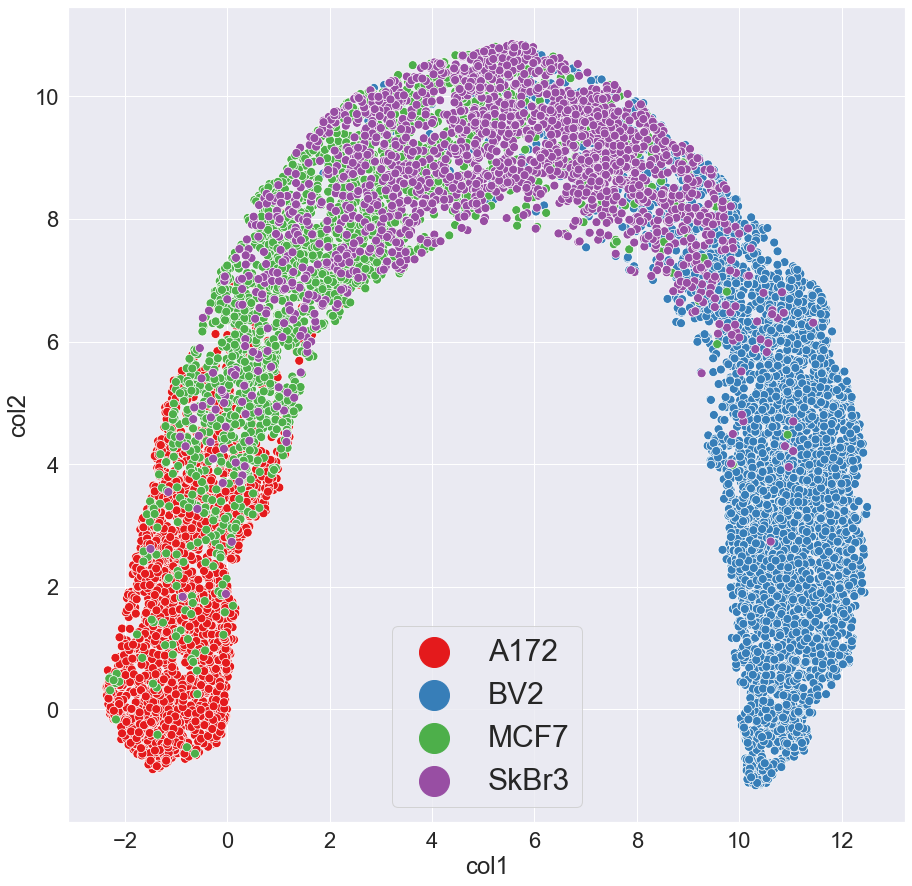

In [109]:
plt.figure(figsize=(15,15))
#plt.axis('off')
sns.scatterplot(data=df_F, x="col1", y="col2", s=80, hue="ClassLabels1", palette=('Set1'))
plt.legend(markerscale=5, fontsize=30)

In [82]:
label1

array(['A172', 'A172', 'A172', ..., 'SkBr3', 'SkBr3', 'SkBr3'],
      dtype='<U5')

In [83]:
import sklearn
sklearn.metrics.silhouette_score(embedding, label1, metric='euclidean', sample_size=None, random_state=None)

0.33153272

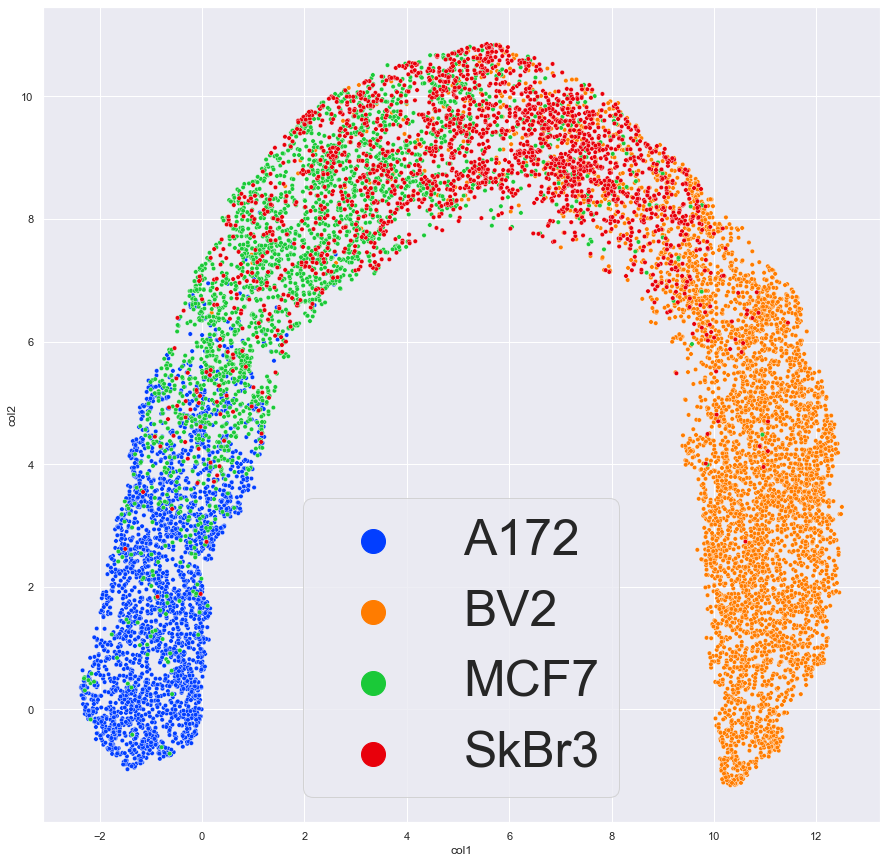

In [84]:

mu_gen_A=torch.vstack(mu_gen_All)
mu_gen_A=mu_gen_A.detach().numpy()

emb=dis_evaluator.reduce_latent2d(dis_evaluator.normalize_matrix(mu_gen_A), dim_red='umap')
df_F=[]
 
#data_real=np.hstack((embedding, labelAll[:]))
df1 = pd.DataFrame(emb, columns=['col1','col2'])
df2 = pd.DataFrame(label1, columns=['ClassLabels1'])
df3 = pd.DataFrame(label2, columns=['ClassLabels2'])
df_F=pd.concat([df1, df2, df3],axis=1)


plt.figure(figsize=(15,15))
sns.set(font_scale = 1)
sns.scatterplot(data=df_F, x="col1", y="col2", s=20, hue="ClassLabels1", palette=('bright'))
plt.legend(markerscale=4, fontsize=50)


In [85]:
df_X = pd.DataFrame(mu_real_All)

df_z_scaled = df_X.copy()
for column in df_z_scaled.columns:
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / (df_z_scaled[column].std())    
  

<AxesSubplot:>

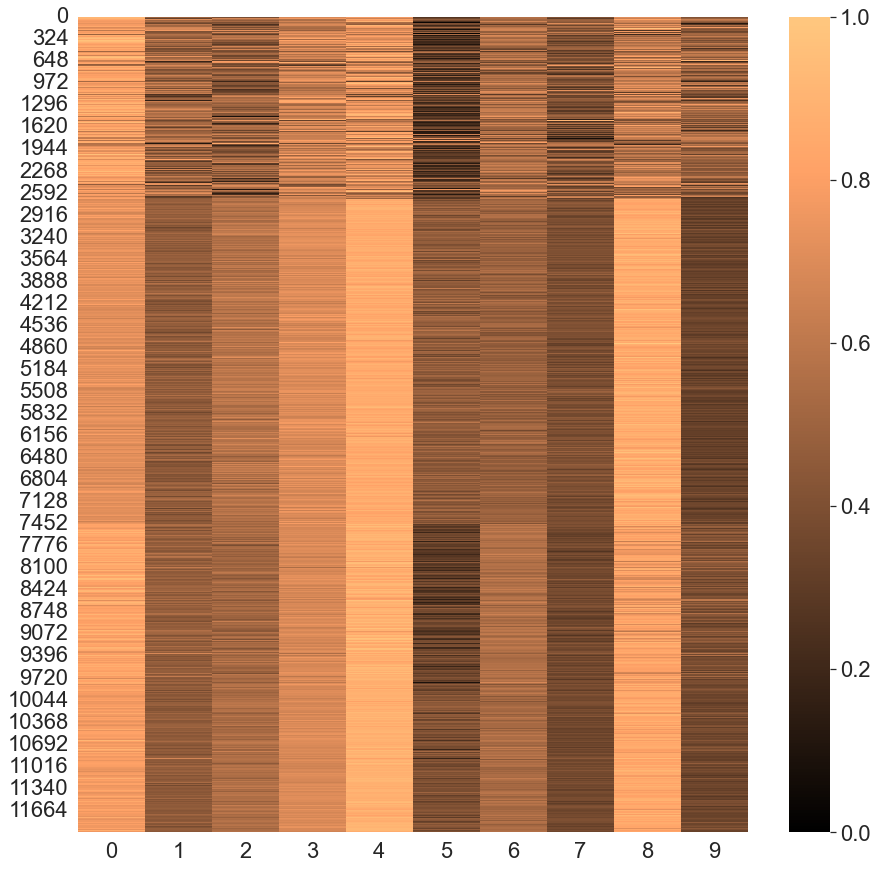

In [88]:
# copy the data
plt.figure(figsize=(15,15))

sns.set(font_scale = 2)


df_min_max_scaled = df_X.copy()
  
# apply normalization techniques
for column in df_min_max_scaled.columns:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
sns.heatmap(df_min_max_scaled, cmap='copper')

In [98]:
rearrange=['1', '8', '9', '4', '6', '0', '3', '5', '2', '7'] #CPA
rearrange=["1", '5', '9', '0', '3', '8', '4', '2', '6', '7']#LiveCell
rearrange=['3','0','8','6', '5', '4', '9', '7', '1', '2']# Lung Cancer
rearrange=['3','5','4', '7','6','1','9','2','0','8']#CellCycle
rearrange=['1','3','9','0','6','5','4','2', '7', '8']#EMT
rearrange=['9','4','8','1','7','0','5','3','2','6']
#i=0
# copy the data
plt.figure(figsize=(15,15))

sns.set(font_scale = 2)
NewMat=pd.DataFrame(df_min_max_scaled)
NewMat = NewMat.iloc[:, [9, 4, 8, 1, 7, 0, 5, 3, 2, 6]]    
#NewMat = NewMat.reindex(columns=['3', '0', '8', '6', '5', '4', '9', '7', '1', '2'])
#NewMat=pd.DataFrame.to_numpy(NewMat)


<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:>

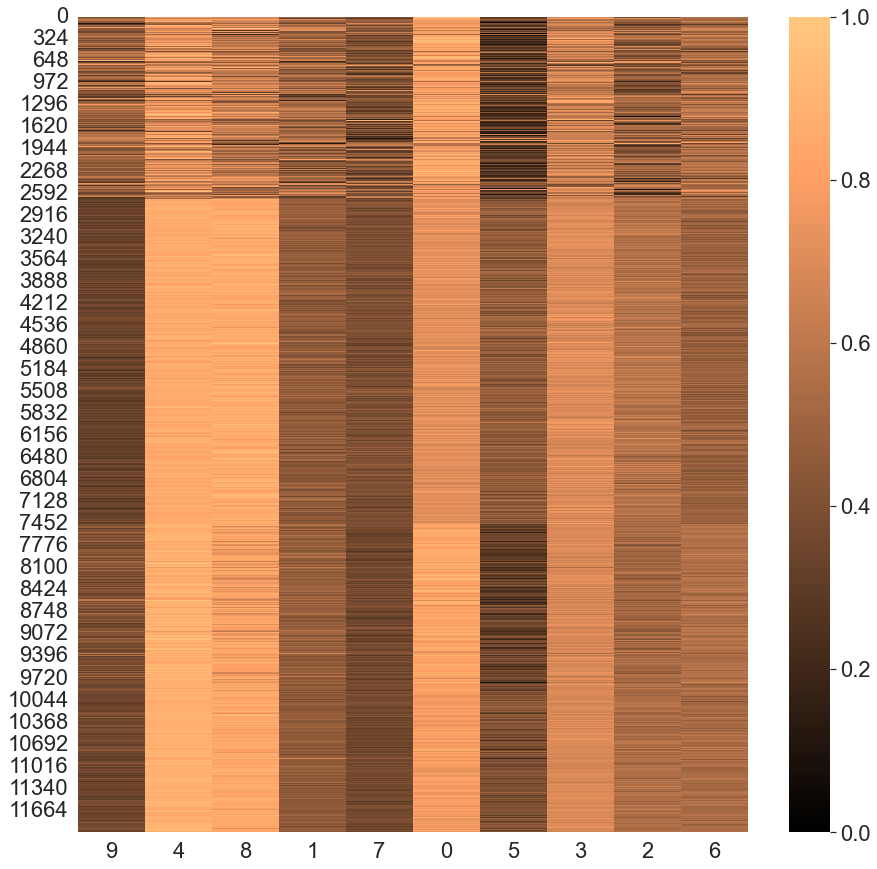

In [99]:

plt.figure(figsize=(15,15))

sns.set(font_scale = 2)

sns.heatmap(NewMat, cmap='copper')

In [91]:
mu_real_All

array([[ 5.2511132e-01,  2.6907977e-01, -8.6389774e-01, ...,
        -3.0756757e-01, -1.9108770e+00,  7.7085769e-01],
       [ 1.3919713e-01, -1.7391831e+00,  1.7003360e+00, ...,
        -1.5942594e-01, -4.0080338e+00,  7.6427567e-01],
       [ 4.3294865e-01,  6.0437649e-01, -1.6320208e-01, ...,
        -9.8665619e-01, -9.5302290e-01,  5.9815866e-01],
       ...,
       [-1.1359102e+00, -3.2229722e-04, -3.9476746e-01, ...,
        -9.6811876e-02, -5.1079130e-01, -4.1474733e-01],
       [-7.8458053e-01, -4.7812980e-01, -2.7094090e-01, ...,
        -1.5734157e-01, -6.4945585e-01, -7.3711878e-01],
       [-7.0233494e-02, -1.5468697e-01, -6.9922018e-01, ...,
        -3.9522633e-01, -5.6632841e-01,  2.0121963e-01]], dtype=float32)

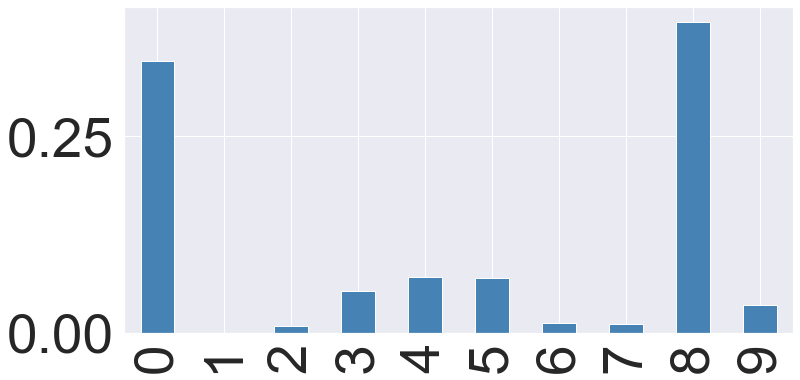

Accuracy: 0.7964121818940342


In [100]:
sns.set(font_scale=5)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
plt.grid(None)
#plt.axis('off')
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(mu_real_All, label1, test_size=0.2, random_state=1)
clf = DecisionTreeClassifier(criterion='gini', max_depth=7)
clf.fit(X_train, y_train)  # celltype
pd.Series(clf.feature_importances_, index=df_X.columns).plot.bar(color='steelblue', figsize=(12, 6))
plt.show()
y_pred = clf.predict(X_test)


print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [93]:
f1_score(y_test, y_pred, average='macro')

NameError: name 'f1_score' is not defined

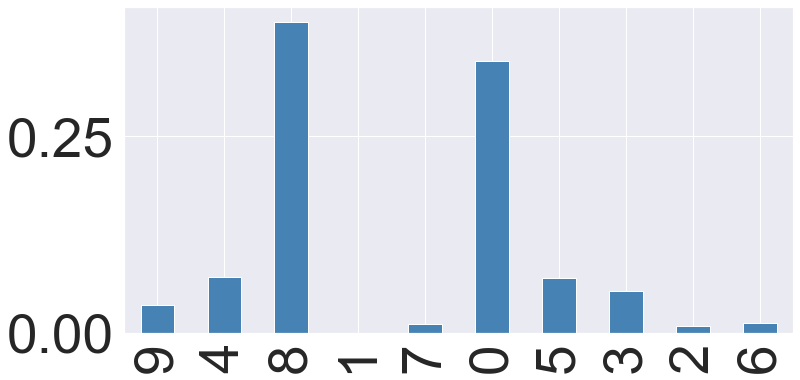

In [101]:
sns.set(font_scale=5)

rearrange= [9, 4, 8, 1, 7, 0, 5, 3, 2, 6]
imp=np.zeros(10)
i=0
for dim in rearrange:
    imp[i]=clf.feature_importances_[dim]
    i=i+1
pd.Series(imp, index=rearrange).plot.bar(color='steelblue', figsize=(12, 6))
plt.show()

In [102]:
df_min_max_scaled.loc[:,1]

0        0.510427
1        0.273847
2        0.549927
3        0.618864
4        0.305351
           ...   
11980    0.431124
11981    0.451478
11982    0.478691
11983    0.422403
11984    0.460506
Name: 1, Length: 11985, dtype: float32

C:\Users\Kevin Tsia\AppData\Local\Temp\ipykernel_19220\1952201988.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


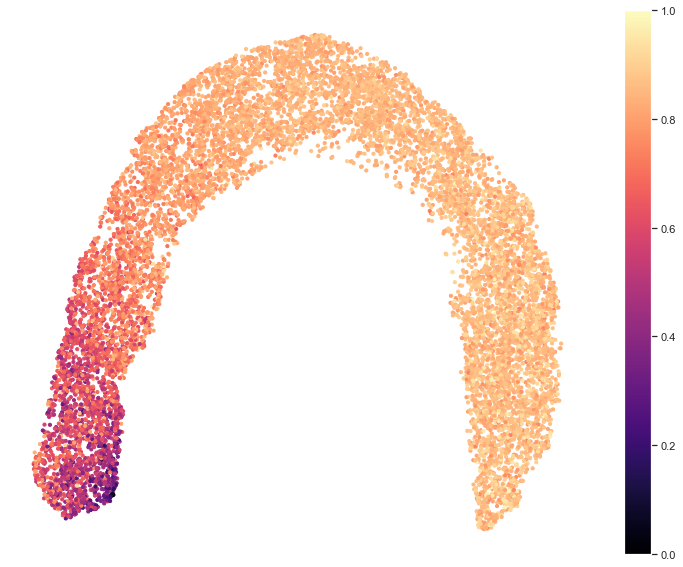

In [111]:

plt.figure(figsize=(13,10))
plt.grid(None)

sns.set(font_scale = 1)
b=plt.scatter(data=df_F, x="col1", y="col2", s=10, cmap='magma',  c=df_min_max_scaled.loc[:,8])
plt.colorbar()
plt.axis('off')

plt.show()


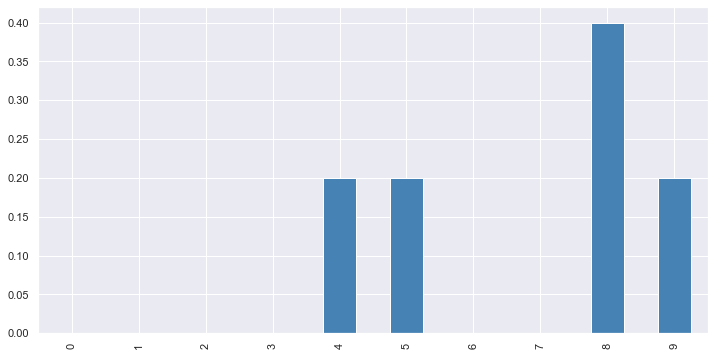

0.0

In [104]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
#plt.axis('off')
X_train, X_test, y_train, y_test = train_test_split(mu_real_All, df3, test_size=0.3, random_state=1)
clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
clf.fit(X_train, y_train)  # celltype
df_X=pd.DataFrame(mu_real_All)
pd.Series(clf.feature_importances_, index=df_X.columns).plot.bar(color='steelblue', figsize=(12, 6))
plt.show()
y_pred = clf.predict(X_test)

f1_score(y_test, y_pred, average='macro')

In [105]:
f1_score(y_test, y_pred, average='macro')

0.0

In [106]:
plt.figure(figsize=(10,10))
a=plt.scatter(data=df_F, x="col1", y="col2",s=10,cmap='jet', c=SortedFeatMat.Area)
plt.colorbar()
plt.show()

NameError: name 'SortedFeatMat' is not defined

<Figure size 720x720 with 0 Axes>

In [107]:
sns.set(font_scale=2)
plt.figure(figsize=(20,20))
label1=df3


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,plot_confusion_matrix
#X = mu_real_All
class_names = (['A172', 'BV2', 'MCF7', 'SkBr3'])
#class_names = (['H1975', 'H2170', 'H526'])


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(mu_real_All, label2, test_size=0.1, random_state=1)
from sklearn.svm import SVC
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.fit(X_train, y_train)


y_pred= clf.predict(X_test)

plt.rcParams.update({'font.size': 16})
disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true' , display_labels=class_names)
plt.axis('off')



C:\Users\Kevin Tsia\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kevin Tsia\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

ValueError: The number of FixedLocator locations (1923), usually from a call to set_ticks, does not match the number of ticklabels (4).

<Figure size 1440x1440 with 0 Axes>

Error in callback <function flush_figures at 0x000001AA8BD614C0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
y_pred

In [ ]:
plt.figure(figsize=(10,10))

ax = plt.subplot()
sns.set(font_scale=3.0) # Adjust to fit
cm=confusion_matrix(y_test, y_pred)
df=pd.DataFrame(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax, cmap="Blues");  # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('Observed labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Mock', 'Treatment']);
ax.yaxis.set_ticklabels(['Mock', 'Treatment']);
#ax.xaxis.set_ticklabels(['H1975', 'H2170', 'H526']);
#ax.yaxis.set_ticklabels(['H1975', 'H2170', 'H526']);

plt.show()

In [ ]:
df